<h2><center> <font color='cyan'> Urban Heat Scan Workflow </font> </center></h2>
<h3><center> <font color='cyan'>Table of Contents</font>   </center></h3>

[Preface: Import dependencies and set paths](#section0)
<br>
[Section 1: Big picture: City map and context](#section1)
<br>
[Section 2: Population density and tree cover city level](#section2) 
<br>
[Section 3: Visualize Vito heat rasters at city level](#section3) 
<br>
[Section 4: Create the Heat Scan PPT](#section4) 
<br>
[Section 5: Population density and tree cover Sub-city level. NA ](#section5) 




<a id='section0'></a>
<h5><center> <font color='cyan'> Preface: Import dependencies and set paths</font>   </center></h5>

In [1]:
# Import packages
import geopandas as gpd , os , time , glob
from collections import defaultdict
from itertools import combinations
from geemap import cartoee
import transbigdata as tbd
import matplotlib.patheffects as pe
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, TransformedBbox,
                                                   BboxPatch, BboxConnector)

# from matplotlib_scalebar.scalebar import ScaleBar


from rasterstats import raster_stats
from scipy import stats as scipy_stats

from urllib.request import urlopen
from pyproj import CRS
from os.path import exists
from geopandas.tools import overlay
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import ogr
import networkx as nx
import osmnx as ox
from shapely.geometry import mapping, Polygon
import fiona
import math
from shapely.affinity import rotate
from shapely.geometry import LineString, Point
import matplotlib.image as image
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes , mark_inset
from scipy.spatial import cKDTree

ox.config(use_cache=True, log_console=True)

import  seaborn as sn
import geemap 
import ee 
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
import osmnx as ox
from shapely.geometry import box
from rasterio.plot import show
import pylab as plt
from geopandas.tools import sjoin
import contextily as cx
from h3 import h3
import h3pandas
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
from rasterio.crs import CRS
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings("ignore")
# InteractiveShell.ast_node_interactivity = "last_expr" #Supress matplotlib output

# Stats heavy-lifting
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import  libpysal

from sklearn import metrics
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg

from pptx import Presentation
from pptx.util import Inches
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN

from pptx.oxml.xmlchemy import OxmlElement
from pptx.util import Cm
from pptx.enum.shapes import MSO_SHAPE
from pptx.dml.color import RGBColor
import plotly.graph_objects as go

plt.rcParams['hatch.color'] = 'white'
plt.rcParams['hatch.linewidth'] = 4.2
plt.rcParams['font.family'] = 'Yu Gothic'

# plt.rcParams['figure.figsize'] = 7.5 , 7.5
width=12
height=10
plt.rcParams['figure.figsize'] = width , height

cartopy is not installed. Please see https://scitools.org.uk/cartopy/docs/latest/installing.html#installing for instructions on how to install cartopy.

The easiest way to install cartopy is using conda: conda install -c conda-forge cartopy


C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\2195666055.py:40: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


**Set controls**

In [2]:
city_map=True
run_vito_analysis=False #
test_maps=False
run_tree_and_pop_analysis=False  #False True
create_the_ppt=False

In [3]:
def set_paths(base_dir):
    data = os.path.join(base_dir, 'data') 
    output = os.path.join(base_dir, 'output') 
    shapefiles = os.path.join(output, 'shapefiles') 
    maps = os.path.join(output, 'maps') 
    rasters = os.path.join(output, 'rasters') 
    tables = os.path.join(output, 'tables') 
    
    dirs_list= [data, output, base_dir, shapefiles , maps , rasters , tables]
    for dir in dirs_list:
        if not os.path.exists(dir):
            os.mkdir(dir)
    return data, shapefiles , maps , rasters , output ,tables



In [4]:
# Initialize ee and import shapefile and select city
ee.Initialize()
WGS84=4326 #uses degrees
WGS84_meters=3857 #uses meters
EPSG_str= 'EPSG:4326'
crs = 4326
city= "Nis City"
base_dir = f'C:/Users/Aziz/Dropbox/CRP/UHI/{city}'
data, shapefiles , maps , rasters , output ,tables = set_paths(base_dir)

# shapefile_path=f'{shapefiles}/geoBoundaries-SRB-ADM1_simplified.shp'
# Sub city donot exist somehow. City and municipailty are the same
# Serbia is divided into 145 municipalities and 29 cities,[2] which form the basic units of local government. 
# Each municipality has its own assembly (elected every four years in local elections), a municipal president, 
# public service property and a budget. Municipalities usually have more than 10,000 inhabitants.[2]

shapefile_path_country=f'{shapefiles}/geoBoundaries-SRB-ADM0.shp'
gdf_country = gpd.read_file(shapefile_path_country).to_crs(WGS84)
shapefile_path=f'{shapefiles}/geoBoundaries-SRB-ADM2.shp'
gdf_city = gpd.read_file(shapefile_path).to_crs(WGS84)
gdf_city=gdf_city[gdf_city["shapeName"] == city]
country= gdf_city.iloc[0]['shapeGroup']
gdf_citties_all = gpd.read_file(shapefile_path).to_crs(WGS84)

# OSM admin layers
tags = {"boundary":"administrative" }
minx, miny, maxx, maxy = gdf_city.to_crs(WGS84).total_bounds
all_admin_layers =ox.geometries.geometries_from_bbox(miny,maxy,minx, maxx, tags)
# Get the lowest 
lowest_admin_level=all_admin_layers["admin_level"].mode()[0]
sub_city_gdf = all_admin_layers[all_admin_layers['admin_level'] == lowest_admin_level]
lowest_admin_level_name="Settlement"
sub_city_gdf["pre_clip_area"] = sub_city_gdf['geometry'].area
sub_city_gdf = gpd.clip(sub_city_gdf.to_crs(crs), gdf_city.to_crs(crs))
sub_city_gdf["post_clip_area"] = sub_city_gdf['geometry'].area
sub_city_gdf["pct_clip_area"] = (sub_city_gdf["post_clip_area"]/sub_city_gdf["pre_clip_area"])*100
sub_city_gdf = sub_city_gdf[sub_city_gdf['pct_clip_area'] > 50]

# English name is missing at admin 7. Use names as the column   
all_admin_layers_reset=all_admin_layers.reset_index()
all_admin_layers_reset=pd.DataFrame(all_admin_layers_reset["admin_level"])
df_frequencies=pd.DataFrame(all_admin_layers_reset.admin_level.value_counts().T)
second_third_frequent_admin=df_frequencies.index[2]
second_third_frequent_admin_name="Municipality"
sub_city_gdf_1 = all_admin_layers[all_admin_layers['admin_level'] == second_third_frequent_admin]
sub_city_gdf_1["pre_clip_area"] = sub_city_gdf_1['geometry'].area
sub_city_gdf_1 = gpd.clip(sub_city_gdf_1.to_crs(crs), gdf_city.to_crs(crs))
sub_city_gdf_1["post_clip_area"] = sub_city_gdf_1['geometry'].area
sub_city_gdf_1["pct_clip_area"] = (sub_city_gdf_1["post_clip_area"]/sub_city_gdf_1["pre_clip_area"])*100
sub_city_gdf_1 = sub_city_gdf_1[sub_city_gdf_1['pct_clip_area'] > 50]
# fill english names with native names
sub_city_gdf['name:en']=sub_city_gdf['name:en'].str.strip().replace('', np.nan).fillna(sub_city_gdf['name'])
sub_city_gdf_1['name:en']=sub_city_gdf_1['name:en'].str.strip().replace('', np.nan).fillna(sub_city_gdf_1['name'])


# sub_city_gdf_1.plot()
# sub_city_gdf_1

C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\2376219604.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sub_city_gdf["pre_clip_area"] = sub_city_gdf['geometry'].area
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\2376219604.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sub_city_gdf["post_clip_area"] = s

<a id='section1'></a>
<h5><center> <font color='cyan'> Section 1: Big picture: City map</font>   </center></h5>


In [5]:
def create_city_map(country, city, vector_file,sub_city_gdf,admin_name, lowest_admin_level,basemap, basemap_label, map_output):
        plt.rc('font', weight='bold')
        crs=3857
        vector_file_degrees=vector_file.copy()
        vector_file=vector_file.to_crs(crs)
        width=11
        height=10
        # fig = plt.figure(figsize=(width+5, height+5))
        fig = plt.figure(figsize=(width, height))
        ax = fig.add_subplot(111)
        ax = vector_file.to_crs(crs).plot(ax=ax,
                                        alpha=0.6,  
                                        facecolor='none',
                                        edgecolor='blue' , 
                                        label=f"{city}",
                                        linewidth=2  
                                        )


        sub_city_gdf=sub_city_gdf.to_crs(crs)
        ax = sub_city_gdf.to_crs(crs).plot(ax=ax,
                                        alpha=0.7,  
                                        facecolor='none',
                                        edgecolor='cyan' ,
                                        label=f"{city}",
                                        linewidth=.5,
                                        missing_kwds={"color": "white", "edgecolor": "magenta", "label": "none"}
                                        )
        # 
        # gdf=gdf.rename(columns = {'name:en':'name_en'}, inplace = True)
        sub_city_gdf['name_en'] =sub_city_gdf[admin_name]               
        sub_city_gdf= sub_city_gdf.replace('nan', np.nan) #.dropna(how='all', axis=1, inplace=True)
        label = sub_city_gdf.dropna(subset='name_en')
        texts = []
        for i, row in label.iterrows(): 
                # print(f"Subcity name: {str(row['name_en'])}")
                texts.append(ax.annotate(text=str(row['name_en']), 
                                         xy=row.geometry.centroid.coords[0], color="black", 
                                         ha='center', fontsize=7,  path_effects=[pe.withStroke(linewidth=2, 
                                                                                               foreground="white")]))
                
        # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='blue'), ax=ax)
        # adjust_text(texts, ax=ax)

        # adjust_text(texts)
        vector_file_buffer = vector_file.to_crs(crs).buffer(2000) #for zoom out
        minx, miny, maxx, maxy = vector_file_buffer.total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
    
        #Identifying how many tiles
        latlon_outline = vector_file.to_crs(WGS84).total_bounds
        def_zoom = cx.tile._calculate_zoom(*latlon_outline)
        howmany= cx.howmany(*latlon_outline, def_zoom+2, ll=True)
        print(f'Default Zoom level {def_zoom} and +2 is {howmany}')


        try:
                cx.add_basemap(ax,
                        zoom="auto",
                        # zoom=abs(def_zoom-1),
                        # zoom=def_zoom,
                        crs=vector_file.crs.to_string(),
                        source= basemap,
                        # source=cx.providers.CartoDB.PositronOnlyLabels,
                        # source=cx.providers.CartoDB.DarkMatter,
                        attribution=False, #No citation
                        # zorder = 2
                        )
        except:
                pass

        try:
                cx.add_basemap(ax,
                        # zoom="auto",
                        zoom=abs(def_zoom),
                        crs=vector_file.crs.to_string(),
                        # source=cx.providers.OpenStreetMap.Mapnik,
                        source=basemap_label, #cx.providers.CartoDB.PositronOnlyLabels,
                        # source=cx.providers.CartoDB.DarkMatter,
                        attribution=False, #No citation
                        # zorder = 3
                        )
        except:
                pass


        try:
                cx.add_basemap(ax,
                        # zoom="auto",
                        zoom=abs(def_zoom-1),
                        crs=vector_file.crs.to_string(),
                        # source=cx.providers.OpenStreetMap.Mapnik,
                        source=basemap_label, #cx.providers.CartoDB.PositronOnlyLabels,
                        # source=cx.providers.CartoDB.DarkMatter,
                        attribution=False, #No citation
                        # zorder = 2
                        )
        except:
                pass

        ax2 = inset_axes(ax, "25%", "35%", loc="upper right")
        ax2 = vector_file.to_crs(crs).plot(ax=ax2, 
                                        #    alpha=0.6,
                                        #    column= visualize_column, 
                                        facecolor='none',
                                        edgecolor='blue' ,
                                        label=f"{city}", 
                                        linewidth=1,
                                        #    zorder = 2

                                        )
        ax2 = gdf_country.to_crs(crs).plot(ax=ax2, 
                                        #  alpha=0.6,
                                        facecolor='none',
                                        edgecolor='black' , 
                                        label=f"{country}",
                                        linewidth=1,
                                                # zorder = 3

                                        )
        try:
                cx.add_basemap(ax2,
                        zoom="auto",
                        # zoom=10,
                        crs=vector_file.crs.to_string(),
                        source=basemap, #cx.providers.OpenStreetMap.Mapnik,
                        attribution=False, #No citation
                        # zorder = 4
                        )
        except:
                pass

        try:
                cx.add_basemap(ax2,
                        # zoom="auto",
                        zoom=abs(def_zoom-6),
                        crs=vector_file.crs.to_string(),
                        # source=cx.providers.OpenStreetMap.Mapnik,
                        source=basemap_label, #cx.providers.CartoDB.PositronOnlyLabels,
                        # source=cx.providers.CartoDB.DarkMatter,
                        attribution=False, #No citation
                        # zorder = 4
                        )
        except:
                pass

        box, c1, c2 = mark_inset(ax2, ax, loc1=2, loc2=4, fc="none", lw=.5, ec='r')
        box.set_linewidth(.5)
        plt.setp([c1,c2], linewidth=0)


        LegendElement = [
                        Line2D([0],[0],
                               color='black', 
                               label=f'{country}', 
                               fillstyle=None,
                               linestyle="none", 
                               markerfacecolor=None,
                               marker="s", 
                               markersize=5.5),
                        Line2D([0],[0], 
                               color='blue', 
                               label=f'{city}',
                               linestyle="none", 
                               markerfacecolor=None,
                               fillstyle=None, 
                               marker="s", 
                               markersize=5.5),
                      Line2D([0],[0], 
                               color='cyan', 
                               label=f'{lowest_admin_level}',
                               linestyle='none', 
                               markerfacecolor=None,
                               fillstyle=None, 
                               marker="s", 
                               markersize=5.5)
                               ]
        ax2.legend(handles=LegendElement,loc='upper right', prop = { "size": 8 },)
        # get axis position and instert the N arrow 
        # x, y , x+dx, y+dy

        minx, miny, maxx, maxy =  gdf_country.to_crs(crs).total_bounds # [113.6,22.4,114.8,22.9]
        bounds=[minx, miny, maxx, maxy]
        print(f"Country bounds:{bounds}")
        dx=maxx-minx
        dy=maxy-miny
        arrow_x= maxx-abs(dx/6.5)
        arrow_y= maxy-abs(dy/4.7)
        arrow_sign_x=maxx-abs(dx/8.1)
        arrow_sign_y=maxy-abs(dy/3.4)
        head_width=abs(dy/17)
        overhang=.1
        head_length=1.6*head_width
        ax2.text(x=arrow_x, y=arrow_y, s='N', fontsize=13)
        ax2.arrow(arrow_sign_x, arrow_sign_y, dx=dx*0, dy=dy/14 , length_includes_head=True,
                head_width=head_width, head_length=head_length, overhang=overhang, facecolor='k')

        ax2.axis('off')
        index=0
        polygon = vector_file_degrees.reset_index().iloc[index]['geometry']
        tags={'amenity':['college', 'dancing_school', 'driving_school', 'kindergarten', \
                        'language_school', 'library', 'surf_school', 'toy_library', 'research_institute', \
                        'training', 'music_school', 'school', 'university'],
                        'landuse': 'education'
                        }
        education=ox.features.features_from_polygon(polygon, tags)
        # tags={'leisure':['park', 'nature_reserve', 'protected_area', 'garden']}
        tags={'leisure':['park',  'garden']}
        park=ox.features.features_from_polygon(polygon, tags)
        park.geometry = park['geometry'].centroid
        tags={'landuse':['commercial', 'industrial', 'construction', 'retail']                   }
        industry=ox.features.features_from_polygon(polygon, tags)
        industry.geometry = industry['geometry'].centroid
        tags={'building': 'government'}
        government_building=ox.features.features_from_polygon(polygon, tags)
        government_building.geometry = government_building['geometry'].centroid
        tags = {"building": True}
        building_footprint=ox.features.features_from_polygon(polygon, tags)
        building_footprint.geometry = building_footprint['geometry'].centroid
        tags = {'amenity':['clinic', 'doctors', 'dentist', 'health_post', 'hospital', 'nursing_home', 'pharmacy', 'veterinary']}
        health_care=ox.features.features_from_polygon(polygon, tags)
        health_care.geometry = health_care['geometry'].centroid
        G = ox.graph.graph_from_polygon(polygon, network_type='drive')
        # add travel time based on maximum speed
        G = ox.add_edge_speeds(G) 
        G = ox.add_edge_travel_times(G) 
        G = ox.projection.project_graph(G, to_crs=3857)
        # get edges as Geo data frame
        _, gdf_edges = ox.graph_to_gdfs(G)

        ax = education.to_crs(crs).plot(ax=ax,
                                        alpha=0.6,  
                                        facecolor='yellow',
                                        edgecolor='yellow' , 
                                        label="Education",
                                        linewidth=3,
                                        markersize=10,
                                        marker="P"  
                                        )
        
        ax = industry.to_crs(crs).plot(ax=ax,
                                        alpha=0.6,  
                                        facecolor='red', 
                                        edgecolor='red' , 
                                        label="Industries",
                                        linewidth=3,
                                        markersize=10,
                                        marker="p"  
                                        )
        
        ax = park.to_crs(crs).plot(ax=ax,
                                        alpha=0.6,  
                                        facecolor='green',
                                        edgecolor='green' , 
                                        label="Parks",
                                        linewidth=3,
                                        markersize=10,
                                        marker="*"   
                                        )
        ax = health_care.to_crs(crs).plot(ax=ax,
                                        alpha=0.6,  
                                        facecolor='magenta',
                                        edgecolor='magenta' , 
                                        label="Healthcare",
                                        linewidth=3,
                                        markersize=10,
                                        marker="o"   
                                        )

        ax = gdf_edges.to_crs(crs).plot(ax=ax,
                                        alpha=0.4,  
                                        facecolor='none',
                                        edgecolor='black' , 
                                        label="Roads",
                                        linewidth=.3,
                                        linestyle='dashed',
                                        # zorder=1
                                        )



        
        lines = [Line2D([0], [0], linestyle="none",  fillstyle=None, marker="P", markersize=10, color='yellow' , label='Education'),
                 Line2D([0], [0], linestyle="none",  fillstyle=None, marker="p", markersize=10, color='red' , label='Industries'),
                 Line2D([0], [0], linestyle="none",  fillstyle=None, marker="*", markersize=10, color='green' , label='Parks'),
                 Line2D([0], [0], linestyle="none",  fillstyle=None, marker="o", markersize=10, color='magenta' , label='Healthcare'),
                 Line2D([0], [0], linestyle="dashed",  fillstyle=None, marker="_", markersize=10, color='black' , label='Roads')]
        ax.legend(handles=lines,loc='lower right', prop = { "size": 8 },)

        ax.axis('off')
        ax.set_title(f'{city}', fontdict={'fontsize': '16', 'fontweight' : '6'})
        # ax.annotate('Source: OSM basemaps',xy=(0.1, .1),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=6, color='#555555')
        plt.xticks(visible=False)
        plt.yticks(visible=False)
        plt.tight_layout()
        ax.figure.savefig(map_output,  bbox_inches='tight',   dpi = 400)
        return education, park, industry, government_building, building_footprint, gdf_edges


Using zoom level 14, this will download 378 tiles
Default Zoom level 12 and +2 is 378
Country bounds:[2094396.9041382559, 5195832.129412373, 2561050.602912707, 5810857.733396657]


C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3000908182.py:211: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  park.geometry = park['geometry'].centroid
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3000908182.py:214: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  industry.geometry = industry['geometry'].centroid
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3000908182.py:217: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  government_building.geometry = government_building['geometry'].centroid
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3000908182.py:220: Use

Using zoom level 14, this will download 378 tiles
Default Zoom level 12 and +2 is 378
Country bounds:[2094396.9041382559, 5195832.129412373, 2561050.602912707, 5810857.733396657]


C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3000908182.py:211: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  park.geometry = park['geometry'].centroid
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3000908182.py:214: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  industry.geometry = industry['geometry'].centroid
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3000908182.py:217: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  government_building.geometry = government_building['geometry'].centroid
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3000908182.py:220: Use

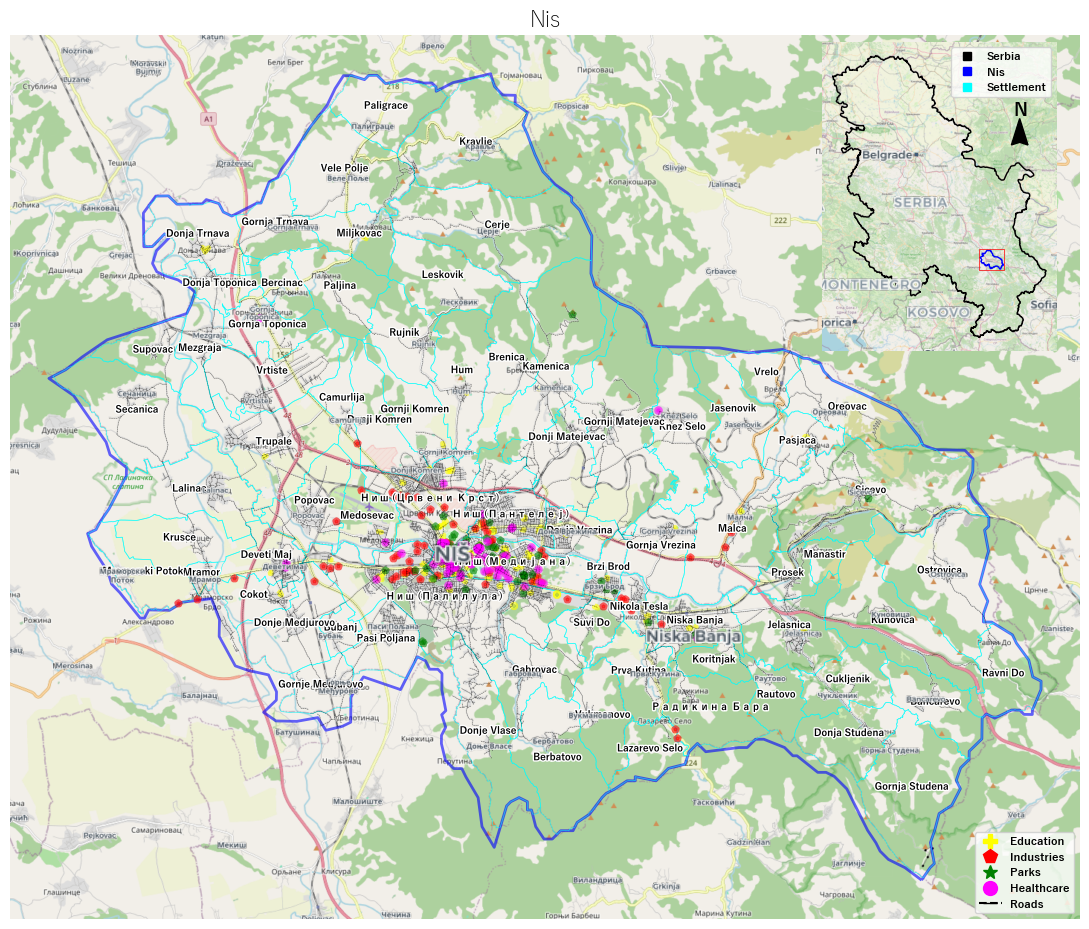

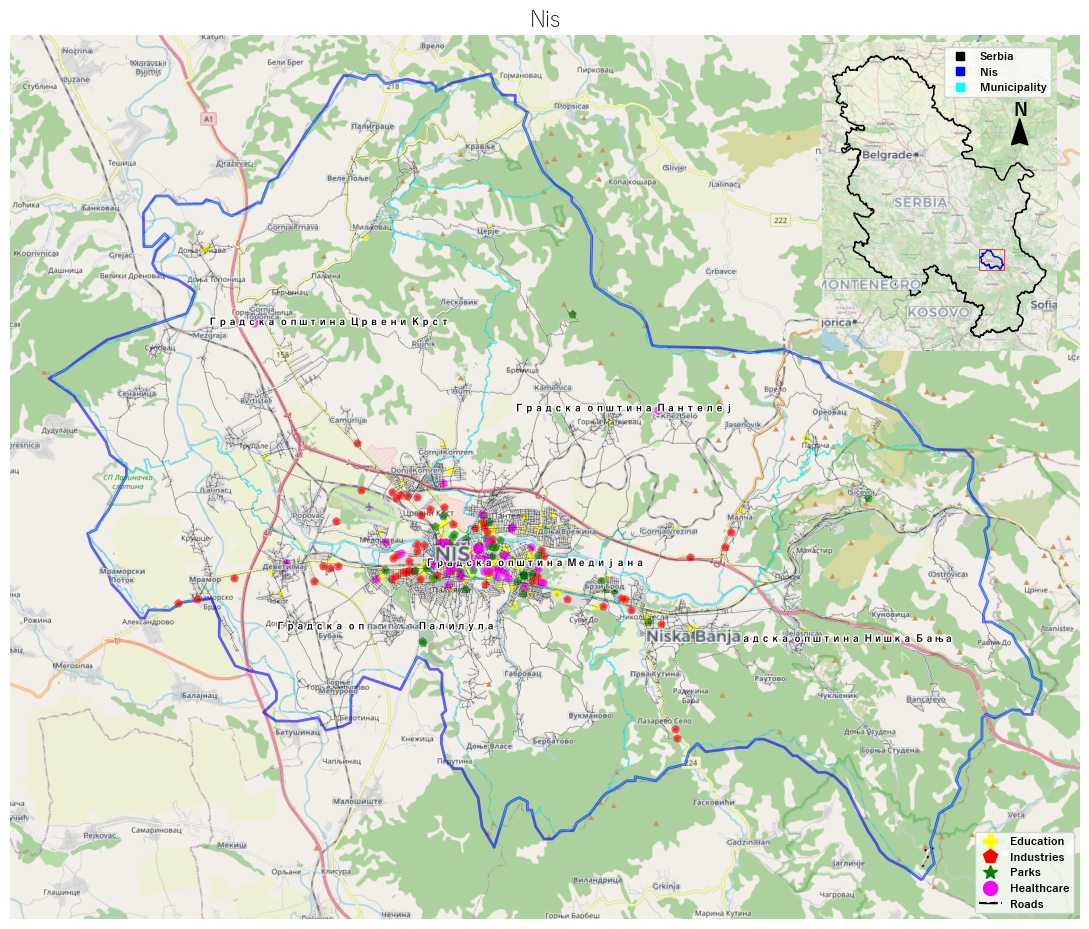

In [6]:
# %%capture
city_map=True
if __name__ ==  '__main__': 
    if city_map:
        # # City level map
        vector_file=gdf_city
        country="Serbia"
        city="Nis"

        try:
                basemap= cx.providers.OpenStreetMap.Mapnik
                basemap_label=cx.providers.CartoDB.PositronOnlyLabels
                basemap_name="Mapnik"
                admin_name='name:en'    
                lowest_admin_level=lowest_admin_level_name   
                map_output= os.path.join(maps, f"{city}_{lowest_admin_level}_{basemap_name}.png")
                create_city_map(country, city, vector_file,sub_city_gdf,admin_name, lowest_admin_level,basemap, basemap_label, map_output)
                admin_name='name'  
                lowest_admin_level= second_third_frequent_admin_name  
                map_output= os.path.join(maps, f"{city}_{lowest_admin_level}_{basemap_name}.png")
                create_city_map(country, city, vector_file,sub_city_gdf_1,admin_name, lowest_admin_level,basemap, basemap_label, map_output)
        except:
            pass

        try:
            basemap= cx.providers.OpenStreetMap.Mapnik
            basemap_label=cx.providers.CartoDB.PositronOnlyLabels
            basemap_name="Mapnik"
            map_output= os.path.join(maps, f"{city}_{basemap_name}.png")
            city_map= create_city_map(country, city, vector_file, sub_city_gdf, lowest_admin_level, basemap, basemap_label, map_output)
        except:
            pass

        try:
            basemap= cx.providers.OpenStreetMap.BlackAndWhite
            basemap_label=cx.providers.CartoDB.PositronOnlyLabels
            basemap_name="BlackAndWhite"
            map_output= os.path.join(maps, f"{city}_{basemap_name}.png")
            city_map= create_city_map(country, city, vector_file, sub_city_gdf, lowest_admin_level, basemap, basemap_label, map_output)
        except:
            pass

        try:
            basemap= cx.providers.Stamen.Toner
            basemap_label=cx.providers.Stamen.TonerLabels
            basemap_name="Stamen"
            map_output= os.path.join(maps, f"{city}_{basemap_name}.png")
            city_map= create_city_map(country, city, vector_file, sub_city_gdf,lowest_admin_level, basemap, basemap_label, map_output)
        except:
            pass
        try:
            basemap= source=cx.providers.CartoDB.DarkMatter
            basemap_label=cx.providers.CartoDB.PositronOnlyLabels
            basemap_name="CartoDB"
            map_output= os.path.join(maps, f"{city}_{basemap_name}.png")
            city_map= create_city_map(country, city, vector_file, sub_city_gdf,lowest_admin_level, basemap, basemap_label, map_output)
        except:
            pass

        try:
            basemap= cx.providers.Esri.WorldStreetMap
            basemap_label=cx.providers.CartoDB.PositronOnlyLabels
            basemap_name="Esri"
            map_output= os.path.join(maps, f"{city}_{basemap_name}.png")
            city_map= create_city_map(country, city, vector_file, sub_city_gdf, lowest_admin_level,basemap, basemap_label, map_output)
        except:
            pass
        try:
            basemap= cx.providers.Esri.WorldImagery
            basemap_label=cx.providers.CartoDB.PositronOnlyLabels
            basemap_name="Esri_WorldImagery"
            map_output= os.path.join(maps, f"{city}_{basemap_name}.png")
            city_map= create_city_map(country, city, vector_file, sub_city_gdf, lowest_admin_level, basemap, basemap_label, map_output)
        except:
            pass

        try:
            basemap= cx.providers.USGS.USImagery
            basemap_label=cx.providers.CartoDB.PositronOnlyLabels
            basemap_name="USGS_USImagery"
            map_output= os.path.join(maps, f"{city}_{basemap_name}.png")
            city_map= create_city_map(country, city, vector_file, sub_city_gdf, lowest_admin_level,basemap, basemap_label, map_output)
        except:
            pass

        try:
            basemap= cx.providers.CartoDB.Positron
            basemap_label=cx.providers.CartoDB.PositronOnlyLabels
            basemap_name="CartoDB_Positron"
            map_output= os.path.join(maps, f"{city}_{basemap_name}.png")
            city_map= create_city_map(country, city, vector_file, sub_city_gdf,lowest_admin_level, basemap, basemap_label, map_output)
        except:
            pass

        try:
            basemap= cx.providers.CartoDB.Voyager
            basemap_label=cx.providers.CartoDB.VoyagerOnlyLabels
            basemap_name="CartoDB_Voyager"
            map_output= os.path.join(maps, f"{city}_{basemap_name}.png")
            city_map= create_city_map(country, city, vector_file, sub_city_gdf, lowest_admin_level,basemap, basemap_label, map_output)
        except:
            pass


<a id='section2'></a>
<h5><center> <font color='cyan'> Section 2: Population density and tree cover city level</font>   </center></h5>

In [7]:
def create_fc_collection(gdf_city):
    poly = gdf_city.geometry.unary_union
    gdf_boundary = gpd.GeoDataFrame(geometry=[poly],crs=gdf_city.crs)
    geom = gdf_boundary['geometry']
    jsonDict = eval(geom.to_json())
    for index, row in gdf_boundary.iterrows(): 
        polygon_list= []
        for x in jsonDict['features'][index]['geometry']['coordinates']:
            polygon_list.append(x)
            region = ee.Geometry.Polygon(polygon_list)
            fc_filtered = ee.FeatureCollection(region)
    # gdf_boundary.plot()
    return fc_filtered  , region 

def clipToCol(image):
  """clip gee collection
  args:
      image: Image collection
  returns:
    ee-collection: Clipped image collection
   
   """
  return image.clip(fc_filtered)

def download_tree_cover(ee , EPSG_str, region):
    tree_cover=ee.ImageCollection("projects/sat-io/open-datasets/GFCC30TC") \
        .limit(1, 'system:time_start', False).first().clip(fc_filtered)
    tree_cover_tif = os.path.join(rasters, 'tree_cover_projected.tif')
    geemap.ee_export_image(
        tree_cover, filename=tree_cover_tif,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=30, region=region, file_per_band=False
    )
    return tree_cover_tif

def download_tree_cover_esa_vito(ee , EPSG_str, region):
    tree_cover=ee.ImageCollection("ESA/WorldCover/v100") \
        .limit(1, 'system:time_start', False).first().clip(fc_filtered).eq(10) #trees only
        # .limit(1, 'system:time_start', False).select(10).first().clip(fc_filtered) #trees only
    tree_cover_tif_esa = os.path.join(rasters, 'tree_cover_projected_esa.tif')
    geemap.ee_export_image(
        tree_cover, filename=tree_cover_tif_esa,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=10, region=region, file_per_band=False
    )
    return tree_cover_tif_esa


def dowload_pop_density(ee , EPSG_str, region):
    #  Define WorldPop & clip using function 
    pop_density = ee.ImageCollection("WorldPop/GP/100m/pop").map(clipToCol). \
                    filterDate('2020').select('population').mosaic()

    pop_density_tif = os.path.join(rasters, 'pop_density_projected.tif')
    geemap.ee_export_image( pop_density, 
                           filename=pop_density_tif,  
                           crs=EPSG_str,
                           # crs_transform=crs_transform,
                           scale=100, 
                           region=region, 
                           file_per_band=False
                           )

    return pop_density_tif

# Takes longer
def download_google_dynamic_worldcover(ee , EPSG_str, region):
    # dynamic_world_cover=ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
    #     .limit(1, 'system:time_start', False).map(clipToCol).mosaic() #all only
    dynamic_world_cover=ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
        .limit(1, 'system:time_start', False).mosaic().clip(fc_filtered)
    google_dynamic_world_cover_projected = os.path.join(rasters, 'google_dynamic_world_cover_projected.tif')
    geemap.ee_export_image(
        dynamic_world_cover, filename=google_dynamic_world_cover_projected,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=10, region=region, file_per_band=False
    )
    return google_dynamic_world_cover_projected

def download_esri_dynamic_worldcover(ee , EPSG_str, region): 
    dynamic_world_cover=ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS")\
        .filterDate('2022-01-01','2022-12-31').mosaic().clip(fc_filtered)
    esri_dynamic_world_cover_projected = os.path.join(rasters, 'esri_dynamic_world_cover_projected.tif')
    geemap.ee_export_image(
        dynamic_world_cover, filename=esri_dynamic_world_cover_projected,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=10, region=region, file_per_band=False
    )
    return esri_dynamic_world_cover_projected

def reproject_rasters(crs ,output_dir, unprojected_raster, projected_raster):
    if not exists(projected_raster):
        with rasterio.open(unprojected_raster) as src:
            dst_crs = 'EPSG:' + str(crs)
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
                # ,'dtype': np.float32
            })

            with rasterio.open(projected_raster, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        # dtype= np.float32,
                        resampling=Resampling.nearest)

def polygonize(raster_file ,output_shapefile, crs, mask_value, raster_val):
    # mask = None
    with rasterio.Env():
        with rasterio.open(raster_file ) as src: #, dtype= np.float32
            image = src.read(1) # first band
            no_data_value=0
            image = np.where(image<0,no_data_value,image) #replaced negative values with 0
            results = (
            {'properties': {raster_val : v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                shapes(image, mask=mask_value, transform=src.transform)))

    # The result is a generator of GeoJSON features
    geoms = list(results)
    # first feature
    # print(geoms[0])
    gpd_polygonized_raster  = gpd.GeoDataFrame.from_features(geoms)
    crs_utm = CRS.from_user_input(crs)
    driver= 'ESRI Shapefile'
    gpd_polygonized_raster.to_file(output_shapefile, driver, crs=crs_utm)
    return gpd_polygonized_raster

def calcBearing (lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    bearing = math.atan2(x,y)   # use atan2 to determine the quadrant
    bearing = math.degrees(bearing)
    return bearing

def calcNSEW(lat1, long1, lat2, long2):
    points = ["north", "north east", "east", "south east", "south", "south west", "west", "north west"]
    bearing = calcBearing(lat1, long1, lat2, long2)
    bearing += 22.5
    bearing = bearing % 360
    bearing = int(bearing / 45) # values 0 to 7
    NSEW = points [bearing]
    return NSEW

def ordinal(n: int):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    return str(n) + suffix

def get_osm_tags_inside_clusters(cluster_boundaries):   
    for index, poi in cluster_boundaries.iterrows():
        polygon = cluster_boundaries.iloc[index]['geometry']
        park , education, industry, building=get_services_infrastructure_inside_poly(polygon)
    return park , education, industry, building

def delete_shapefile(output_shapefile):
    shapefile = ogr.Open(output_shapefile,1 )
    layer=shapefile.GetLayerByIndex(0)
    count=layer.GetFeatureCount()
    for feature in range(count):
        layer.DeleteFeature(feature)


def map_clusters(maps, hexagons, legend_title,legends_format, crs ,cmap,  visualize_column, title):
    hexagons=hexagons.to_crs(crs)
    hexagons = hexagons.sort_values('cluster_area_deg', ascending = False).groupby('ward5wknn').head(2)
    hexagons=hexagons.reset_index()
    for index, poi in hexagons.iterrows():
        try:
            cluster_class=poi["ward5wknn"]
            polygon = hexagons[hexagons["ward5wknn"]==index]
            # polygon = hexagons.iloc[index]['geometry']  
            map_output= f'{maps}/{city}_{visualize_column}_{index}_{cluster_class}_cluster.png'
            ax = polygon.plot(figsize=(10, 10), \
                                        column= visualize_column, \
                                        facecolor='none',edgecolor='cyan' , \
                                        linewidth=1.5 , \
                                        alpha=0.6, categorical=True , cmap=cmap, \
                                        legend=True,  # Add legend 
                                        legend_kwds={'loc':'upper right', 
                                                        'bbox_to_anchor':(1, 1), 
                                                        'fmt':legends_format,
                                                        'markerscale':1.01, 
                                                        'title_fontsize':'small', 
                                                        'fontsize':'x-small'
                                                        # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                        } ,
                                        aspect=1
                                                )
            # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
            polygon_buffer = polygon.to_crs(crs).buffer(0.016) #for zoom out
            minx, miny, maxx, maxy = polygon_buffer.total_bounds
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)

            cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,  crs=crs) 
            # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
            # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs , zoom=12) 
            cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs, zoom=11) # zoom=13

            # plt.title(f'{title}',fontsize=16)
            plt.xticks([])
            plt.yticks([]) 
            leg1 = ax.get_legend()
            # Set markers to square shape
            for ea in leg1.legendHandles:
                ea.set_marker('s')
            leg1.set_title(f'{legend_title}')
            ax.title.set_text(f'{title}')
            plt.tight_layout()
            # ax.figure.savefig(map_output)
            ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

        except:
            pass
        
def map_clusters_land_cover(maps, hexagons, legend_title,legends_format, crs ,cmap,  visualize_column, title):
    hexagons=hexagons.to_crs(crs)
    hexagons=hexagons.reset_index()
    hexagons = hexagons.sort_values('cluster_area_deg', ascending = False).groupby('ward5wknn').head(2)
    for index, poi in hexagons.iterrows():
        try:
            cluster_class=poi["ward5wknn"]
            polygon = hexagons[hexagons["ward5wknn"]==index]
            # polygon = hexagons.iloc[index]['geometry']  
            map_output= f'{maps}/{city}_{visualize_column}_{index}_{cluster_class}_cluster.png'
            ax = polygon.plot(figsize=(10, 10), \
                                        column= visualize_column, \
                                        facecolor='none',edgecolor='cyan' , \
                                        linewidth=1.5 , \
                                        alpha=0.6, categorical=True , cmap=cmap, \
                                        legend=True,  # Add legend 
                                        legend_kwds={'loc':'upper right', 
                                                        'bbox_to_anchor':(1, 1), 
                                                        'fmt':legends_format,
                                                        'markerscale':1.01, 
                                                        'title_fontsize':'small', 
                                                        'fontsize':'x-small'
                                                        # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                        } ,
                                        aspect=1
                                                )
            # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
            polygon_buffer = polygon.to_crs(crs).buffer(0.016) #for zoom out
            minx, miny, maxx, maxy = polygon_buffer.total_bounds
            print("Pre-non bounds", minx, miny, maxx, maxy)
            if not [x for x in (minx, miny, maxx, maxy) if x is None]:
                print(minx, miny, maxx, maxy)
                ax.set_xlim(minx, maxx)
                ax.set_ylim(miny, maxy)

                cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,  crs=crs) 
                # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
                # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs , zoom=12) 
                cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs, zoom=11) # zoom=13

                plt.title(f'{title}',fontsize=16)
                plt.xticks([])
                plt.yticks([]) 
                leg1 = ax.get_legend()
                # Set markers to square shape
                for ea in leg1.legendHandles:
                    ea.set_marker('s')
                leg1.set_title(f'{legend_title}')
                ax.title.set_text(f'{title}')
                plt.tight_layout()
                # ax.figure.savefig(map_output)
                ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)
        except:
            pass


def map_func(maps, vector_file,  hexagons, legend_title,legends_format, crs ,cmap,  visualize_column, title, map_output, scheme, categorical):
    if categorical==True:
        ax = hexagons.to_crs(crs).plot(figsize=(10, 10), \
                                    column= visualize_column, \
                                    alpha=0.6, categorical=True , cmap=cmap, \
                                    legend=True,  # Add legend 
                                    legend_kwds={'loc':'upper right', 
                                                    'bbox_to_anchor':(1, 1), 
                                                    'fmt':legends_format,
                                                    'markerscale':1.01, 
                                                    'title_fontsize':'small', 
                                                    'fontsize':'x-small'
                                                    # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                    } ,
                                    aspect=1
                                            )
    elif categorical==False:
        ax = hexagons.to_crs(crs).plot(figsize=(10, 10), \
                                    column= visualize_column, \
                                    alpha=0.6, scheme=scheme, cmap=cmap, \
                                    legend=True,  # Add legend 
                                    legend_kwds={'loc':'upper right', 
                                                    'bbox_to_anchor':(1, 1), 
                                                    'fmt':legends_format,
                                                    'markerscale':1.01, 
                                                    'title_fontsize':'small', 
                                                    'fontsize':'x-small'
                                                    # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                    } ,
                                    aspect=1
                                            )
    vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    cx.add_basemap(ax, zoom="auto", crs=crs, source=cx.providers.OpenStreetMap.Mapnik)

    # plt.title(f'{title}',fontsize=16)
    plt.xticks([])
    plt.yticks([]) 
    leg1 = ax.get_legend()
    # Set markers to square shape
    for ea in leg1.legendHandles:
        ea.set_marker('s')
    leg1.set_title(f'{legend_title}')
    ax.title.set_text(f'{title}')
    plt.tight_layout()
    # ax.figure.savefig(map_output)
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)


def map_land_cover(vector_file,  hexagons,title, legend_title, crs,  visualize_column, map_output):
    class_labels = {1: "Water , blue", 2: "Trees, green", 4:"Flooded Vegetation, magenta", 5:"Crops, seagreen", 7:"Built Area, tan", 8:"Bare Ground, goldenrod", 9:"Snow/Ice, snow", 10:"Clouds, ghostwhite", 11:"Rangeland, greenyellow" }
    hexagons[['class', 'color']] = hexagons['esri_dyna'].map(class_labels).str.split(', ',expand=True).values
    color_map= dict(zip(hexagons["class"], hexagons["color"]))
    ax = hexagons.to_crs(crs).plot(figsize=(10, 10), \
                                column= visualize_column, \
                                alpha=0.6, categorical=True , color=hexagons.color, \
                                legend=True,  # Add legend 
                                legend_kwds={'loc':'upper right', 
                                                'bbox_to_anchor':(1, 1), 
                                                'fmt':legends_format,
                                                'markerscale':1.01, 
                                                'title_fontsize':'small', 
                                                'fontsize':'x-small'
                                                # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                } ,
                                aspect=1
                                        )
    
    vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs , zoom=12) 
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs, zoom=11) # zoom=13
    plt.title(f'{title}',fontsize=16)
    plt.xticks([])
    plt.yticks([]) 
    handles = [Line2D([0], [0], marker='s', color='w', markerfacecolor=k, label=v, markersize=8) for v, k in color_map.items()]
    ax.legend(title=legend_title, handles=handles, bbox_to_anchor=(1, 1),markerscale=1.01,title_fontsize='small',fontsize='x-small', loc='upper right')
    plt.tight_layout()
    # ax.figure.savefig(map_output)
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

**OSM Network: Get Travel Time and Shortest path from a given point or an edge of a hotspot**

In [8]:
def get_network_stats(polygon):
     try:
          # polygon = cluster_boundaries.iloc[index]['geometry'] 
          graph = ox.graph.graph_from_polygon(polygon, network_type='drive')
          # Retrieve only edges from the graph
          edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
          graph_proj = ox.project_graph(graph)
          # fig, ax = ox.plot_graph(graph_proj) 
          # Get Edges and Nodes
          nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
          # print("Coordinate system:", edges_proj.crs)
          # edges_proj.head()
          # Get Edges and Nodes
          nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
          # print("Network Coordinate system: projected", edges_proj.crs)
          # edges_proj.head()
          # Get the Convex Hull of the network
          convex_hull = edges_proj.unary_union.convex_hull
          # Calculate the area
          area = convex_hull.area
          # Calculate statistics with density information
          stats = ox.stats.basic_stats(graph_proj, area=area) #replace area by city polygon
          stats =pd.Series(stats) #edge_density_km(road density) - edge_length_total per sq km
     except:
          stats=0
          stats =pd.Series(stats) 
          pass     
     return stats

def get_osm_network():
    G = ox.graph_from_place(place, network_type='drive')
    # impute speed on all edges missing data
    G = ox.add_edge_speeds(G)
    # calculate travel time (seconds) for all edges
    G = ox.add_edge_travel_times(G)
    # see mean speed/time values by road type
    edges = ox.graph_to_gdfs(G, nodes=False)
    edges['highway'] = edges['highway'].astype(str)
    edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

    # same thing again, but this time pass in a few default speed values (km/hour)
    # to fill in edges with missing `maxspeed` from OSM
    hwy_speeds = {'residential': 35,
                'secondary': 50,
                'tertiary': 60}
    G = ox.add_edge_speeds(G, hwy_speeds)
    G = ox.add_edge_travel_times(G)
    # calculate two routes by minimizing travel distance vs travel time
    orig = list(G)[1]
    dest = list(G)[-1]
    route1 = nx.shortest_path(G, orig, dest, weight='length')
    route2 = nx.shortest_path(G, orig, dest, weight='travel_time')

    # compare the two routes
    route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
    route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
    route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
    route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
    print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
    print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

    # pick route colors
    c1 = 'r' #length
    c2 = 'b' #travel_time
    rc1 = [c1] * (len(route1) - 1)
    rc2 = [c2] * (len(route2) - 1)
    rc = rc1 + rc2
    nc = [c1, c1, c2, c2]

    # plot the routes
    fig, ax = ox.plot_graph_routes(G, [route1, route2], route_color=rc, route_linewidth=6,
                                node_size=0, bgcolor='k')
    location_point = (33.299896, -111.831638)
    G2 = ox.graph_from_point(location_point, dist=400, truncate_by_edge=True)
    # impute speed on all edges missing data
    G2 = ox.add_edge_speeds(G2)
    # calculate travel time (seconds) for all edges
    G2 = ox.add_edge_travel_times(G2)
    origin = (33.301821, -111.829871)
    destination = (33.301402, -111.833108)
    origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
    destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
    route = ox.shortest_path(G2, origin_node, destination_node)
    # compare the two routes
    route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G2, route, 'length')))
    route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G2, route, 'travel_time')))
    print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
    fig, ax = ox.plot_graph_route(G2, route, route_color="c", node_size=0)

def get_services_infrastructure(center_point, dist):

     tags={'leisure':['park', 'nature_reserve', 'protected_area', 'garden']}
     park= ox.features.features_from_point(center_point=center_point, tags=tags, dist=dist)
     
     tags={'amenity':['college', 'dancing_school', 'driving_school', 'kindergarten', \
                    'language_school', 'library', 'surf_school', 'toy_library', 'research_institute', \
                         'training', 'music_school', 'school', 'university'],
                         'landuse': 'education'
                         }
     education= ox.features.features_from_point(center_point=center_point, tags=tags, dist=dist)
     
     tags={'landuse':['commercial', 'industrial', 'construction', 'retail']                   }
     industry= ox.features.features_from_point(center_point=center_point, tags=tags, dist=dist)
     
     # tags={'building': True}
     tags={'building': 'government'}
     building= ox.features.features_from_point(center_point=center_point, tags=tags, dist=dist)
     return park , education, industry, building

def get_services_infrastructure_inside_poly(polygon):
     try:
          tags={'leisure':['park', 'nature_reserve', 'protected_area', 'garden']}
          park=ox.features.features_from_polygon(polygon, tags)
     except:
          park=0
          pass
     try:
          tags={'amenity':['college', 'dancing_school', 'driving_school', 'kindergarten', \
                         'language_school', 'library', 'surf_school', 'toy_library', 'research_institute', \
                              'training', 'music_school', 'school', 'university'],
                              'landuse': 'education'
                              }
          education=ox.features.features_from_polygon(polygon, tags)
     except:
          education=0
          pass
     try:
          tags={'landuse':['commercial', 'industrial', 'construction', 'retail']                   }
          industry=ox.features.features_from_polygon(polygon, tags)
     except:
          industry=0
          pass
     try:
          tags={'building': 'government'}
          building=ox.features.features_from_polygon(polygon, tags)
     except:
          building=0
          pass
     # print("park , education, industry, building:", park , education, industry, building)
     return park , education, industry, building



def export_services_infrastructure_inside_poly_to_shp(shapefile):
     index=0
     polygon = shapefile.iloc[index]['geometry']
     # polygon = shapefile['geometry']
     try:
          tags={'leisure':['park', 'nature_reserve', 'protected_area', 'garden']}
          park=ox.features.features_from_polygon(polygon, tags)
          # print("nodes to be dropped")
          # park.drop(['nodes'], axis = 1)
          # print("nodes dropped")
          # copy poly to new GeoDataFrame
          points = park.copy()
          # change the geometry
          points.geometry = points['geometry'].centroid
          # same crs
          points.crs =points.crs
          points=points.applymap(lambda x: str(x) if isinstance(x, list) else x)
          points.to_file(f'{shapefiles}/park.shp', driver='ESRI Shapefile')
          park=points
          # park.to_file(f'{shapefiles}/park.shp', driver='ESRI Shapefile')
     except:
          # park=0
          pass
     try:
          tags={'amenity':['college', 'dancing_school', 'driving_school', 'kindergarten', \
                         'language_school', 'library', 'surf_school', 'toy_library', 'research_institute', \
                              'training', 'music_school', 'school', 'university'],
                              'landuse': 'education'
                              }
          education=ox.features.features_from_polygon(polygon, tags)
          # print("nodes to be dropped")
          # education.drop(['nodes'], axis = 1)
          # print("nodes dropped")
          points = education.copy()
          # change the geometry
          points.geometry = points['geometry'].centroid
          # same crs
          points.crs =points.crs
          points=points.applymap(lambda x: str(x) if isinstance(x, list) else x)
          points.to_file(f'{shapefiles}/education.shp', driver='ESRI Shapefile')
          education=points

          # education.to_file(f'{shapefiles}/education.shp', driver='ESRI Shapefile')

     except:
          # education=0
          pass
     try:
          tags={'landuse':['commercial', 'industrial', 'construction', 'retail']                   }
          industry=ox.features.features_from_polygon(polygon, tags)
          # print("industry to be dropped")
          # industry.drop(['nodes'], axis = 1)
          # print("industry nodes dropped")
          # industry.to_file(f'{shapefiles}/industry.shp', driver='ESRI Shapefile')
          points = industry.copy()
          # change the geometry
          points.geometry = points['geometry'].centroid
          # same crs
          points.crs =points.crs
          points=points.applymap(lambda x: str(x) if isinstance(x, list) else x)
          points.to_file(f'{shapefiles}/industry.shp', driver='ESRI Shapefile')
          industry=points

     except:
          # industry=0
          pass
     try:
          tags={'building': 'government'}
          building=ox.features.features_from_polygon(polygon, tags)
          # print("building to be dropped")
          # building.drop(['nodes'], axis = 1)
          # print("building nodes dropped")
          # building.to_file(f'{shapefiles}/building_government.shp', driver='ESRI Shapefile')
          points = building.copy()
          # change the geometry
          points.geometry = points['geometry'].centroid
          # same crs
          points.crs =points.crs
          points=points.applymap(lambda x: str(x) if isinstance(x, list) else x)
          points.to_file(f'{shapefiles}/government_building.shp', driver='ESRI Shapefile')
          building=points

     except:
          # building=0
          pass

     try:
          # fprints = ox.footprints.footprints_from_polygon(polygon, footprint_type ='building')
          
          tags = {"building": True}
          building_footprint=ox.features.features_from_polygon(polygon, tags)
          # print("footprints building to be dropped")
          # # fprints.drop(['nodes'], axis = 1)
          # print("footprints building nodes dropped")
          # fprints.to_file(f'{shapefiles}/building_footprint.shp', driver='ESRI Shapefile')
          points = building_footprint.copy()
          # change the geometry
          points.geometry = points['geometry'].centroid
          # same crs
          points.crs =points.crs
          points=points.applymap(lambda x: str(x) if isinstance(x, list) else x)
          points.to_file(f'{shapefiles}/building_footprint.shp', driver='ESRI Shapefile')
          building_footprint=points


     except:
          # fprints=0
          pass
     # print("park , education, industry, building:", park , education, industry, building)

     return park , education, industry, building, building_footprint


def multi2single(gpdf):
    gpdf_singlepoly = gpdf[gpdf.geometry.type == 'Polygon']
    gpdf_multipoly = gpdf[gpdf.geometry.type == 'MultiPolygon']

    for i, row in gpdf_multipoly.iterrows():
        Series_geometries = pd.Series(row.geometry)
        df = pd.concat([gp.GeoDataFrame(row, crs=gpdf_multipoly.crs).T]*len(Series_geometries), ignore_index=True)
        df['geometry']  = Series_geometries
        gpdf_singlepoly = pd.concat([gpdf_singlepoly, df])

    gpdf_singlepoly.reset_index(inplace=True, drop=True)
    return gpdf_singlepoly


def create_ahc_knn_clusters(db  , raster_val , WGS84_meters):
    raster_val=raster_val[0:9]
    db =db.to_crs(WGS84_meters)
    db['area_sqm'] = db.geometry.area
    cluster_variables = [raster_val]
    db_scaled = robust_scale(db[cluster_variables])
    w = KNN.from_dataframe(db, k=4) #k for four nearest neighbors
    # Specify cluster model with spatial constraint
    model = AgglomerativeClustering(
        linkage="ward", connectivity=w.sparse, n_clusters=5
    )
    # Fit algorithm to the data
    model.fit(db_scaled)
    db["ward5wknn"] = model.labels_
    db['ward5wknn_sum'] = db[cluster_variables].groupby(db['ward5wknn']).transform('sum')
    db['area_sum'] = db['area_sqm'].groupby(db['ward5wknn']).transform('sum')
    db['area_sum'] = db['area_sum'].apply(lambda x: x/10000) #Hectares
    visualize_var= 'ward5wknn_sum_per_meter'
    db[visualize_var] = db['ward5wknn_sum'].div(db['area_sum']).round(2)
    # select the columns that you with to use for the dissolve and that will be retained
    cluster_boundaries = db[[raster_val , visualize_var,"ward5wknn", "geometry", "area_sqm", "area_sum", "ward5wknn_sum"]]
    # dissolve the state boundary by region 
    cluster_boundaries = cluster_boundaries.dissolve(by="ward5wknn" , aggfunc={raster_val: "sum", visualize_var: "sum" , "area_sqm":"sum" , "area_sum": "sum", "ward5wknn_sum": "sum",} , )
    cluster_boundaries=cluster_boundaries.explode().reset_index() #convert multipolygons to single part polygons. Multis cause errors
    cluster_boundaries["area_for_dupes"]=cluster_boundaries.geometry.area
#     cluster_boundaries=cluster_boundaries.sort_values('area_for_dupes', ascending=False).drop_duplicates(["ward5wknn"])
    cluster_boundaries=multi2single(cluster_boundaries)
    cluster_boundaries = cluster_boundaries.to_crs(crs)
    cluster_boundaries["centroid"] = cluster_boundaries["geometry"].centroid
    cluster_boundaries['lon'] = cluster_boundaries['centroid'].x
    cluster_boundaries['lat'] = cluster_boundaries['centroid'].y
    cluster_boundaries['cluster_area_deg'] = cluster_boundaries.geometry.area
    return db , cluster_boundaries, visualize_var


def create_ahc_knn_clusters_vito(db  , raster_val , WGS84_meters):
     raster_val=raster_val[0:9]
     db =db.to_crs(WGS84_meters)
     db['area_sqm'] = db.geometry.area
     cluster_variables = [raster_val]
     db_scaled = robust_scale(db[cluster_variables])
     w = KNN.from_dataframe(db, k=4) #k for four nearest neighbors
     # Specify cluster model with spatial constraint
     model = AgglomerativeClustering(
          linkage="ward", connectivity=w.sparse, n_clusters=5
     )
     # Fit algorithm to the data
     model.fit(db_scaled)
     db["ward5wknn"] = model.labels_
     db['ward5wknn_sum'] = db[cluster_variables].groupby(db['ward5wknn']).transform('sum')
     db['area_sum'] = db['area_sqm'].groupby(db['ward5wknn']).transform('sum')
     db['area_sum'] = db['area_sum'].apply(lambda x: x/10000) #Hectares
     visualize_var= 'ward5wknn_sum_per_meter'
     db[visualize_var] = db['ward5wknn_sum'].div(db['area_sum']).round(2)
     # select the columns that you with to use for the dissolve and that will be retained
     cluster_boundaries = db[[raster_val , visualize_var,"ward5wknn", "geometry", "area_sqm", "area_sum", "ward5wknn_sum"]]
     # dissolve the state boundary by region 
     cluster_boundaries = cluster_boundaries.dissolve(by="ward5wknn" , aggfunc={raster_val: "sum", visualize_var: "sum" , "area_sqm":"sum" , "area_sum": "sum", "ward5wknn_sum": "sum",} , )
     cluster_boundaries=cluster_boundaries.explode().reset_index() #convert multipolygons to single part polygons. Multis cause errors
     cluster_boundaries["area_for_dupes"]=cluster_boundaries.geometry.area
     # cluster_boundaries=cluster_boundaries.sort_values('area_for_dupes', ascending=False).drop_duplicates(["ward5wknn"])
     cluster_boundaries=multi2single(cluster_boundaries)
     cluster_boundaries = cluster_boundaries.to_crs(crs)
     cluster_boundaries["centroid"] = cluster_boundaries["geometry"].centroid
     cluster_boundaries['lon'] = cluster_boundaries['centroid'].x
     cluster_boundaries['lat'] = cluster_boundaries['centroid'].y
     cluster_boundaries['cluster_area_deg'] = cluster_boundaries.geometry.area
     return db , cluster_boundaries, visualize_var


def dissolve_categorical(db  , raster_val , WGS84_meters):
     db =db.to_crs(WGS84_meters)
     db['area_sqm'] = db.geometry.area
     cluster_variables = [raster_val]
     # db_scaled = robust_scale(db[cluster_variables])
     # w = KNN.from_dataframe(db, k=4) #k for four nearest neighbors
     # # Specify cluster model with spatial constraint
     # model = AgglomerativeClustering(
     #      linkage="ward", connectivity=w.sparse, n_clusters=15
     # )
     # # Fit algorithm to the data
     # model.fit(db_scaled)
     # db["ward5wknn"] = model.labels_
     db["ward5wknn"] = db[raster_val]
     db['ward5wknn_sum'] = db[cluster_variables].groupby(db['ward5wknn']).transform('sum')
     db['area_sum'] = db['area_sqm'].groupby(db['ward5wknn']).transform('sum')
     db['area_sum'] = db['area_sum'].apply(lambda x: x/10000) #Hectares
     visualize_var= 'ward5wknn_sum_per_meter'
     db[visualize_var] = db['ward5wknn_sum'].div(db['area_sum']).round(2)
     # select the columns that you with to use for the dissolve and that will be retained
     cluster_boundaries = db[[raster_val , visualize_var,"ward5wknn", "geometry", "area_sqm", "area_sum", "ward5wknn_sum"]]
     # dissolve the state boundary by region 
     cluster_boundaries = cluster_boundaries.dissolve(by="ward5wknn" , aggfunc={raster_val: "sum", visualize_var: "sum" , "area_sqm":"sum" , "area_sum": "sum", "ward5wknn_sum": "sum",} , )
     cluster_boundaries=cluster_boundaries.explode().reset_index() #convert multipolygons to single part polygons. Multis cause errors
     cluster_boundaries["area_for_dupes"]=cluster_boundaries.geometry.area
     # cluster_boundaries=cluster_boundaries.sort_values('area_for_dupes', ascending=False).drop_duplicates(["ward5wknn"])
     cluster_boundaries=multi2single(cluster_boundaries)
     cluster_boundaries = cluster_boundaries.to_crs(crs)
     cluster_boundaries["centroid"] = cluster_boundaries["geometry"].centroid
     cluster_boundaries['lon'] = cluster_boundaries['centroid'].x
     cluster_boundaries['lat'] = cluster_boundaries['centroid'].y
     cluster_boundaries['cluster_area_deg'] = cluster_boundaries.geometry.area
     return db , cluster_boundaries, visualize_var



def describe_cluster_trees_pop(cluster_boundaries, category, maps):
     category=category[0:9]
     df = pd.DataFrame(cluster_boundaries.drop(columns='geometry'))
     df = df.sort_values('cluster_area_deg', ascending = False).groupby('ward5wknn').head(2)
     df = df.reset_index() 
     df['Rank'] = df['ward5wknn_sum_per_meter'].rank(method='dense', ascending=False)
     df= df.sort_values(['Rank'], ascending=[True])
     cent= cluster_boundaries.dissolve().centroid 
     # White house 38.8977° N, 77.0365° W. centroid of the city.
     lat1 = float(cent.centroid.y)
     long1= float(cent.centroid.x)
     list_statements= []
     stats_dict= defaultdict(list)
     for index, row in df.iterrows():
          lat2 = row['lat'] # cent.centroid.y  #38.8893
          long2 =row['lon'] # cent.centroid.x  # -77.0506
          # print(f"lat1 {lat1} , long1 {long1}, lat2 {lat2}, long2 {long2}")
          points = calcNSEW(lat1, long1, lat2, long2)
          rank= int(row['Rank'])
          rank= ordinal(rank)
          value= row['ward5wknn_sum_per_meter']
          statement= f"A cluster that is located in the {points} of the city, is ranked {rank} and has the value of {value}"
          list_statements.append(statement)
          try:
               polygon = cluster_boundaries.iloc[index]['geometry']
               cluster_area_deg= cluster_boundaries.iloc[index]['cluster_area_deg']
               ward5wknn= cluster_boundaries.iloc[index]['ward5wknn']
               park , education, industry, building=get_services_infrastructure_inside_poly(polygon)
               stats_dict["cluster"].append(index)
               stats_dict["ward5wknn"].append(ward5wknn)
               stats_dict["points"].append(points)
               stats_dict["cluster_area_deg"].append(cluster_area_deg)
               stats_dict["rank"].append(rank)
               stats_dict["value"].append(value)
          except:
               pass

          try:
               stats_dict["park"].append(len(park))
          except:
               pass

          try:
               stats_dict["education"].append(len(education))
          except:
               pass

          try:
               stats_dict["industry"].append(len(industry))
          except:
               pass

          try:
               stats_dict["building"].append(len(building))
          except:
               pass

          try:
               
               park["ward5wknn"]=ward5wknn
               park["index"]=index
               park["points"]=points
               park["rank"]=rank
               park["value"]=value
               park.to_csv(f"{tables}/{ward5wknn}_{category}_park_df.csv")
          except:
               pass

          try:
               education["ward5wknn"]=ward5wknn
               education["index"]=index
               education["points"]=points
               education["rank"]=rank
               education["value"]=value
               education.to_csv(f"{tables}/{ward5wknn}_{category}_education_df.csv")
          except:
               pass

          try:
               industry["ward5wknn"]=ward5wknn
               industry["index"]=index
               industry["points"]=points
               industry["rank"]=rank
               industry["value"]=value
               industry.to_csv(f"{tables}/{ward5wknn}_{category}_industry_df.csv")
          except:
               pass

          try:
               building["ward5wknn"]=ward5wknn
               building["index"]=index
               building["points"]=points
               building["rank"]=rank
               building["value"]=value
               building.to_csv(f"{tables}/{ward5wknn}_{category}_building_df.csv")               
          except:
               pass

          try:
               stats=get_network_stats(polygon)
               stats = stats.to_frame(0).T
               # category=category[0:9]
               stats.to_csv(f"{tables}/{ward5wknn}_{category}_infra_network_stats.csv")
          except:
               print(f"no network for {ward5wknn}")
               pass
     
     try:
          statement_df=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in stats_dict.items() ]))
          # category=category[0:9]
          statement_df.to_csv(f"{tables}/{category}_amenities_stats_all.csv")
     except:
          print("No amenities")
          pass

     return list_statements


def describe_db( db_var, category, tables):
     try:
          category=category[0:9]
          cluster_variables= category
          k5desc = db_var.groupby('ward5wknn')[cluster_variables].describe()
          df1=k5desc.reset_index(0).reset_index(drop=True)
          # category=category[0:9]
          df1.to_csv(f"{tables}/{category}_summary_stats_df.csv")
     except:
          pass

# place = 'Nis, Serbia'
# get_osm_network_and_travel_time=get_osm_network()


In [9]:
def download_landsurface_temperature(city, cities_reprojected, max_value , years, month0 ,  month1):

    """
    download_landsurface_temperature: Exports Land Surface temperature rasters for a given country in the cities shapefile

    :param country: Name of the country
    :param cities_reprojected: geopandas read cities shapefile
    :param max_value: cap the number of cities
    :param years: years
    :param month0 : first hottest month
    :param month1 : last hottest month

    :return: confirms the export of rasters

    """

    # Create a jsondictionary from the geometry of the  shapefile
    geom = cities_reprojected['geometry']
    jsonDict = eval(geom.to_json())

    for index, row in cities_reprojected.iterrows():
        #   print(1)
        #   city= row['NAME_1'].lower() #instruct the column for city name in the city shapefile
          if index  <= max_value:
              city_number= index
              print(1)
              for x in jsonDict['features'][city_number]['geometry']['coordinates']:
                  try:
                      AOI = ee.Geometry.Polygon(x) #cast polygon as ee geometry
                      landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                      #   print(3)
                      # Filter for hottest months in the past X years
                      def filter_hot_month(i):
                          return ee.Filter.date(years[i] + '-' + month0 + '-01', years[i] + '-' + month1 + '-01')

                      range_list= list(map(filter_hot_month, list(range(0, 10)))) #combination of months and years
                      rangefilter = ee.Filter.Or(range_list)
                    #   print(4)
                      # Define a function to scale the data and mask unwanted pixels
                      def maskL457sr(image):
                          # Bit 0 - Fill
                          # Bit 1 - Dilated Cloud
                          # Bit 2 - Cirrus (high confidence)
                          # Bit 3 - Cloud
                          # Bit 4 - Cloud Shadow
                          qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
                          saturationMask = image.select('QA_RADSAT').eq(0)
                          # Apply the scaling factors to the appropriate bands.
                          thermalBand = image.select('ST_B10').multiply(0.00341802).add(149.0)
                          # Replace the original bands with the scaled ones and apply the masks.
                          return image.addBands(thermalBand, None, True).updateMask(qaMask).updateMask(saturationMask)
                      #   print(5)
                      # Apply filter and mask
                      collectionSummer = landsat.filter(rangefilter).filterBounds(AOI).map(maskL457sr).select('ST_B10').mean().add(-273.15).clip(AOI)
                      # collectionSummer=collectionSummer.toFloat()

                      lst_tif = os.path.join(rasters, 'lst_projected.tif')
                      geemap.ee_export_image( 
                                            # collectionSummer.toUint8(), 
                                            collectionSummer.toFloat(), 
                                            filename=lst_tif,  
                                            crs=EPSG_str,
                                            # crs_transform=crs_transform,
                                            scale=30, 
                                            region=AOI
                                            # file_per_band=False
                                            )
                        
                  except Exception as e:
                      print(f"Error : {e} ")
                  return  lst_tif


In [10]:
%%capture
if __name__ ==  '__main__': 
    if run_tree_and_pop_analysis:
        # # City level map
        df_filtered= gdf_city
        title="City Boundary"
        legend_title= 'Boundary'
        visualize_column="shapeName"
        map_output= os.path.join(maps, f"{city}_{title}_map.png")
        export = map_city(maps=maps, vector_file=gdf_city, crs=crs, legend_title=legend_title,  \
                            visualize_column=visualize_column, title=title, map_output=map_output)

        crs = 4326
        fc_filtered  , region= create_fc_collection(gdf_city= gdf_city) 

        
        #-----------------------------------------------------------------------------------#

        # #Args
        cities_reprojected=gdf_city.reset_index()
        max_value=len(cities_reprojected)
        years =list(str(i) for i in range(2013, 2024)) #years from 2013-2023
        month0 = '06'  # first hottest month  # update for each country
        month1 = '09'  # end of hottest month (note that this is exclusive)  # update for each country
        country= 'SRB' # replace with the relevent country name
        lst_t= download_landsurface_temperature( city, cities_reprojected, max_value, years, month0, month1)
        raster_filename= "land_surface_temperature"
        unprojected_raster =lst_t  
        projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
        reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, \
                                projected_raster=projected_raster)

        output_shapefile = f'{shapefiles}/polygonized_{raster_filename}.shp'
        mask_value=None
        variable= raster_filename
        tif = projected_raster #os.path.join(rasters, 'tree_cover_projected.tif')
        raster_val= variable[0:9]
        name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  \
                            mask_value=mask_value, raster_val=raster_val)  

        cmap = "OrRd"
        # cmap = "Greens"
        # cmap = "YlGn"
        legends_format= '{:,.0f}'
        legend_title= "LST"
        map_title= f"Land Surface Temperature across {city}"
        scheme="quantiles"
        categorical=False
        map_output= f'{maps}/{city}_map_{raster_val}.png'
        polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
        newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")

        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
                hexagons=newdf,legend_title=legend_title, legends_format=legends_format,  \
                    crs=crs, cmap=cmap , visualize_column=raster_val,  \
                        title=map_title, map_output=map_output, scheme=scheme,  categorical=categorical)

        db , cluster_boundaries, visualize_var =create_ahc_knn_clusters(db = newdf , raster_val=raster_val, \
                                                                        WGS84_meters=WGS84_meters)
        map_title= f"Land Surface Temperature across {city} clusters"
        legends_format= '{:,.0f}'
        categorical=True
        map_output= f'{maps}/{city}_map_clusters_{raster_val}.png'
        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
            hexagons=db,legend_title=legend_title, legends_format=legends_format,  \
                crs=crs, cmap=cmap , visualize_column=visualize_var,  \
                    title=map_title, map_output=map_output,  scheme=scheme,  categorical=categorical)
        category=raster_filename
        describe_cluster_trees= describe_cluster_trees_pop(cluster_boundaries, category, maps)
        describe=describe_db( db_var=db, category=raster_val, tables=tables)
        delete_shapefil= delete_shapefile(output_shapefile=output_shapefile)


        # legend_title= "Surface Temperature"
        # map_title= f"Land Surface Temperature across {city} cluster"
        # map=map_clusters(maps=maps, hexagons=cluster_boundaries, legend_title=legend_title, \
        #                 legends_format=legends_format, crs=crs ,cmap=cmap,  \
        #                     visualize_column=raster_val, title=map_title)
                        
        cluster_boundaries_lst= cluster_boundaries
        db_lst = db[[f"{raster_val}",'geometry' , 'ward5wknn']]

        #-----------------------------------------------------------------------------------#

        tree_cover_tif_esa= download_tree_cover_esa_vito(ee , EPSG_str, region)
        # raster_filename= "tree_cover_esa"
        raster_filename= "esa_tree_cover"
        unprojected_raster =tree_cover_tif_esa  
        projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
        reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, \
                                            projected_raster=projected_raster)

        output_shapefile = f'{shapefiles}/polygonized_{raster_filename}.shp'
        mask_value=None
        variable= raster_filename
        tif = projected_raster #os.path.join(rasters, 'tree_cover_projected.tif')
        raster_val= variable[0:9]
        name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  \
            mask_value=mask_value, raster_val=raster_val)  

        # cmap = "OrRd"
        cmap = "Greens"
        # cmap = "YlGn"
        legends_format= '{:,.0f}'
        legend_title= "Tree Cover"
        map_title= f"Tree Cover (ESA 10 meters) across {city}"
        scheme="quantiles"
        categorical=False
        map_output= f'{maps}/{city}_map_{raster_val}.png'
        polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
        newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")

        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
                hexagons=newdf,legend_title=legend_title, legends_format=legends_format,  \
                    crs=crs, cmap=cmap , visualize_column=raster_val,  \
                        title=map_title, map_output=map_output, scheme=scheme,  categorical=categorical)

        db , cluster_boundaries, visualize_var =create_ahc_knn_clusters(db = newdf, raster_val=raster_val, \
                                                                        WGS84_meters=WGS84_meters)
        map_title= f"Tree Cover (ESA 10 meters) across {city} clusters"
        legends_format= '{:,.0f}'
        categorical=True
        map_output= f'{maps}/{city}_map_clusters_{raster_val}.png'
        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
            hexagons=db,legend_title=legend_title, legends_format=legends_format,  \
                crs=crs, cmap=cmap , visualize_column=visualize_var,  \
                    title=map_title, map_output=map_output,  scheme=scheme,  categorical=categorical)
        category=raster_filename
        describe_cluster_trees= describe_cluster_trees_pop(cluster_boundaries, category, maps)
        describe=describe_db( db_var=db, category=raster_val, tables=tables)
        delete_shapefil= delete_shapefile(output_shapefile=output_shapefile)


        db_esa = db[[f"{raster_val}",'geometry' , 'ward5wknn']]
        #-----------------------------------------------------------------------------------#

        tree_cover_tif= download_tree_cover(ee , EPSG_str, region)
        raster_filename= "land_tree"
        unprojected_raster =tree_cover_tif  
        projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
        reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, \
                                          projected_raster=projected_raster)

        output_shapefile = f'{shapefiles}/polygonized_{raster_filename}.shp'
        mask_value=None
        variable= raster_filename
        tif = projected_raster#os.path.join(rasters, 'tree_cover_projected.tif')
        raster_val= variable[0:9]
        name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  \
            mask_value=mask_value, raster_val=raster_val)  

        # cmap = "OrRd"
        cmap = "Greens"
        # cmap = "YlGn"
        legends_format= '{:,.0f}'
        legend_title= "Tree Cover"
        map_title= f"Tree Cover (Landsat 30 meters) across {city}"
        scheme="quantiles"
        categorical=False
        map_output= f'{maps}/{city}_map_{raster_val}.png'
        polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
        newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")

        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
                hexagons=newdf,legend_title=legend_title, legends_format=legends_format,  \
                    crs=crs, cmap=cmap , visualize_column=raster_val,  \
                        title=map_title, map_output=map_output, scheme=scheme,  categorical=categorical)

        db , cluster_boundaries, visualize_var =create_ahc_knn_clusters(db = newdf , raster_val=raster_val, \
                                                                        WGS84_meters=WGS84_meters)
        map_title= f"Tree Cover (Landsat 30 meters) across {city} clusters"
        legends_format= '{:,.0f}'
        categorical=True
        map_output= f'{maps}/{city}_map_clusters_{raster_val}.png'

        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
            hexagons=db,legend_title=legend_title, legends_format=legends_format,  \
                crs=crs, cmap=cmap , visualize_column=visualize_var,  \
                    title=map_title, map_output=map_output,  scheme=scheme,  categorical=categorical)

        category=raster_filename
        describe_cluster_trees= describe_cluster_trees_pop(cluster_boundaries, category, maps)
        describe=describe_db( db_var=db, category=raster_val, tables=tables)
        delete_shapefil= delete_shapefile(output_shapefile=output_shapefile)


        # legend_title= "Tree Cover (Landsat 30 meters)"
        # map_title= f"Tree Cover (Landsat 30 meters) across {city} cluster"
        # map=map_clusters(maps=maps, hexagons=cluster_boundaries, legend_title=legend_title, \
        #                 legends_format=legends_format, crs=crs ,cmap=cmap,  \
        #                     visualize_column=raster_val, title=map_title)

        db_landsat = db[[f"{raster_val}",'geometry' , 'ward5wknn']]

        #-----------------------------------------------------------------------------------#

        pop_density_tif= dowload_pop_density(ee , EPSG_str, region)
        raster_filename= "pop_density"
        unprojected_raster =pop_density_tif  
        projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
        reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, \
            projected_raster=projected_raster)

        output_shapefile = f'{shapefiles}/polygonized_{raster_filename}.shp'
        mask_value=None
        variable= raster_filename
        tif = projected_raster #os.path.join(rasters, 'tree_cover_projected.tif')
        raster_val= variable[0:9]
        name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  \
            mask_value=mask_value, raster_val=raster_val)  

        cmap = "OrRd"
        legends_format= '{:,.0f}'
        legend_title= "Population"
        map_title= f"Population (Worldpop 100 meters) across {city}"
        scheme="quantiles"
        categorical=False
        map_output= f'{maps}/{city}_map_{raster_val}.png'
        polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
        newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")

        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
                hexagons=newdf,legend_title=legend_title, legends_format=legends_format,  \
                    crs=crs, cmap=cmap , visualize_column=raster_val,  \
                        title=map_title, map_output=map_output, scheme=scheme,  categorical=categorical)

        db , cluster_boundaries, visualize_var =create_ahc_knn_clusters(db = newdf , raster_val=raster_val, \
                                                                        WGS84_meters=WGS84_meters)

        map_title= f"Population (Worldpop 100 meters) \n across {city} clusters"
        legends_format= '{:,.0f}'
        categorical=True
        map_output= f'{maps}/{city}_map_clusters_{raster_val}.png'
        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
            hexagons=db,legend_title=legend_title, legends_format=legends_format,  \
                crs=crs, cmap=cmap , visualize_column=visualize_var,  \
                    title=map_title, map_output=map_output,  scheme=scheme,  categorical=categorical)

        category=raster_filename
        describe_cluster_trees= describe_cluster_trees_pop(cluster_boundaries, category, maps)
        describe=describe_db( db_var=db, category=raster_val, tables=tables)
        delete_shapefil= delete_shapefile(output_shapefile=output_shapefile)

        # legend_title= "Population"
        # map_title= f"Population (Worldpop 100 meters) across {city} cluster"
        # map=map_clusters(maps=maps, hexagons=cluster_boundaries, legend_title=legend_title, \
        #                 legends_format=legends_format, crs=crs ,cmap=cmap,  \
        #                     visualize_column=raster_val, title=map_title)


        db_pop = db[[f"{raster_val}",'geometry' , 'ward5wknn']]


        #-----------------------------------------------------------------------------------#

        # google_dynamic_worldcover= download_google_dynamic_worldcover(ee , EPSG_str, region)
        esri_dynamic_worldcover= download_esri_dynamic_worldcover(ee , EPSG_str, region)

        # Esri cover
        raster_filename= "esri_dynamic_worldcover"
        unprojected_raster =esri_dynamic_worldcover  
        projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
        reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, \
            projected_raster=projected_raster)

        output_shapefile = f'{shapefiles}/polygonized_{raster_filename}.shp'
        mask_value=None
        variable= raster_filename
        tif = projected_raster #os.path.join(rasters, 'tree_cover_projected.tif')
        raster_val= variable[0:9]
        name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  \
                            mask_value=mask_value, raster_val=raster_val)  

        cmap = "OrRd"
        legends_format= '{:,.0f}'
        legend_title= "Land Cover"
        map_title= f"Land Cover (ESRI 10 meters) across {city}"
        scheme="quantiles"
        categorical=False
        map_output= f'{maps}/{city}_map_{raster_val}.png'
        polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
        newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
        map_output= f'{maps}/{city}_map_{raster_val}.png'
        
        export_the_map= map_land_cover(vector_file=gdf_city , \
                                        hexagons=newdf,title=map_title, legend_title=legend_title, \
                                            crs=crs,  visualize_column=raster_val, map_output=map_output)


        db , cluster_boundaries, visualize_var =dissolve_categorical(db = newdf , raster_val=raster_val, \
                                                                        WGS84_meters=WGS84_meters)
        map_title= f"Land Cover (ESRI 10 meters) across {city} clusters"
        legends_format= '{:,.0f}'
        categorical=True
        map_output= f'{maps}/{city}_map_clusters_{raster_val}.png'
        export_the_map= map_land_cover(vector_file=gdf_city , \
                                    hexagons=db,title=map_title, legend_title=legend_title, \
                                        crs=crs,  visualize_column=raster_val, map_output=map_output)

        category=raster_filename
        describe_cluster_trees= describe_cluster_trees_pop(cluster_boundaries, category, maps)
        describe=describe_db( db_var=db, category=raster_val, tables=tables)
        delete_shapefil= delete_shapefile(output_shapefile=output_shapefile)

        # legend_title= "Land Cover"
        # map_title= f"Land Cover (ESRI 10 meters) across {city} cluster"
        # map=map_clusters(maps=maps, hexagons=cluster_boundaries, legend_title=legend_title, \
        #                 legends_format=legends_format, crs=crs ,cmap=cmap,  \
        #                     visualize_column=raster_val, title=map_title)


        db_lc = db[[f"{raster_val}",'geometry' , 'ward5wknn']]

        #-----------------------------------------------------------------------------------#
        # Put everything togther
        #-----------------------------------------------------------------------------------#

        # cluster_boundaries_lst=cluster_boundaries_lst.to_crs(crs)
        # db_lc=db_lc.to_crs(crs)
        # db_lc['geometry'] = db_lc['geometry'].centroid
        # df = gpd.sjoin(cluster_boundaries_lst, db_lc, how='left', op='contains')
        # db_pop= db_pop.to_crs(crs)
        # df = gpd.sjoin(df, db_pop, how='left', op='contains')
        # db_landsat= db_landsat.to_crs(crs)
        # df = gpd.sjoin(df, db_landsat, how='left', op='contains')
        # db_esa= db_esa.to_crs(crs)
        # df = gpd.sjoin(df, db_esa, how='left', op='contains')

        # # # # Place all other dbs i  heat and then do some regs and descriptive stats
        # # cluster_boundaries_lst=cluster_boundaries_lst.to_crs(crs)
        # # raster_filename= "land_surface_temperature"
        # # db_var=db_var.to_crs(crs)
        # # db_var['geometry'] = db_var['geometry'].centroid
        # # df_all= overlay(cluster_boundaries_lst, db_var, how="intersection" , keep_geom_type=False)
        # # df_all=df_all.sort_values('area_for_dupes', ascending=False).drop_duplicates(["geometry"])
        # # df_all
        # #-----------------------------------------------------------#
        # #-----------------------------------------------------------#
        # # Group table by cluster label, keep the variables used 
        # # for clustering, and obtain their descriptive summary
        # cluster_variables=[]
        # k5desc = db.groupby('ward5wknn')[cluster_variables].describe()
        # # Loop over each cluster and print a table with descriptives
        # for cluster in k5desc.T:
        #     print('\n\t---------\n\tCluster %i'%cluster)
        #     print(k5desc.T[cluster])
            



In [11]:
%%capture
if __name__ ==  '__main__': 
    if test_maps:
        # # City level map
        df_filtered= gdf_city
        title="City Boundary"
        legend_title= 'Boundary'
        visualize_column="shapeName"
        map_output= os.path.join(maps, f"{city}_{title}_map.png")
        export = map_city(maps=maps, vector_file=gdf_city, crs=crs, legend_title=legend_title,  \
                            visualize_column=visualize_column, title=title, map_output=map_output)

        crs = 4326
        fc_filtered  , region= create_fc_collection(gdf_city= gdf_city) 

        
        #-----------------------------------------------------------------------------------#
        #-----------------------------------------------------------------------------------#

        pop_density_tif= dowload_pop_density(ee , EPSG_str, region)
        raster_filename= "pop_density"
        unprojected_raster =pop_density_tif  
        projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
        reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, \
            projected_raster=projected_raster)

        output_shapefile = f'{shapefiles}/polygonized_{raster_filename}.shp'
        mask_value=None
        variable= raster_filename
        tif = projected_raster #os.path.join(rasters, 'tree_cover_projected.tif')
        raster_val= variable[0:9]
        name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  \
            mask_value=mask_value, raster_val=raster_val)  

        cmap = "OrRd"
        legends_format= '{:,.0f}'
        legend_title= "Population"
        map_title= f"Population (Worldpop 100 meters) across {city}"
        scheme="quantiles"
        categorical=False
        map_output= f'{maps}/{city}_map_{raster_val}.png'
        polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
        newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")

        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
                hexagons=newdf,legend_title=legend_title, legends_format=legends_format,  \
                    crs=crs, cmap=cmap , visualize_column=raster_val,  \
                        title=map_title, map_output=map_output, scheme=scheme,  categorical=categorical)

        db , cluster_boundaries, visualize_var =create_ahc_knn_clusters(db = newdf , raster_val=raster_val, \
                                                                        WGS84_meters=WGS84_meters)

        map_title= f"Population (Worldpop 100 meters) \n across {city} clusters"
        legends_format= '{:,.0f}'
        categorical=True
        map_output= f'{maps}/{city}_map_clusters_{raster_val}.png'
        export_the_map= map_func(maps= maps, vector_file=gdf_city , \
            hexagons=db,legend_title=legend_title, legends_format=legends_format,  \
                crs=crs, cmap=cmap , visualize_column=visualize_var,  \
                    title=map_title, map_output=map_output,  scheme=scheme,  categorical=categorical)

        category=raster_filename
        describe_cluster_trees= describe_cluster_trees_pop(cluster_boundaries, category, maps)
        describe=describe_db( db_var=db, category=raster_val, tables=tables)
        delete_shapefil= delete_shapefile(output_shapefile=output_shapefile)

        # legend_title= "Population"
        # map_title= f"Population (Worldpop 100 meters) across {city} cluster"
        # map=map_clusters(maps=maps, hexagons=cluster_boundaries, legend_title=legend_title, \
        #                 legends_format=legends_format, crs=crs ,cmap=cmap,  \
        #                     visualize_column=raster_val, title=map_title)


        db_pop = db[[f"{raster_val}",'geometry' , 'ward5wknn']]




<a id='section3'></a>
<h5><center> <font color='cyan'> Section 3: Visualize Vito heat rasters at city level</font>   </center></h5>

In [12]:

def create_hexbins_and_geom_features(gdf_city, hexbin_res, WGS84):
    poly = gdf_city.geometry.unary_union
    gdf_boundary = gpd.GeoDataFrame(geometry=[poly],crs=gdf_city.crs)
    # gdf_h3 = gdf_boundary.h3.polyfill(9,explode=True)
    gdf_h3 = gdf_boundary.h3.polyfill(hexbin_res,explode=True)
    gdf_h3 = gdf_h3.set_index('h3_polyfill').h3.h3_to_geo_boundary()
    output_shapefile= f'{shapefiles}/h3_grid.shp'
    gdf_h3.to_file(output_shapefile)
    hexbins_projected = gpd.read_file(output_shapefile).to_crs(WGS84)

    geom = gdf_boundary['geometry']
    jsonDict = eval(geom.to_json())
    for index, row in gdf_boundary.iterrows(): 
        polygon_list= []
        for x in jsonDict['features'][index]['geometry']['coordinates']:
            polygon_list.append(x)
            region = ee.Geometry.Polygon(polygon_list)
            fc_filtered = ee.FeatureCollection(region)  
    # gdf_h3.plot()
    return fc_filtered  , region , hexbins_projected


def get_uh_raster_dirs(input_raster_dir):
    raster_dirs=  [x[1] for x in os.walk(input_raster_dir)] # ['Present', 'SSP119' , 'SSP370']
    raster_dirs = [x for x in raster_dirs if len(x)>0]
    raster_dirs = list(np.concatenate(raster_dirs))
    return raster_dirs


**Create Hex, clip rasters and get zonals**

In [13]:

def create_hexbins_and_geom_features(gdf_city, hexbin_res, WGS84):
    poly = gdf_city.geometry.unary_union
    gdf_boundary = gpd.GeoDataFrame(geometry=[poly],crs=gdf_city.crs)
    # gdf_h3 = gdf_boundary.h3.polyfill(9,explode=True)
    gdf_h3 = gdf_boundary.h3.polyfill(hexbin_res,explode=True)
    gdf_h3 = gdf_h3.set_index('h3_polyfill').h3.h3_to_geo_boundary()
    output_shapefile= f'{shapefiles}/h3_grid.shp'
    gdf_h3.to_file(output_shapefile)
    hexbins_projected = gpd.read_file(output_shapefile).to_crs(WGS84)

    geom = gdf_boundary['geometry']
    jsonDict = eval(geom.to_json())
    for index, row in gdf_boundary.iterrows(): 
        polygon_list= []
        for x in jsonDict['features'][index]['geometry']['coordinates']:
            polygon_list.append(x)
            region = ee.Geometry.Polygon(polygon_list)
            fc_filtered = ee.FeatureCollection(region)  
    # gdf_h3.plot()
    return fc_filtered  , region , hexbins_projected


def clip_and_export_raster(input_gpdf, raster , out_raster, zonal_stat_var, hexbins_projected, statistic):
    Vector=input_gpdf
    with rasterio.open(raster) as src:
        Vector=Vector.to_crs(src.crs)
        # print(f'Gdf srs: {Vector.crs}')
        out_image, out_transform=mask(src,Vector.geometry,crop=True)
        out_meta=src.meta.copy() # copy the metadata of the source DEM
        
    out_meta.update({
        "driver":"Gtiff",
        "height":out_image.shape[1], # height starts with shape[1]
        "width":out_image.shape[2], # width starts with shape[2]
        "transform":out_transform
    })
                
    with rasterio.open(out_raster,'w',**out_meta) as dst:
        dst.write(out_image)
    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected[zonal_stat_var] = zonal_stats(hexbins_projected, out_raster ,stats=statistic)
    hexbins_projected[zonal_stat_var] = [item[statistic] for item in hexbins_projected[zonal_stat_var]]
    hexbins_projected[zonal_stat_var].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected[zonal_stat_var].idxmax()][zonal_stat_var])
    return hexbins_projected , max


In [14]:
# %%capture
if __name__ ==  '__main__': 
    # if run_vito_analysis:
    input_raster_dir = data
    fc_filtered  , region , hexbins_projected= create_hexbins_and_geom_features(gdf_city, hexbin_res=8, WGS84=WGS84)
    extension = '.tif'
    for root, dirs_list, files_list in os.walk( input_raster_dir):
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)
                statistic='mean'
                hexbins_projected , max= clip_and_export_raster(input_gpdf=gdf_city, raster=file_name_path , 
                                                                out_raster=out_rst, zonal_stat_var=file_name , 
                                                                hexbins_projected=hexbins_projected,
                                                                statistic=statistic)


C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\305166020.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_h3.to_file(output_shapefile)


cooling degree hours present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\cooling_degree_hours_present_2001_2020_30m_EPSG4326.tif
cooling degree hours ssp370 2021 2040 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\cooling_degree_hours_ssp370_2021_2040_30m_EPSG4326.tif
cooling degree hours ssp370 2041 2060 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326.tif
CSDI ssp370 2021 2040 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\CSDI_ssp370_2021_2040_100m_EPSG4326.tif
esri C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\esri_dynamic_worldcover.tif
esri dynamic world C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\esri_dynamic_world_cover_projected.tif
heatwave days present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\heatwave_days_present_2001_2020_30m_EPSG4326.tif
heatwave days ssp119 2021 2040 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\heatwave_days_ssp119_2021_2040_30m_EPSG4326.tif
heatwave days ssp119 2041 2060 C:/Users/Aziz/Dropbox/C

c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


T2M DJF UHI day present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_DJF_UHI_day_present_2001_2020_30m_EPSG4326.tif
T2M DJF UHI night present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326.tif
T2M nightover25 present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_nightover25_present_2001_2020_30m_EPSG4326.tif
T2M nightover25 ssp119 2021 2040 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_nightover25_ssp119_2021_2040_30m_EPSG4326.tif
T2M nightover25 ssp119 2041 2060 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_nightover25_ssp119_2041_2060_100m_EPSG4326.tif
T2M nightover25 ssp370 2021 2040 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_nightover25_ssp370_2021_2040_30m_EPSG4326.tif
T2M nightover25 ssp370 2041 2060 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_nightover25_ssp370_2041_2060_30m_EPSG4326.tif
T2M UHI night present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_UHI_night_present_20

In [15]:
def get_zonals(input_raster, input_raster_uhi_night_p, input_shapefile):
    categorical_stats = raster_stats(input_shapefile, input_raster, 
        stats="mean sum count majority minority unique",
        copy_properties=True,
        nodata_value=0,
        categorical=True)

    zonal_stats_input_raster_uhi_night_p = raster_stats(input_shapefile, input_raster_uhi_night_p, 
        # stats="mean sum count majority minority unique",
        stats="mean",
        copy_properties=True,
        nodata_value=0,
        categorical=False)

    stats = pd.DataFrame(categorical_stats)
    stats['RegionName'] = input_shapefile['h3_polyfil']
    stats['geometry'] = input_shapefile['geometry']
    stats['area'] = input_shapefile.to_crs(WGS84_meters)['geometry'].area
    class_labels = {1: "Water , blue", 2: "Trees, green", 4:"Flooded Vegetation, magenta", 5:"Crops, seagreen", 7:"Built Area, tan", 8:"Bare Ground, goldenrod", 9:"Snow/Ice, snow", 10:"Clouds, ghostwhite", 11:"Rangeland, greenyellow" }
    df = stats.rename(columns=class_labels)

    zonal_stats_input_raster_uhi_night_df = pd.DataFrame(zonal_stats_input_raster_uhi_night_p)
    zonal_stats_input_raster_uhi_night_df['RegionName'] = input_shapefile['h3_polyfil']
    merge_df=pd.merge(df, zonal_stats_input_raster_uhi_night_df, on='RegionName')
    merge_df["Pixel area"]=10*10
    merge_df["Total area of buildings"]= merge_df[["Built Area, tan"]].multiply(merge_df["Pixel area"], axis="index")
    merge_df["Building Density(%)"]= merge_df[["Total area of buildings"]].div(merge_df["area"], axis="index").multiply(100)
    merge_df["Fraction of Area"]= merge_df[["Total area of buildings"]].div(merge_df["area"], axis="index")
    return merge_df , class_labels

In [16]:
def building_density_versus_uhi(merge_df, x, y, maps):
    x = merge_df[x]
    y = merge_df[y]
    xlim = x.min(), x.max()
    ylim = y.min(), y.max()
    # 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
    # fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(9, 4))
    fig, (ax0) = plt.subplots(ncols=1, figsize=(7, 5))
    # hb = ax0.hexbin(x, y, gridsize=30, cmap='viridis', bins='log')
    hb = ax0.hexbin(x, y, gridsize=40, cmap='viridis')
    ax0.set_ylabel('Building Density (%)')
    ax0.set_xlabel('UHI effect ($^\circ$C)')
    cb = fig.colorbar(hb, ax=ax0)
    map_output=f"{maps}/building_density_versus_uhi.png"
    ax0.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)
    map_output=f"{maps}/building_density_versus_uhi_1.png"
    ax0.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)


<>:12: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \c
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\725712489.py:12: DeprecationWarning: invalid escape sequence \c
  ax0.set_xlabel('UHI effect ($^\circ$C)')


c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:21: DeprecationWarning: 'raster_stats' is an alias to 'zonal_stats' and will disappear in 1.0
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:152: DeprecationWarning: Use `geojson_out` to preserve feature properties
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:21: DeprecationWarning: 'raster_stats' is an alias to 'zonal_stats' and will disappear in 1.0
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:152: DeprecationWarning: Use `geojson_out` to preserve feature properties
  warnings.warn(


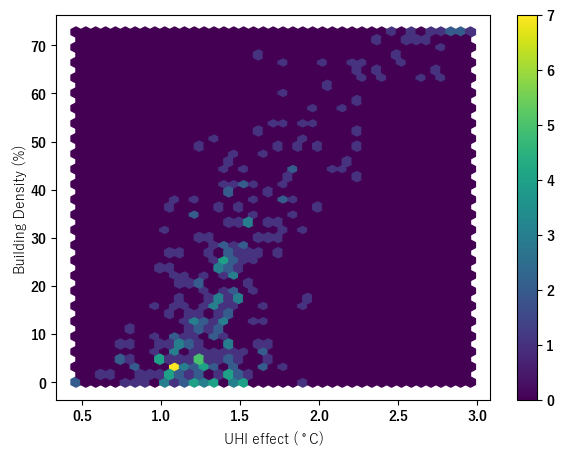

In [17]:
input_raster= r"C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\esri_dynamic_world_cover_projected.tif"
input_raster_uhi_night_p= r"C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326.tif"
input_shapefile= hexbins_projected

merge_df , class_labels= get_zonals(input_raster, input_raster_uhi_night_p, input_shapefile)
x='mean_y'
y="Building Density(%)"
building_density= building_density_versus_uhi(merge_df, x, y, maps)

class_lc, class_color: Water , blue
slope, intercept: -70.85835738441828, 615.8034169420903


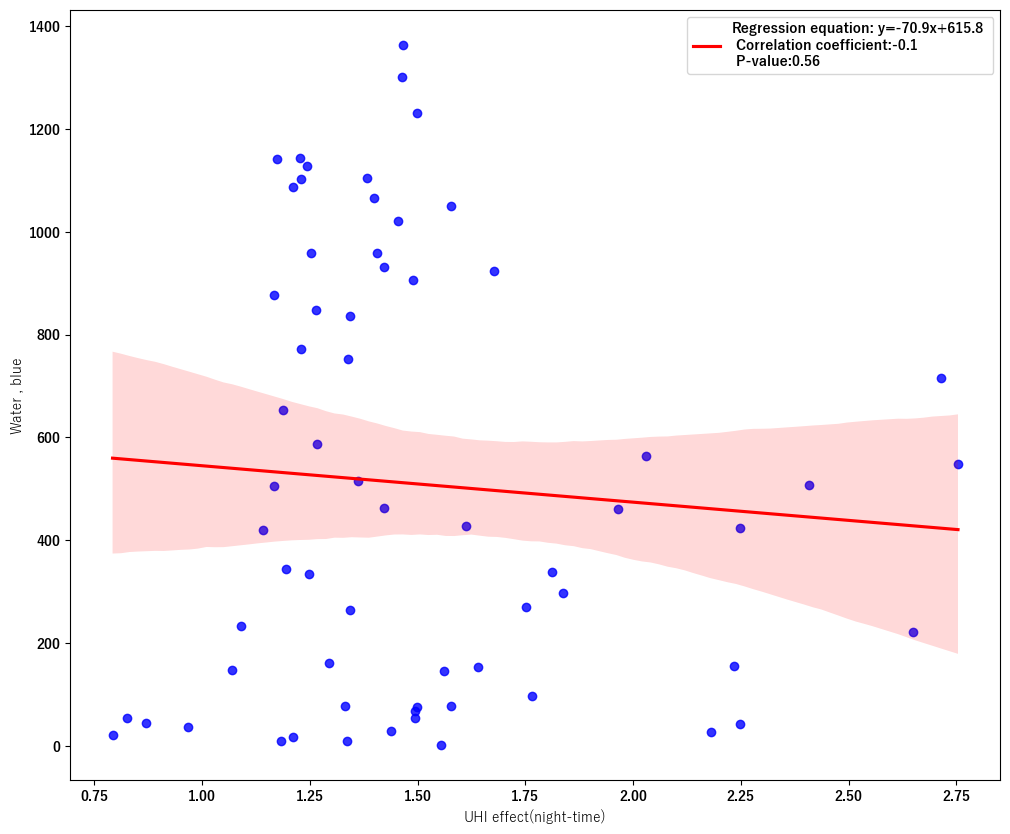

class_lc, class_color: Trees, green
slope, intercept: 521.0149659384494, 4416.41153617781


<Figure size 1200x1000 with 0 Axes>

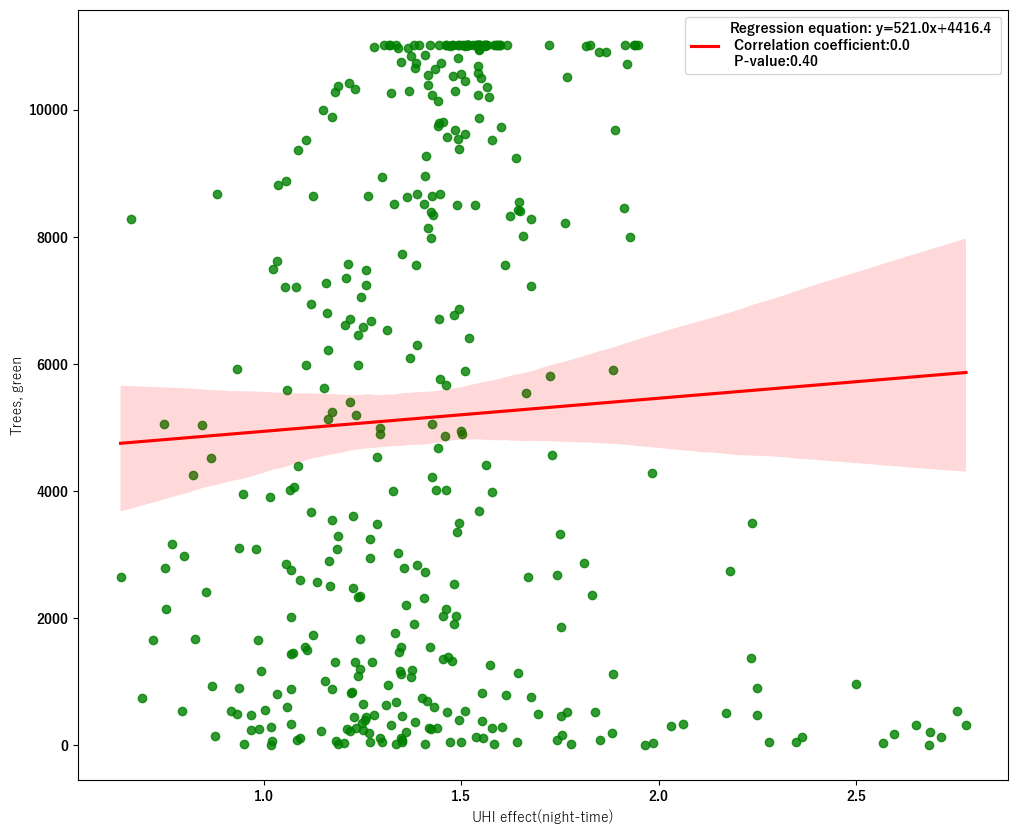

class_lc, class_color: Flooded Vegetation, magenta
class_lc, class_color: Crops, seagreen
slope, intercept: -4788.2295125293085, 11200.902518887444


<Figure size 1200x1000 with 0 Axes>

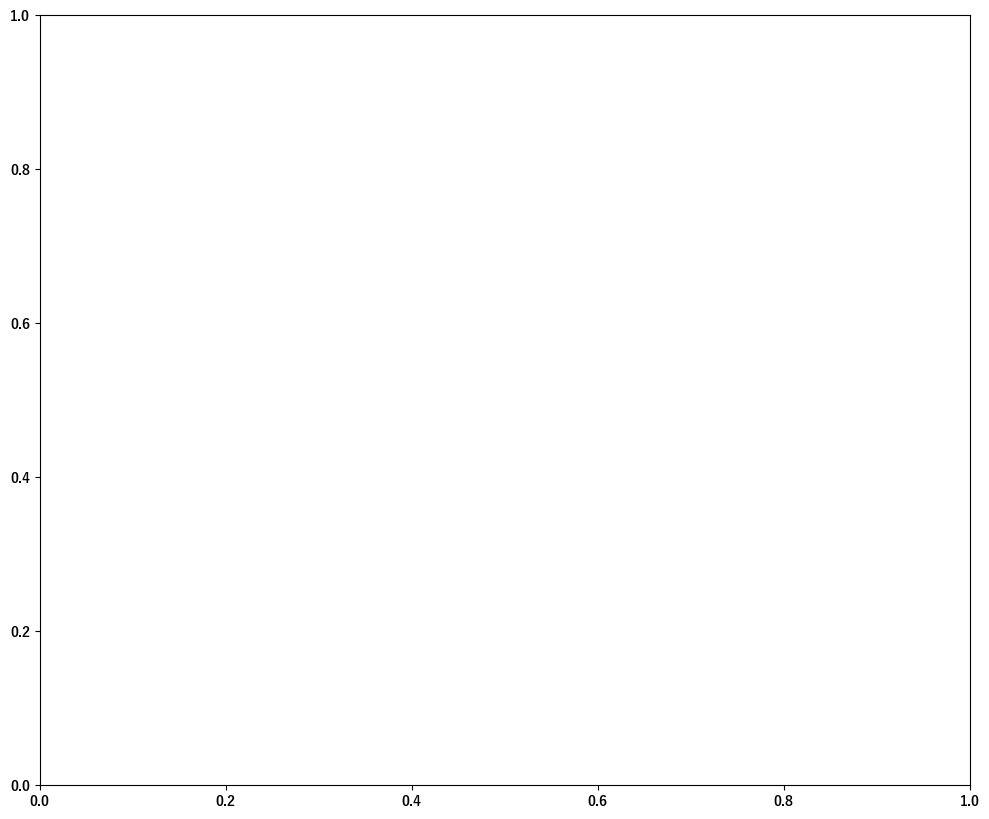

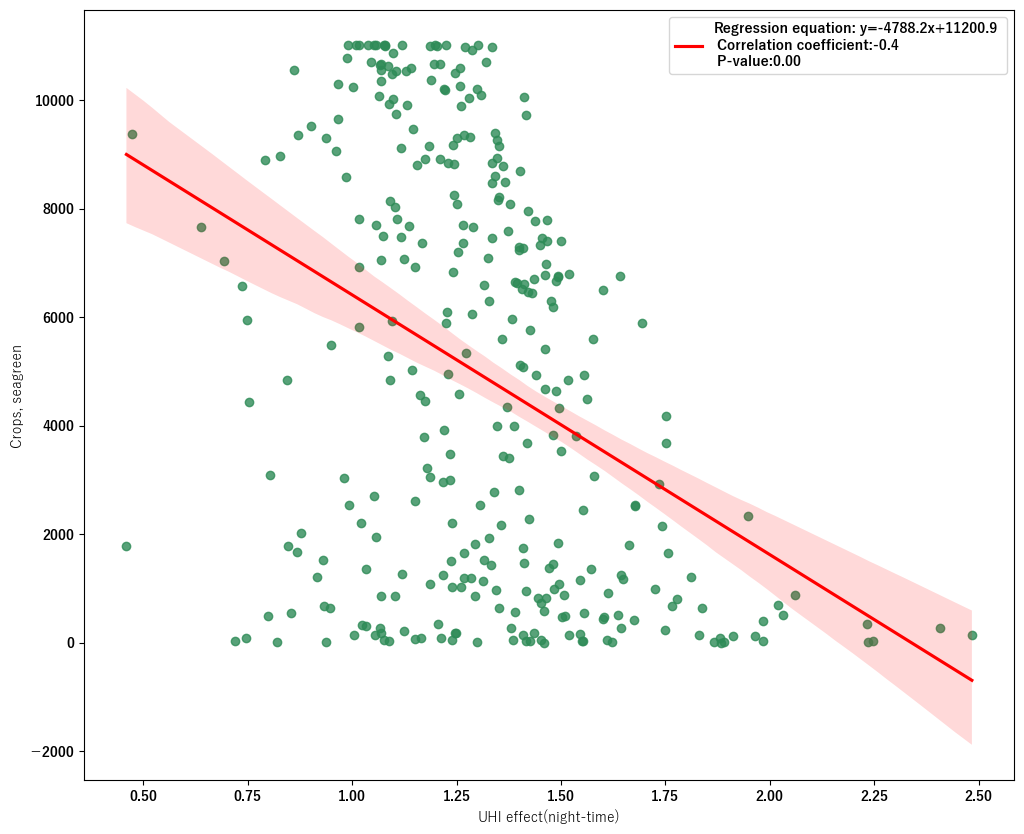

class_lc, class_color: Built Area, tan
slope, intercept: 5694.112846504004, -4987.64471381761


<Figure size 1200x1000 with 0 Axes>

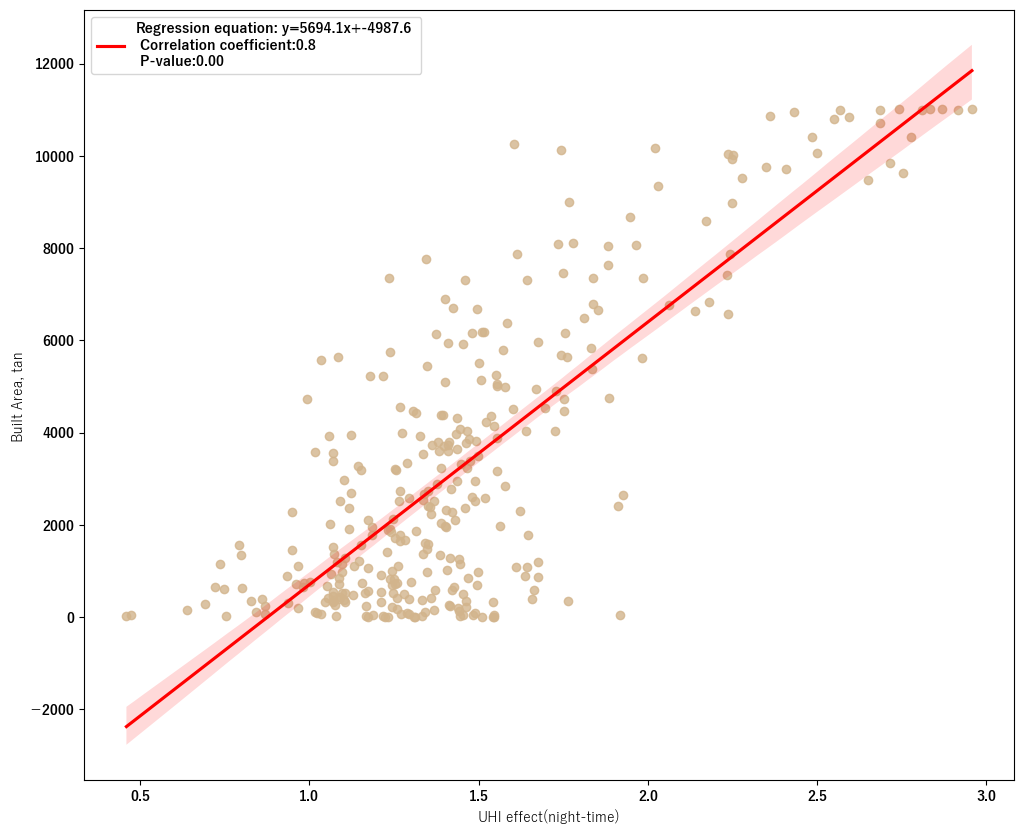

class_lc, class_color: Bare Ground, goldenrod
slope, intercept: 22.32833186833574, 104.99138661328412


<Figure size 1200x1000 with 0 Axes>

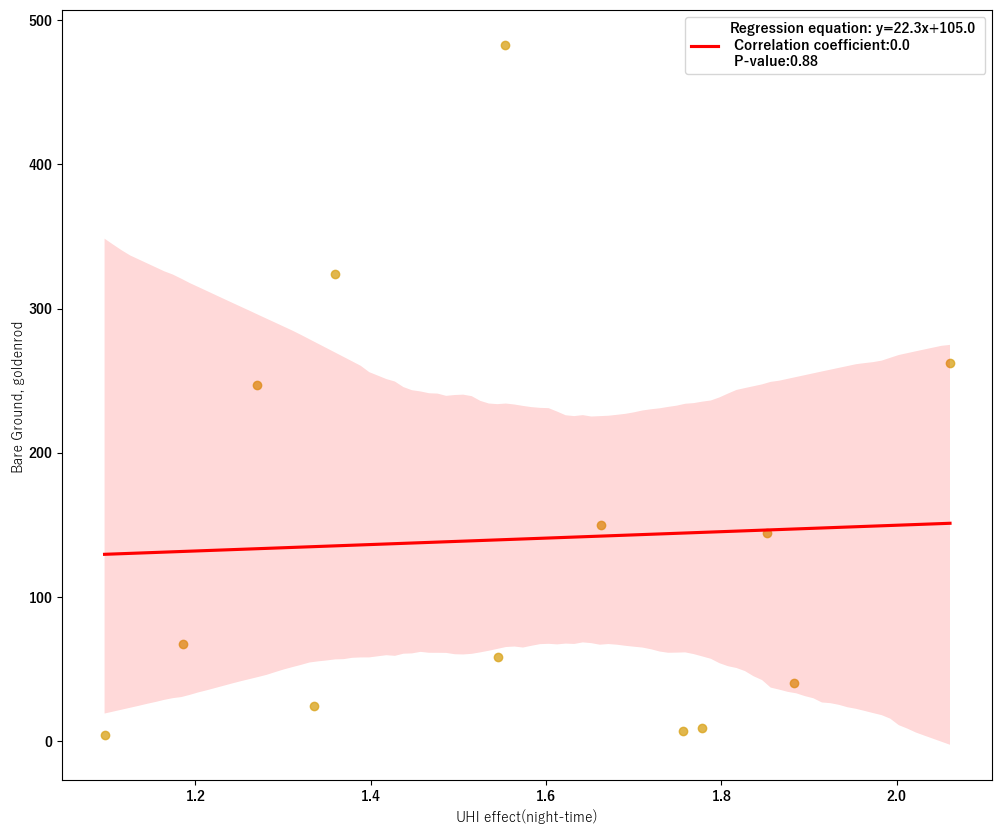

c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


class_lc, class_color: Snow/Ice, snow
slope, intercept: nan, nan


<Figure size 1200x1000 with 0 Axes>

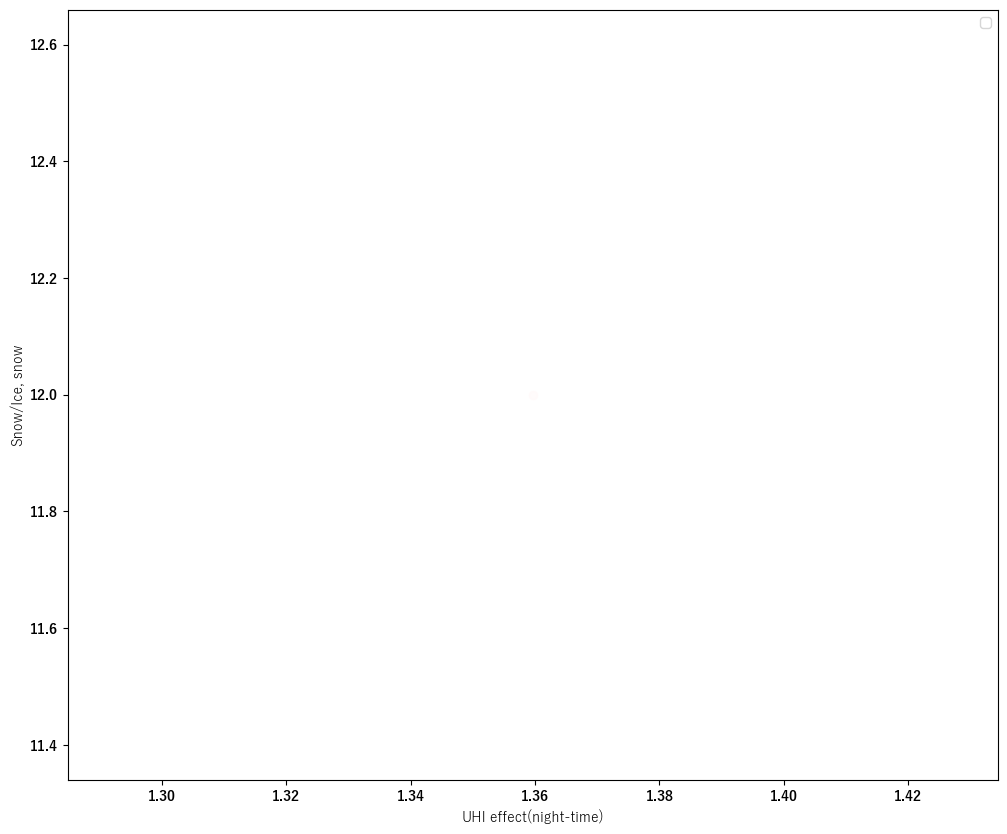

class_lc, class_color: Clouds, ghostwhite
class_lc, class_color: Rangeland, greenyellow
slope, intercept: -2049.5981517385767, 5050.716396658343


<Figure size 1200x1000 with 0 Axes>

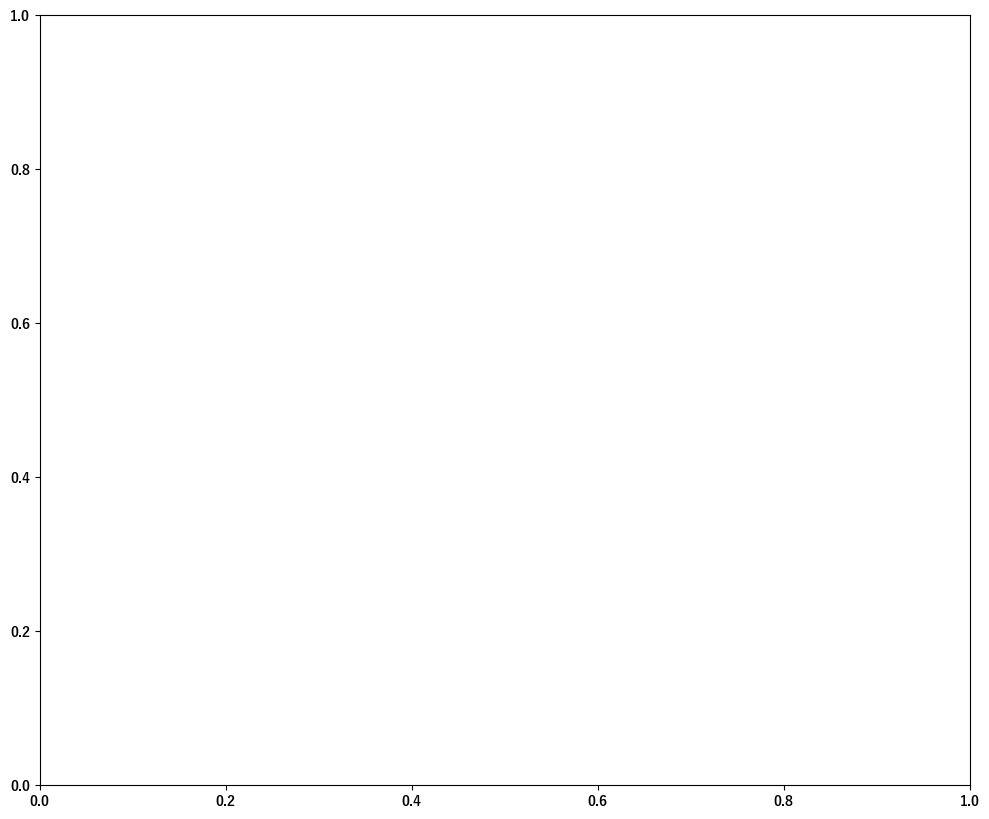

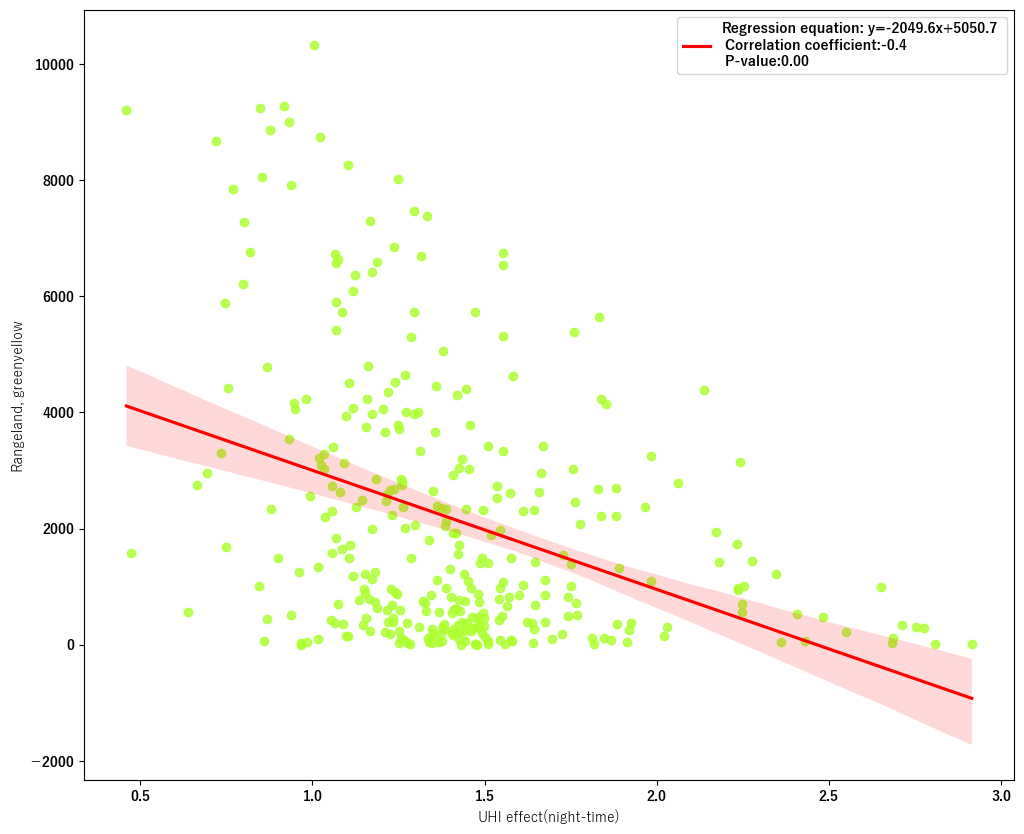

slope, intercept , r_value, p_value, std_err: 37.59788119344456, -32.93470603296545, 0.7948629220954039, 7.669245162804556e-72, 1.5994877631900215


<Figure size 1200x1000 with 0 Axes>

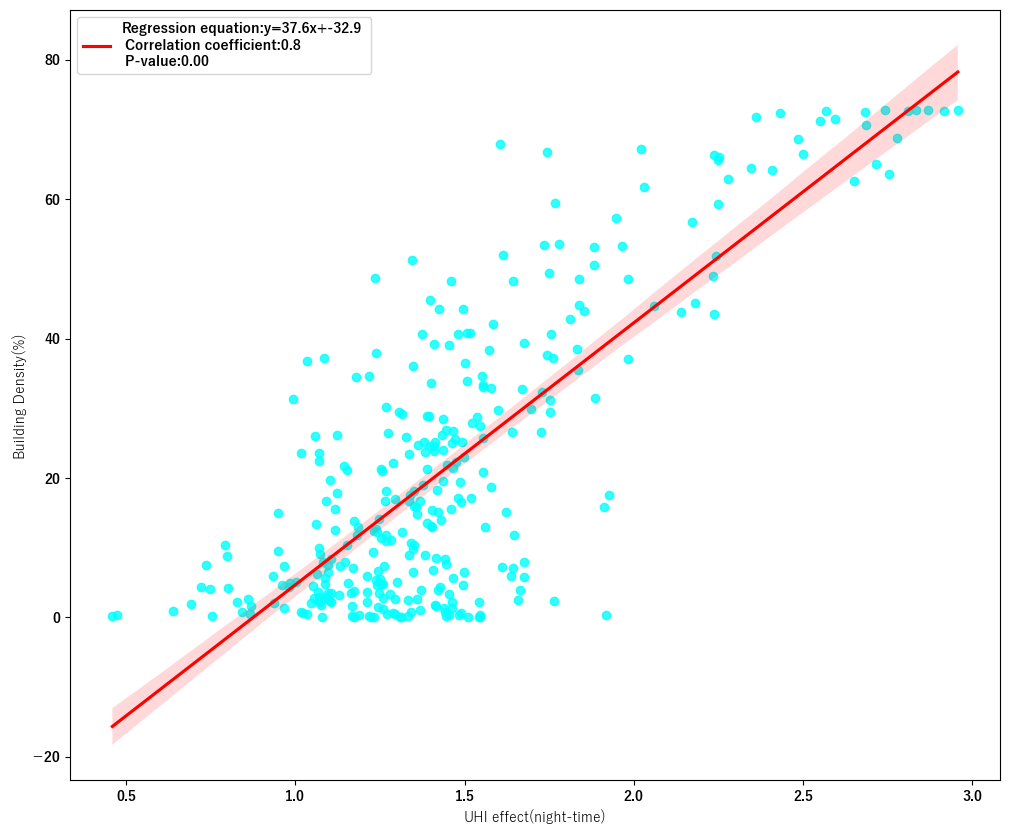

<Figure size 1200x1000 with 0 Axes>

In [18]:
def create_regplots(merge_df, class_labels,maps):
    x="UHI effect(night-time)"
    merge_df[x]= merge_df['mean_y']
    for key, value in class_labels.items():
        class_lc= value.split(', ')[0]
        class_color= value.split(', ')[1]
        print(f"class_lc, class_color: {class_lc}, {class_color}")
        column=class_lc+', '+class_color
        y=column
        try:
            fig, ax = plt.subplots()
            filtered_df = merge_df[merge_df[[ x, y]].notnull().all(1)]
            slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x=filtered_df[x],y=filtered_df[y])
            print(f"slope, intercept: {slope}, {intercept}")
            # use line_kws to set line label for legend
            sn.regplot(x=x, y=y, data=merge_df, ci = 95, color=class_color, line_kws={'color': "r", 'label':"Regression equation: y={0:.1f}x+{1:.1f} \n Correlation coefficient:{2:.1f} \n P-value:{3:.2f}".format(slope,intercept,r_value, p_value )})
            plt.legend(loc='best', markerscale=5)
            plt.show()
            plt.tight_layout()
            map_output= os.path.join(maps, f"{city}_regression_{y}_{x}.png")
            ax.figure.savefig(map_output,  bbox_inches='tight',   dpi = 400)
        except:
            pass

    y="Building Density(%)"
    try:
        fig, ax = plt.subplots()
        filtered_df = merge_df[merge_df[[x, y]].notnull().all(1)]
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x=filtered_df[x],y=filtered_df[y])
        print(f"slope, intercept , r_value, p_value, std_err: {slope}, {intercept}, {r_value}, {p_value}, {std_err}")
        # use line_kws to set line label for legend
        class_color='cyan'
        sn.regplot(x=x, y=y, data=merge_df, ci = 95, color=class_color, line_kws={'color':"r",'label':"Regression equation:y={0:.1f}x+{1:.1f} \n Correlation coefficient:{2:.1f} \n P-value:{3:.2f}".format(slope,intercept,r_value, p_value )})
        plt.legend(loc='best', markerscale=5)
        plt.show()
        plt.tight_layout()
        map_output= os.path.join(maps, f"{city}_regression_{y}_{x}.png")
        ax.figure.savefig(map_output,  bbox_inches='tight',   dpi = 400)
    except:
        pass
create_regplots(merge_df, class_labels,maps)


Sub-city barplot and map. Create separate and then juxtapose.

In [19]:
def sub_city_night_temperature(gdf, sub_city_names_column, visualize_column, cmap,xlabel,ylabel,title,colorbar_title):
    vmin = gdf[visualize_column].min()
    vmax = gdf[visualize_column].max()
    diff=vmax-vmin
    print(f"vmin {vmin}, vmax {vmax} , diff:{diff}")   
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width/2, height/2))  
    ax=gdf.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    gdf['name_clean'] =gdf[sub_city_names_column]               
    gdf= gdf.replace('nan', np.nan) #.dropna(how='all', axis=1, inplace=True)
    label = gdf.dropna(subset='name_clean')
    texts = []
    for i, row in label.iterrows(): 
            texts.append(ax.annotate(text=str(row['name_clean']), 
                                        xy=row.geometry.centroid.coords[0],  weight='bold', color="black", 
                                        ha='center', fontsize=5,  path_effects=[pe.withStroke(linewidth=1.5, 
                                                                                            foreground="white")]))
            
            
    # sub_city_names_column
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(title, fontsize=12,  fontweight='bold')
    fig = ax.get_figure()
    cax = fig.add_axes([.9, .15, 0.02, 0.75]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    CB=fig.colorbar(sm, cax=cax,  label=colorbar_title, orientation='vertical' , shrink=0.8)
    plt.show()
    plt.tight_layout()
    sub_city_names_column_clean=sub_city_names_column.replace(":","_")
    map_output= f'{maps}/{city}_{visualize_column}_{sub_city_names_column_clean}_subcity_heatmap.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

    # barplot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width/(2*1.3), height/(2)*1.3))
    y=sub_city_names_column
    x=visualize_column
    # Filter nans
    gdf = gdf[gdf[[y, x]].notnull().all(1)]
    # Sort the table
    gdf = gdf.sort_values(by=[x])
    y=gdf[y]
    x=gdf[x]
    ax=sn.barplot(data=gdf , orient='h',  x=x, y=y ,  palette=cmap,  ax=ax)  #order=y, orient='h',
    # plt.yticks(rotation=90)
    ax.set_ylabel(ylabel,  fontsize=10,  fontweight='bold')
    ax.set_xlabel(xlabel,  fontsize=10,  fontweight='bold')
    ax.set_title(title ,  fontsize=12,  fontweight='bold')
    plt.yticks(fontsize=5.5,  fontweight='bold') 
    plt.xticks(fontsize=7,  fontweight='bold') 
    plt.setp(ax.get_yticklabels(), rotation=20, horizontalalignment='right',  fontweight='bold')
    # ax.invert_yaxis()  # labels read top-to-bottom
    plt.show()
    plt.tight_layout()
    map_output= f'{maps}/{city}_{visualize_column}_{sub_city_names_column_clean}_subcity_barplot.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400, pad_inches=0)


<>:54: DeprecationWarning: invalid escape sequence \c
<>:90: DeprecationWarning: invalid escape sequence \c
<>:54: DeprecationWarning: invalid escape sequence \c
<>:90: DeprecationWarning: invalid escape sequence \c
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3906985613.py:54: DeprecationWarning: invalid escape sequence \c
  colorbar_title="($^\circ$C)"
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3906985613.py:90: DeprecationWarning: invalid escape sequence \c
  colorbar_title="($^\circ$C)"
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:21: DeprecationWarning: 'raster_stats' is an alias to 'zonal_stats' and will disappear in 1.0
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:152: DeprecationWarning: Use `geojson_out` to preserve feature properties
  warnings.warn(


T2M DJF UHI night present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326.tif


c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:21: DeprecationWarning: 'raster_stats' is an alias to 'zonal_stats' and will disappear in 1.0
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:152: DeprecationWarning: Use `geojson_out` to preserve feature properties
  warnings.warn(


vmin 1.3027493587602854, vmax 2.2279381630685777 , diff:0.9251888043082923


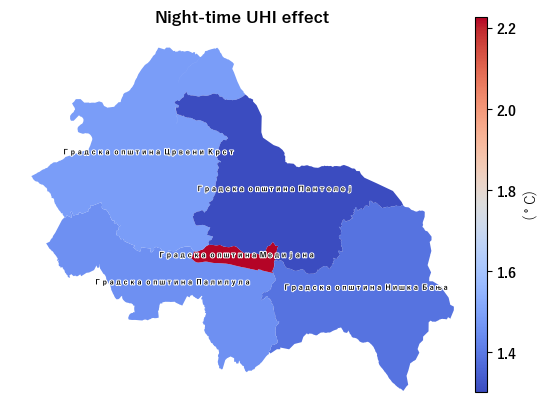

<Figure size 1200x1000 with 0 Axes>

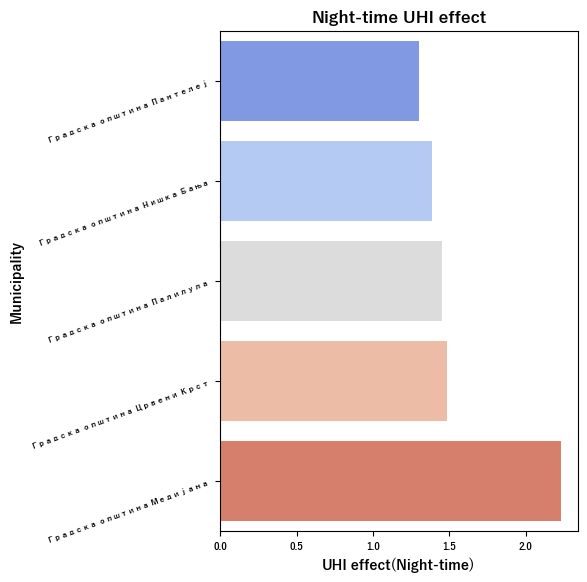

vmin 0.7045671145121256, vmax 2.502840596380768 , diff:1.7982734818686423


<Figure size 1200x1000 with 0 Axes>

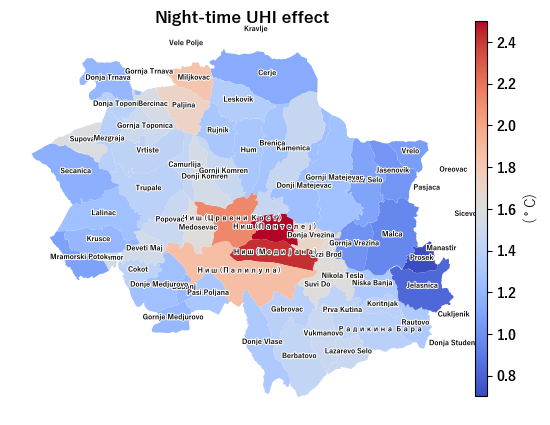

<Figure size 1200x1000 with 0 Axes>

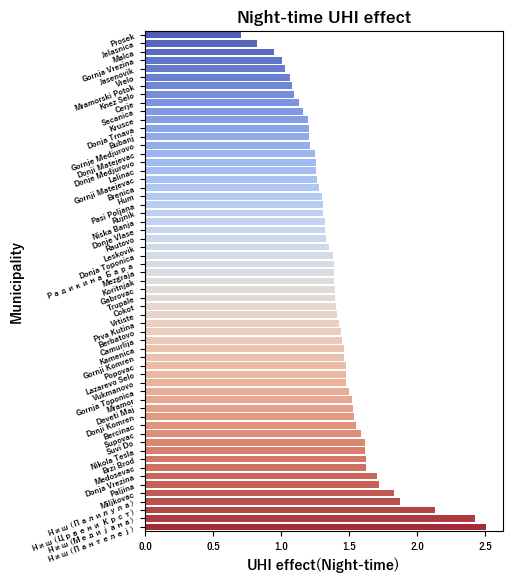

c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:21: DeprecationWarning: 'raster_stats' is an alias to 'zonal_stats' and will disappear in 1.0
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:152: DeprecationWarning: Use `geojson_out` to preserve feature properties
  warnings.warn(


vmin 27.25612677034157, vmax 39.635722600286535 , diff:12.379595829944964


<Figure size 1200x1000 with 0 Axes>

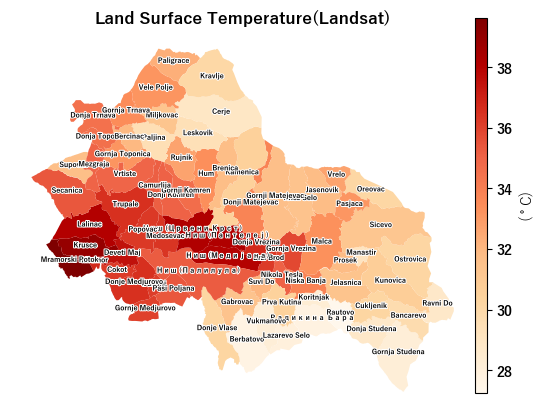

<Figure size 1200x1000 with 0 Axes>

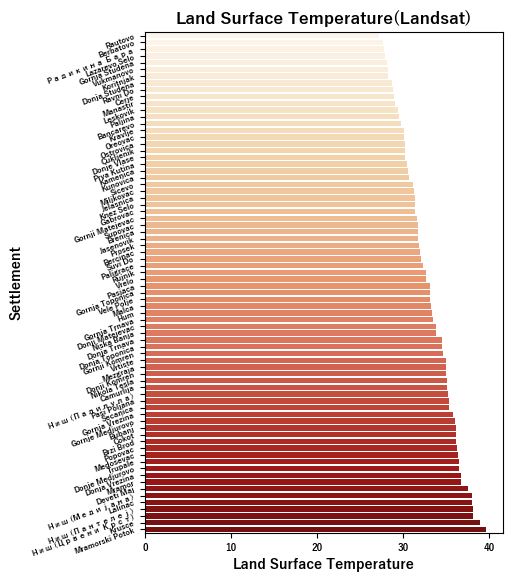

c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:21: DeprecationWarning: 'raster_stats' is an alias to 'zonal_stats' and will disappear in 1.0
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:152: DeprecationWarning: Use `geojson_out` to preserve feature properties
  warnings.warn(


vmin 401.0, vmax 215103.0 , diff:214702.0


<Figure size 1200x1000 with 0 Axes>

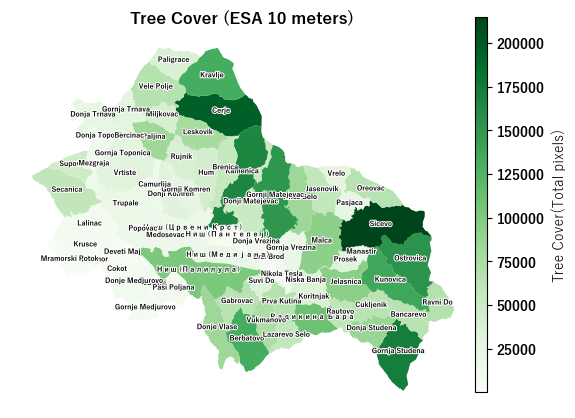

<Figure size 1200x1000 with 0 Axes>

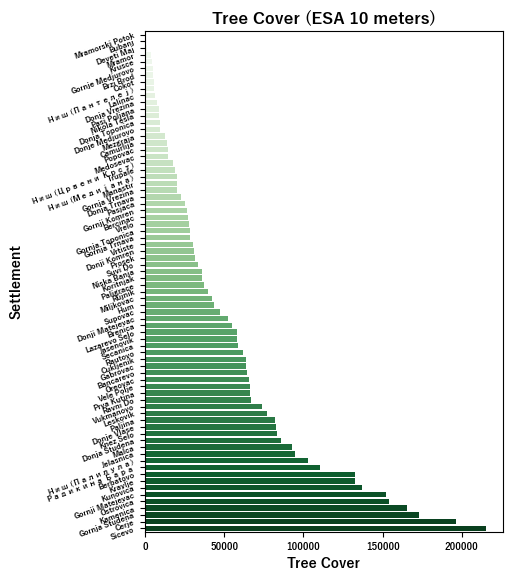

vmin 5.919992834286191, vmax 1088.445715498352 , diff:1082.5257226640658


<Figure size 1200x1000 with 0 Axes>

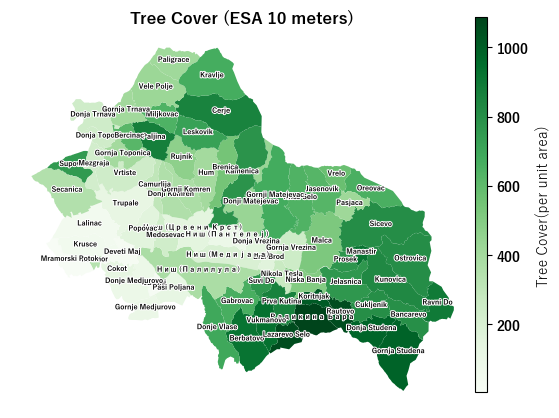

<Figure size 1200x1000 with 0 Axes>

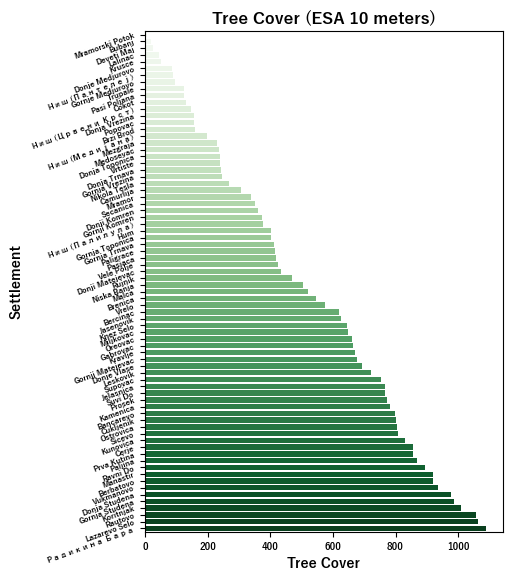

c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:21: DeprecationWarning: 'raster_stats' is an alias to 'zonal_stats' and will disappear in 1.0
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:152: DeprecationWarning: Use `geojson_out` to preserve feature properties
  warnings.warn(


vmin 4.190639759553457, vmax 51.05942793668425 , diff:46.868788177130796


<Figure size 1200x1000 with 0 Axes>

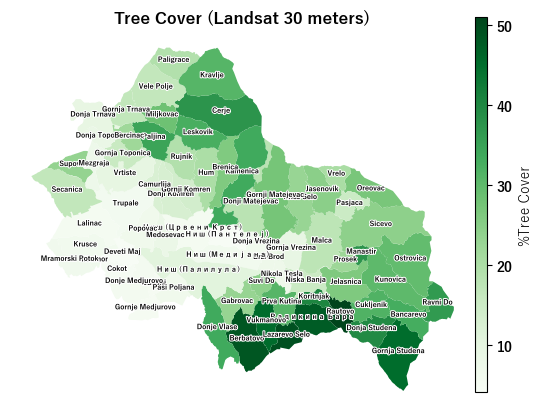

<Figure size 1200x1000 with 0 Axes>

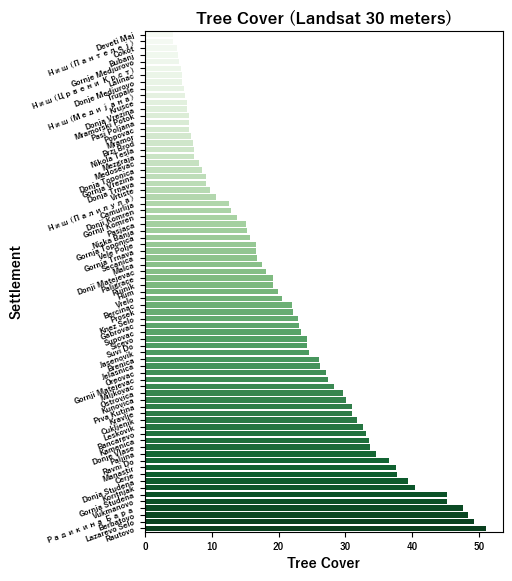

c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:21: DeprecationWarning: 'raster_stats' is an alias to 'zonal_stats' and will disappear in 1.0
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\main.py:152: DeprecationWarning: Use `geojson_out` to preserve feature properties
  warnings.warn(


vmin 2.4208498001098633, vmax 72028.578125 , diff:72026.15727519989


<Figure size 1200x1000 with 0 Axes>

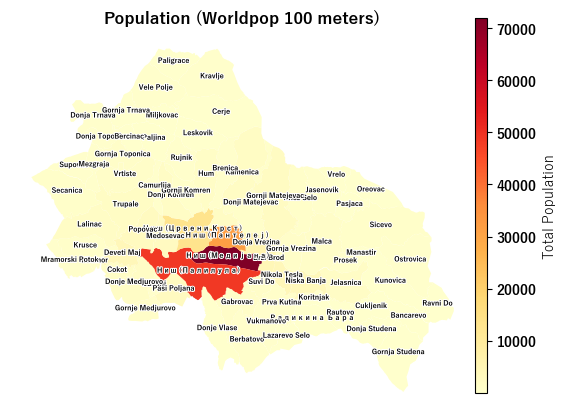

<Figure size 1200x1000 with 0 Axes>

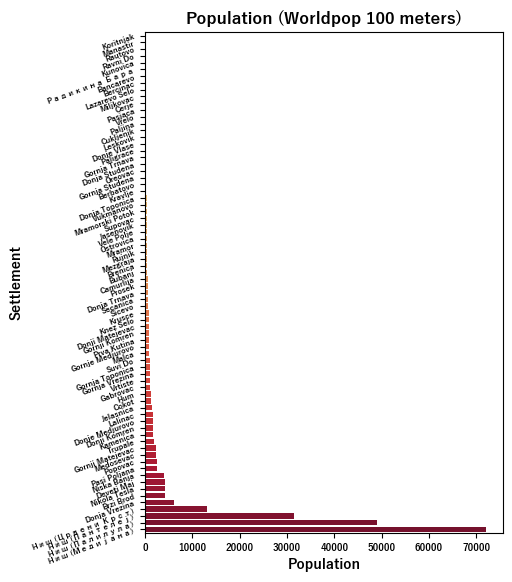

<Figure size 1200x1000 with 0 Axes>

In [20]:
if __name__ ==  '__main__': 
    input_raster_dir = data
    extension = '.tif'
    for root, dirs_list, files_list in os.walk( input_raster_dir):
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension and "T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)
                
                stats="mean"
                sub_city_gdf_uhi=sub_city_gdf.reset_index()
                sub_city_gdf_uhi['admin_level_index']=sub_city_gdf_uhi.index
                zonal_stats_uhi_night_temperature= raster_stats(sub_city_gdf_uhi, 
                    projected_raster, 
                    # stats="mean sum count majority minority unique",
                    stats=stats,
                    copy_properties=True,
                    nodata_value=0,
                    categorical=False
                    )
                
                zonal_stats_uhi_night_temperature = pd.DataFrame(zonal_stats_uhi_night_temperature)
                sub_city_gdf_uhi['uhi_temp_mean']=zonal_stats_uhi_night_temperature[stats]
                sub_city_gdf_uhi['index_joined']=zonal_stats_uhi_night_temperature.index
                sub_city_gdf_stats_for_regression=sub_city_gdf_uhi.copy()

                # Admin third most frequest
                sub_city_gdf_uhi_1=sub_city_gdf_1.reset_index()
                sub_city_gdf_uhi_1['admin_level_index']=sub_city_gdf_uhi_1.index
                zonal_stats_uhi_night_temperature= raster_stats(sub_city_gdf_uhi_1, 
                    projected_raster, 
                    # stats="mean sum count majority minority unique",
                    stats=stats,
                    copy_properties=True,
                    nodata_value=0,
                    categorical=False
                    )
                zonal_stats_uhi_night_temperature = pd.DataFrame(zonal_stats_uhi_night_temperature)
                sub_city_gdf_uhi_1['uhi_temp_mean']=zonal_stats_uhi_night_temperature[stats]
                sub_city_gdf_uhi_1['index_joined']=zonal_stats_uhi_night_temperature.index

                cmap = "coolwarm"
                visualize_column='uhi_temp_mean'
                xlabel='UHI effect(Night-time)'
                ylabel=f'{second_third_frequent_admin_name}'
                title= 'Night-time UHI effect'
                colorbar_title="($^\circ$C)"
                sub_city_names_column='name'
                cmap,xlabel,ylabel,title,colorbar_title
                sub_city_night_temperature(gdf=sub_city_gdf_uhi_1 , sub_city_names_column=sub_city_names_column,
                                            visualize_column=visualize_column, cmap =cmap,
                                            xlabel=xlabel, ylabel=ylabel,title=title,colorbar_title=colorbar_title)
                sub_city_names_column='name:en'
                sub_city_night_temperature(gdf=sub_city_gdf_uhi , sub_city_names_column=sub_city_names_column,
                                            visualize_column=visualize_column, cmap =cmap,
                                            xlabel=xlabel, ylabel=ylabel,title=title,colorbar_title=colorbar_title)

                # Turn to LST 
                raster_filename= "land_surface_temperature"
                projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
                
                sub_city_gdf_stats=sub_city_gdf.reset_index()
                sub_city_gdf_stats['admin_level_index']=sub_city_gdf_stats.index
                zonal_stats_df= raster_stats(sub_city_gdf_stats, 
                    projected_raster, 
                    # stats="mean sum count majority minority unique",
                    stats=stats,
                    copy_properties=True,
                    nodata_value=0,
                    categorical=False
                    )
                
                zonal_stats_df = pd.DataFrame(zonal_stats_df)
                sub_city_gdf_stats[raster_filename]=zonal_stats_df[stats]
                sub_city_gdf_stats_for_regression[raster_filename]=zonal_stats_df[stats]

                title= "Land Surface Temperature"
                cmap = "OrRd"
                visualize_column=raster_filename
                xlabel="Land Surface Temperature"
                ylabel=f'{lowest_admin_level_name}'
                title= "Land Surface Temperature(Landsat)"
                colorbar_title="($^\circ$C)"

                sub_city_names_column='name:en'
                sub_city_night_temperature(gdf=sub_city_gdf_stats , sub_city_names_column=sub_city_names_column,
                                            visualize_column=visualize_column, cmap =cmap,
                                            xlabel=xlabel, ylabel=ylabel,title=title,colorbar_title=colorbar_title)


                # Turn to pop and tree cover 
                stats="sum"
                raster_filename= "esa_tree_cover"
                projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
                sub_city_gdf_stats=sub_city_gdf.reset_index()
                sub_city_gdf_stats['admin_level_index']=sub_city_gdf_stats.index
                zonal_stats_df= raster_stats(sub_city_gdf_stats, 
                    projected_raster, 
                    # stats="mean sum count majority minority unique",
                    stats=stats,
                    copy_properties=True,
                    nodata_value=0,
                    categorical=False
                    )
                
                zonal_stats_df = pd.DataFrame(zonal_stats_df)
                sub_city_gdf_stats[raster_filename]=zonal_stats_df[stats]
                degrees_into_meters_factor=111319
                sub_city_gdf_stats["Area meters"]=sub_city_gdf_stats["post_clip_area"]*degrees_into_meters_factor
                sub_city_gdf_stats["Tree cover per unit area"]=sub_city_gdf_stats[raster_filename]/sub_city_gdf_stats["Area meters"]
                sub_city_gdf_stats_for_regression[raster_filename]=zonal_stats_df[stats]

                cmap = "Greens"
                visualize_column=raster_filename
                xlabel="Tree Cover"
                title= "Tree Cover (ESA 10 meters)"
                colorbar_title="Tree Cover(Total pixels)"
                sub_city_names_column='name:en'
                sub_city_night_temperature(gdf=sub_city_gdf_stats , sub_city_names_column=sub_city_names_column,
                                            visualize_column=visualize_column, cmap =cmap,
                                            xlabel=xlabel, ylabel=ylabel,title=title,colorbar_title=colorbar_title)

                cmap = "Greens"
                visualize_column="Tree cover per unit area"
                xlabel="Tree Cover"
                title= "Tree Cover (ESA 10 meters)"
                colorbar_title="Tree Cover(per unit area)"
                sub_city_names_column='name:en'
                sub_city_night_temperature(gdf=sub_city_gdf_stats , sub_city_names_column=sub_city_names_column,
                                            visualize_column=visualize_column, cmap =cmap,
                                            xlabel=xlabel, ylabel=ylabel,title=title,colorbar_title=colorbar_title)





                # Turn to Landsat tree cover 
                stats="mean"
                raster_filename= "land_tree"
                projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
                
                sub_city_gdf_stats=sub_city_gdf.reset_index()
                sub_city_gdf_stats['admin_level_index']=sub_city_gdf_stats.index
                zonal_stats_df= raster_stats(sub_city_gdf_stats, 
                    projected_raster, 
                    # stats="mean sum count majority minority unique",
                    stats=stats,
                    copy_properties=True,
                    nodata_value=0,
                    categorical=False
                    )
                
                zonal_stats_df = pd.DataFrame(zonal_stats_df)
                sub_city_gdf_stats[raster_filename]=zonal_stats_df[stats]
                sub_city_gdf_stats_for_regression[raster_filename]=zonal_stats_df[stats]

                visualize_column=raster_filename
                xlabel="Tree Cover"
                title= "Tree Cover (Landsat 30 meters)"
                colorbar_title="%Tree Cover"
                sub_city_names_column='name:en'
                sub_city_night_temperature(gdf=sub_city_gdf_stats , sub_city_names_column=sub_city_names_column,
                                            visualize_column=visualize_column, cmap =cmap,
                                            xlabel=xlabel, ylabel=ylabel,title=title,colorbar_title=colorbar_title)

                # Turn to WorldPop Global Project Population Data: Estimated Residential Population per 100x100m Grid Square
                stats="sum"
                raster_filename= "pop_density"
                projected_raster = os.path.join(rasters, f'{raster_filename}.tif')
                sub_city_gdf_stats=sub_city_gdf.reset_index()
                sub_city_gdf_stats['admin_level_index']=sub_city_gdf_stats.index
                zonal_stats_df= raster_stats(sub_city_gdf_stats, 
                    projected_raster, 
                    # stats="mean sum count majority minority unique",
                    stats=stats,
                    copy_properties=True,
                    nodata_value=0,
                    categorical=False
                    )
                
                zonal_stats_df = pd.DataFrame(zonal_stats_df)
                sub_city_gdf_stats[raster_filename]=zonal_stats_df[stats]
                sub_city_gdf_stats_for_regression[raster_filename]=zonal_stats_df[stats]

                visualize_column=raster_filename
                # cmap = "Reds"
                # cmap = "seismic"
                # cmap = "bwr"
                
                cmap = "Reds"
                cmap="gist_heat"
                cmap="YlOrRd"

                # cmap = truncate_colormap(cmap, 0.2, 1) YlOrRd
                # cmap = truncate_colormap(cmap, 0.3, 1)
                xlabel="Population"
                title= "Population (Worldpop 100 meters)"
                colorbar_title="Total Population"
                sub_city_names_column='name:en'
                sub_city_night_temperature(gdf=sub_city_gdf_stats , sub_city_names_column=sub_city_names_column,
                                            visualize_column=visualize_column, cmap =cmap,
                                            xlabel=xlabel, ylabel=ylabel,title=title,colorbar_title=colorbar_title)



        

                

For Giggles

In [21]:
def create_regplots_for_admin_levels(merge_df, xvars,yvars,maps):
    # y="UHI effect(night-time)"
    # merge_df[y]=merge_df["uhi_temp_mean"]

    for y in yvars:
        for x in xvars:
            print(x, y)
        # try:
            fig, ax = plt.subplots()
            filtered_df = merge_df[merge_df[[ x, y]].notnull().all(1)]
            slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x=filtered_df[x],y=filtered_df[y])
            print(f"slope, intercept: {slope}, {intercept}")
            # use line_kws to set line label for legend
            class_color='cyan'
            sn.regplot(x=x, y=y, data=merge_df, ci = 95, color=class_color, line_kws={'color': "r", 'label':"Regression equation: y={0:.1f}x+{1:.1f} \n Correlation coefficient:{2:.1f} \n P-value:{3:.2f}".format(slope,intercept,r_value, p_value )})
            plt.legend(loc='best', markerscale=5)
            plt.show()
            plt.tight_layout()
            map_output= os.path.join(maps, f"{city}_regression_{y}_{x}.png")
            ax.figure.savefig(map_output,  bbox_inches='tight',   dpi = 400)

    # except:
    #     pass
    return filtered_df, merge_df


esa_tree_cover uhi_temp_mean
slope, intercept: -1.310754625405573e-06, 1.465970100231861


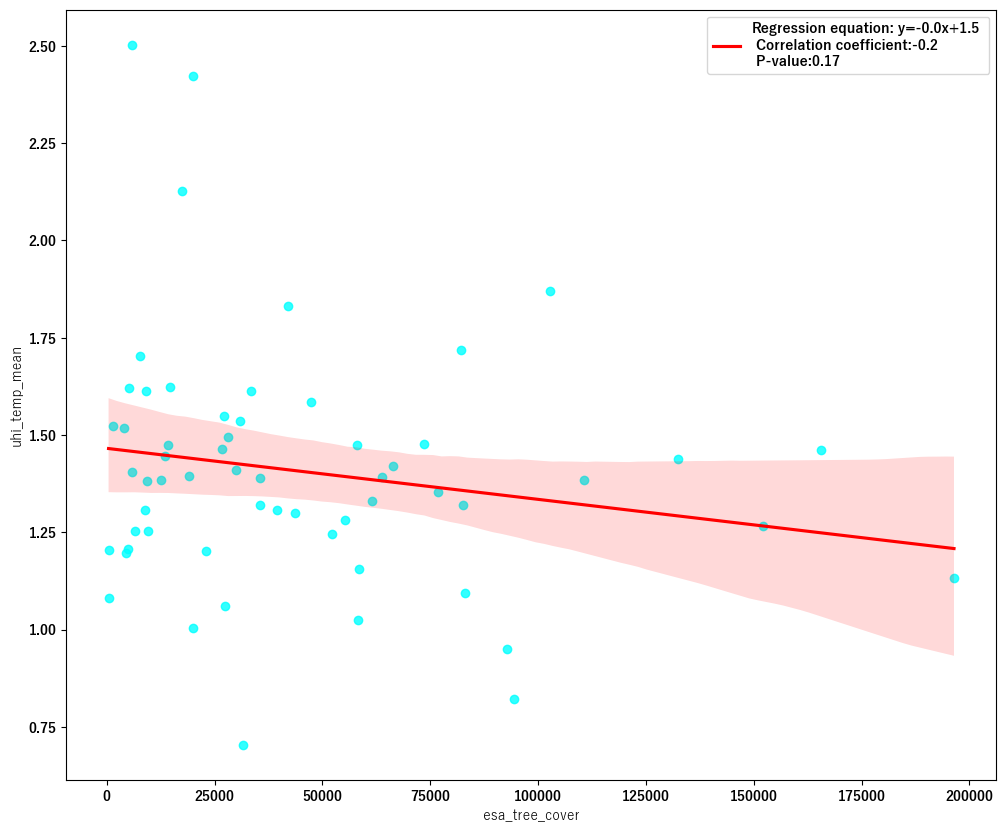

esa_tree_cover uhi_temp_mean
slope, intercept: -1.310754625405573e-06, 1.465970100231861


<Figure size 1200x1000 with 0 Axes>

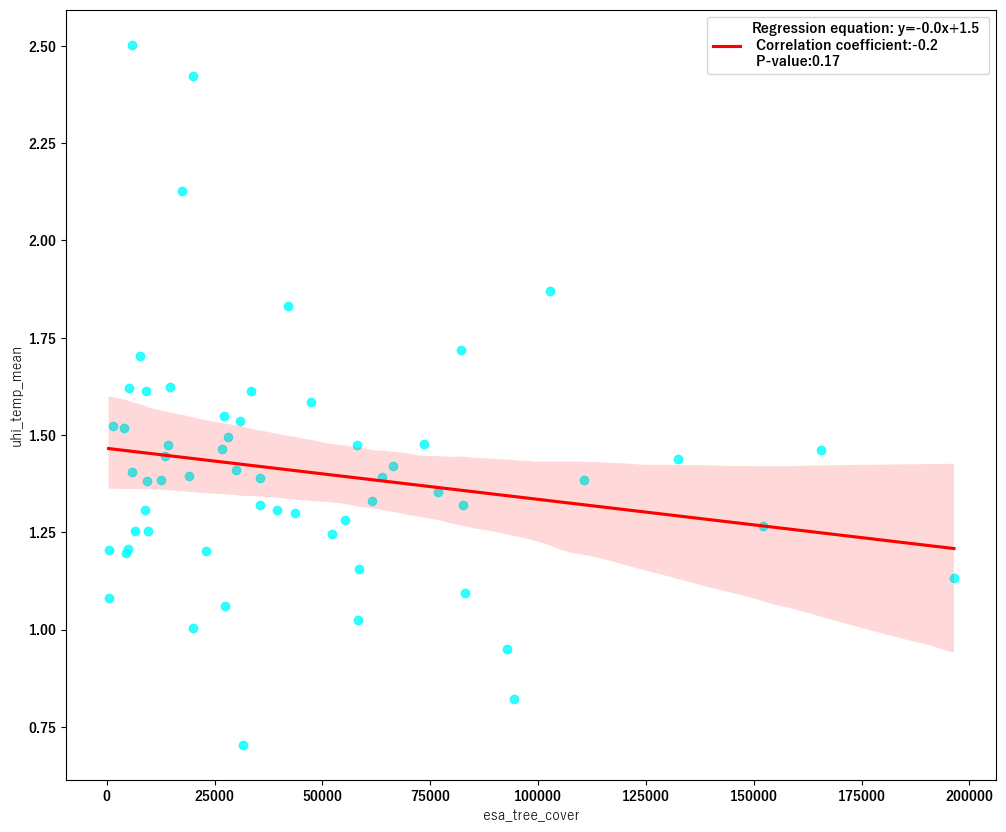

land_tree uhi_temp_mean
slope, intercept: -0.003805760006587547, 1.4786943696384973


<Figure size 1200x1000 with 0 Axes>

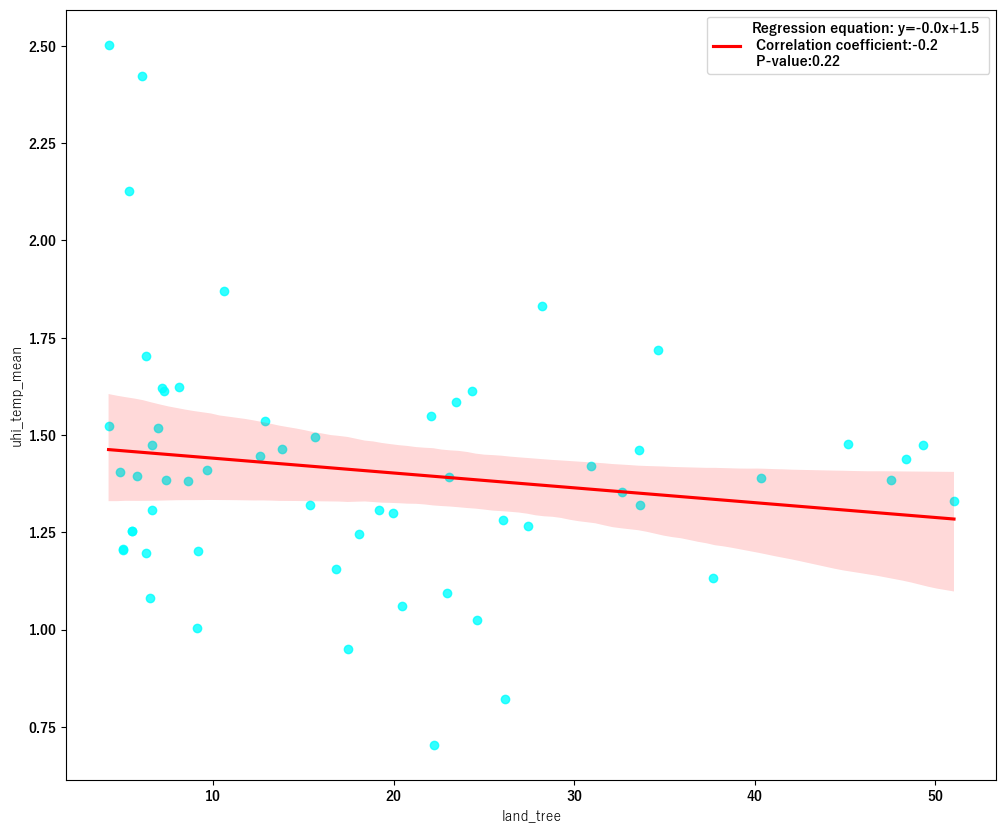

pop_density uhi_temp_mean
slope, intercept: 1.748166926800062e-05, 1.3395307998124364


<Figure size 1200x1000 with 0 Axes>

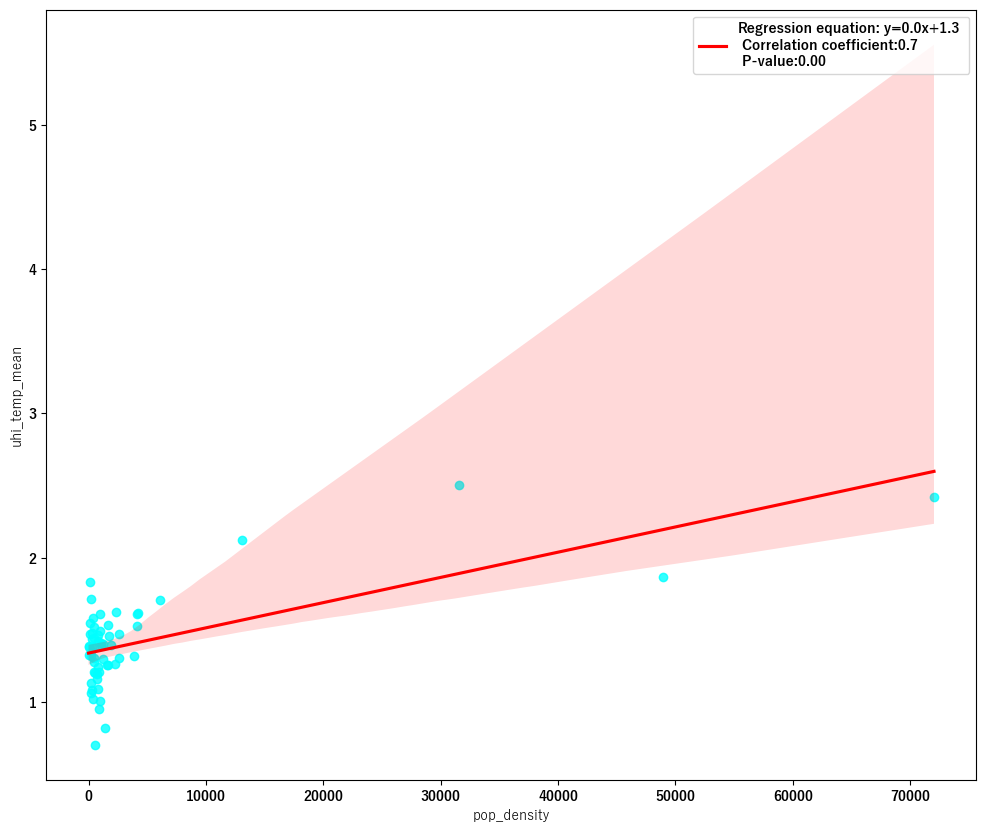

esa_tree_cover land_surface_temperature
slope, intercept: -4.2177349947595945e-05, 35.23681052592033


<Figure size 1200x1000 with 0 Axes>

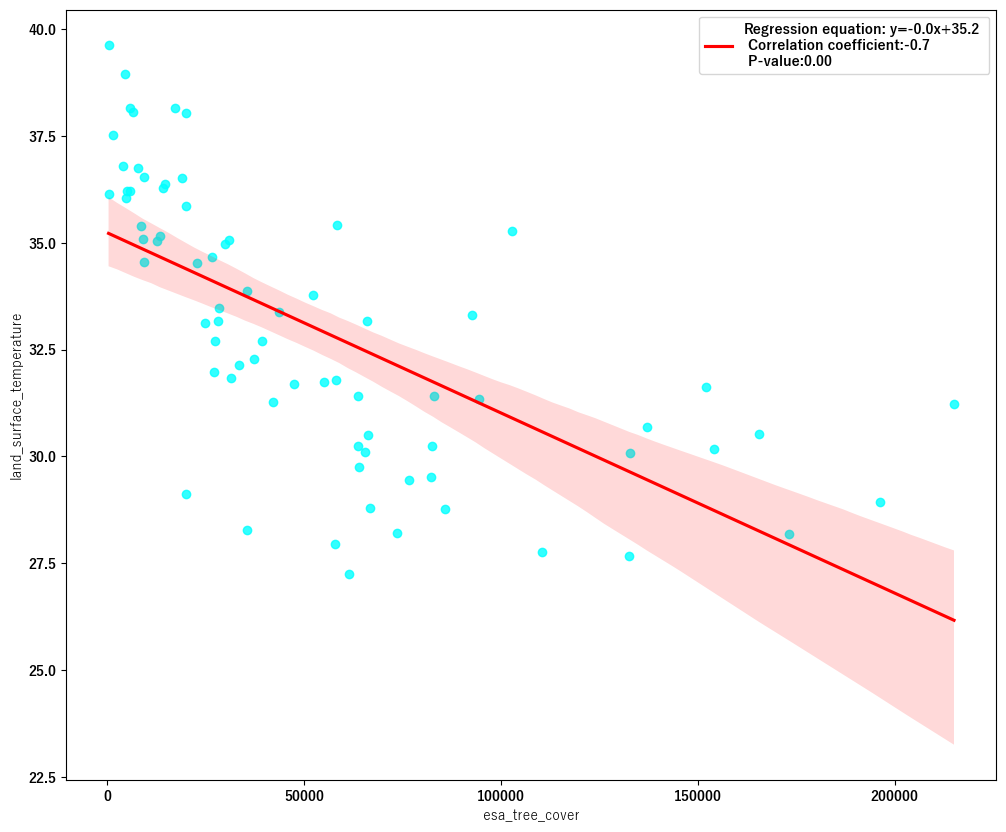

esa_tree_cover land_surface_temperature
slope, intercept: -4.2177349947595945e-05, 35.23681052592033


<Figure size 1200x1000 with 0 Axes>

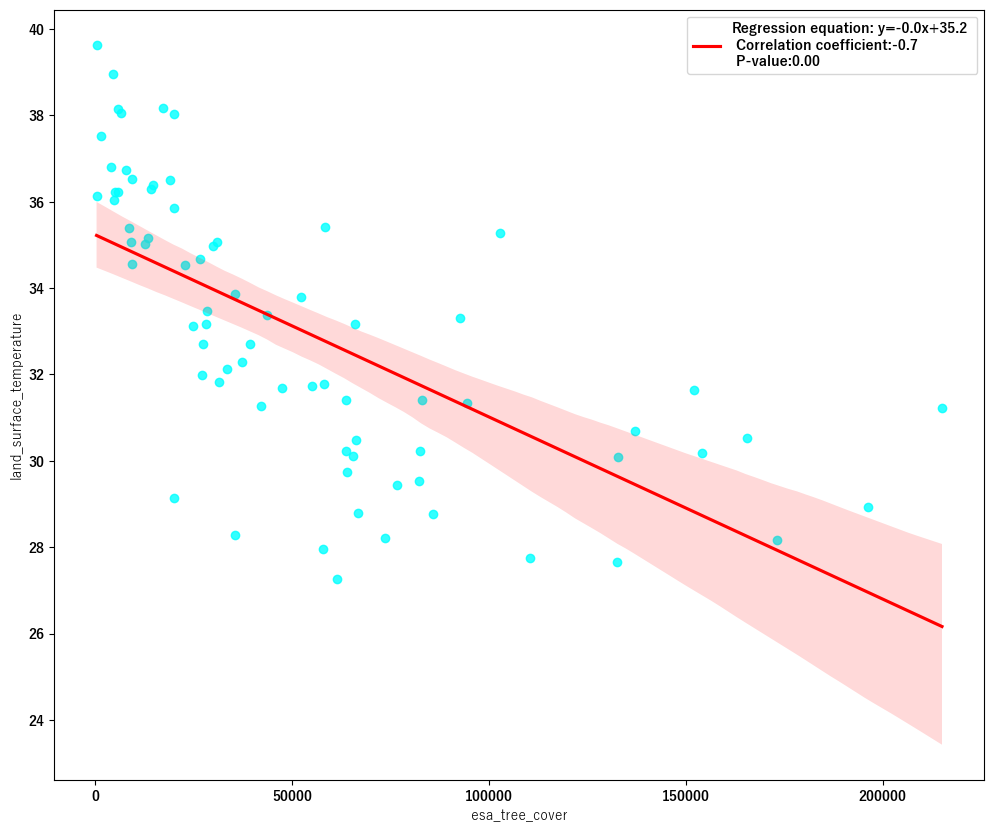

land_tree land_surface_temperature
slope, intercept: -0.23005293341218075, 37.75599489553622


<Figure size 1200x1000 with 0 Axes>

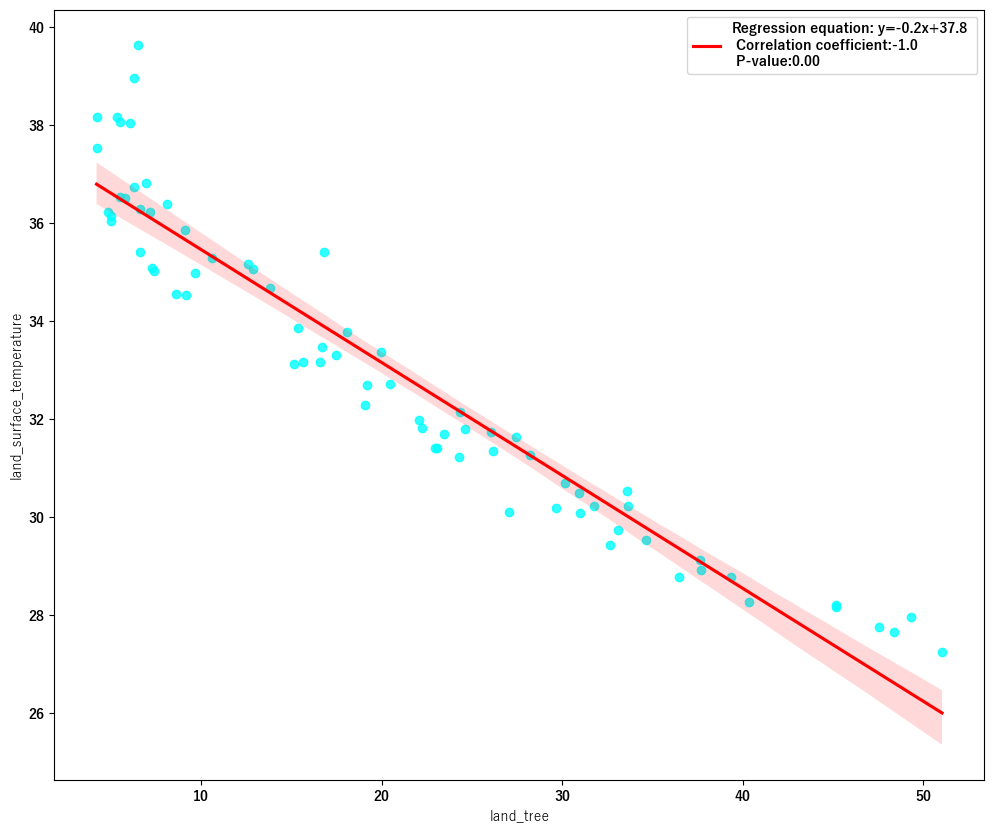

pop_density land_surface_temperature
slope, intercept: 0.00010033142214924399, 32.65783613596258


<Figure size 1200x1000 with 0 Axes>

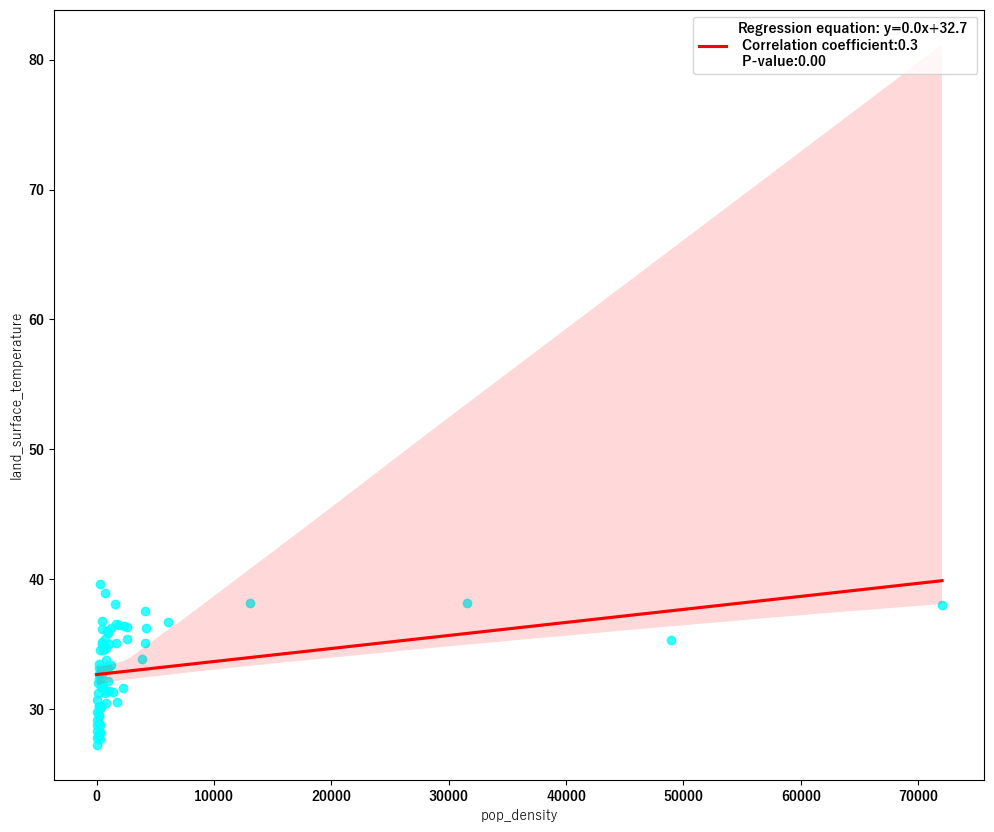

<Figure size 1200x1000 with 0 Axes>

In [22]:
xvars=["esa_tree_cover",	"esa_tree_cover",	"land_tree"	,"pop_density"]
yvars= ["uhi_temp_mean","land_surface_temperature"]

filtered_df, merge_df=create_regplots_for_admin_levels(merge_df=sub_city_gdf_stats_for_regression,xvars=xvars,yvars=yvars,maps=maps)

In [23]:
def map_func_colorbar(vector_file,  hexagons,  crs , cmap, visualize_column, legend_title, map_output):
    fig, ax = plt.subplots(figsize = (width, height))
    vmin = hexagons[visualize_column].min()
    vmax = hexagons[visualize_column].max()
    ax_gpd= hexagons.to_crs(crs).plot(ax=ax,column = visualize_column,edgecolor='none',cmap = cmap,legend = False)
    vector_file.to_crs(crs).plot(ax=ax_gpd,facecolor='none',edgecolor='k',alpha=0.2)
    plt.xticks([], [])
    plt.yticks([], [])
    ax.set_axis_off()
    fig = ax.get_figure()
    cax = fig.add_axes([.95, 0.1, 0.02, 0.8]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    # cax = fig.add_axes([0.2, 0.25, 0.6, 0.02]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    CB=fig.colorbar(sm, cax=cax,  label=legend_title, orientation='vertical' , shrink=0.8)
    CB.ax.tick_params(labelsize=16) 
    plt.tight_layout()
    # map_output= f'{maps}/{city}_{visualize_column}_map_heat_colorbar.png'
    plt.savefig(map_output, format = 'png',bbox_inches='tight')
    plt.show()


def map_func_new(maps, vector_file,  hexagons, legend_title,legends_format, crs ,cmap,  visualize_column, title, scheme, categorical, map_output):
    if categorical==True:
        ax = hexagons.to_crs(crs).plot(figsize=(width, height), \
                                    column= visualize_column, \
                                    alpha=0.6, categorical=True , cmap=cmap, \
                                    legend=True,  # Add legend 
                                    legend_kwds={'loc':'upper right', 
                                                    'bbox_to_anchor':(1, 1), 
                                                    'fmt':legends_format,
                                                    'markerscale':1.01, 
                                                    'title_fontsize':'small', 
                                                    'fontsize':'x-small'
                                                    # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                    } ,
                                    aspect=1
                                            )
    elif categorical==False:
        ax = hexagons.to_crs(crs).plot(figsize=(width, height), \
                                    column= visualize_column, \
                                    alpha=0.6, scheme=scheme, cmap=cmap, \
                                    legend=True,  # Add legend 
                                    legend_kwds={'loc':'upper right', 
                                                    'bbox_to_anchor':(1, 1), 
                                                    'fmt':legends_format,
                                                    'markerscale':1.01, 
                                                    'title_fontsize':'small', 
                                                    'fontsize':'x-small'
                                                    # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                    } ,
                                    aspect=1
                                            )
    # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    # cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,  crs=crs) 
    vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs , zoom=12) 
    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs, zoom=11) # zoom=13
    plt.xticks([])
    plt.yticks([]) 
    leg1 = ax.get_legend()
    # Set markers to square shape
    for ea in leg1.legendHandles:
        ea.set_marker('s')
    leg1.set_title(f'{legend_title}')
    ax.title.set_text(f'{title}')
    plt.tight_layout()
    # ax.figure.savefig(map_output)
    # map_output= f'{maps}/{city}_{visualize_column}_map_heat.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)



Juxtapose day and night. Subtract sum of heatwave nights for pressent from 2050 ad show it as pct change.

In [24]:
if __name__ ==  '__main__': 
    input_raster_dir = data
    extension = '.tif'
    for root, dirs_list, files_list in os.walk( input_raster_dir):
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension and "T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)

                cities_reprojected=gdf_city.reset_index()
                # raster_filename= "heatwave_days_present_2001_2020_30m_EPSG4326"
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)

                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  

                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326_all=polygonized_shapefile
                T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326_newdf=newdf

            elif os.path.splitext(file_name)[-1] == extension and "T2M_DJF_UHI_day_present_2001_2020_30m_EPSG4326" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)

                cities_reprojected=gdf_city.reset_index()
                # raster_filename= "heatwave_days_present_2001_2020_30m_EPSG4326"
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)

                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  

                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                T2M_DJF_UHI_day_present_2001_2020_30m_EPSG4326_EPSG4326_all=polygonized_shapefile
                T2M_DJF_UHI_day_present_2001_2020_30m_EPSG4326_EPSG4326_newdf=newdf




T2M DJF UHI day present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_DJF_UHI_day_present_2001_2020_30m_EPSG4326.tif


T2M DJF UHI night present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326.tif


<>:23: DeprecationWarning: invalid escape sequence \c
<>:40: DeprecationWarning: invalid escape sequence \c
<>:23: DeprecationWarning: invalid escape sequence \c
<>:40: DeprecationWarning: invalid escape sequence \c
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\667731099.py:23: DeprecationWarning: invalid escape sequence \c
  CB=fig.colorbar(sm, cax=cax,  label="($^\circ$C)", orientation='vertical' , shrink=0.8)
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\667731099.py:40: DeprecationWarning: invalid escape sequence \c
  CB=fig.colorbar(sm, cax=cax,  label="($^\circ$C)", orientation='vertical' , shrink=0.8)


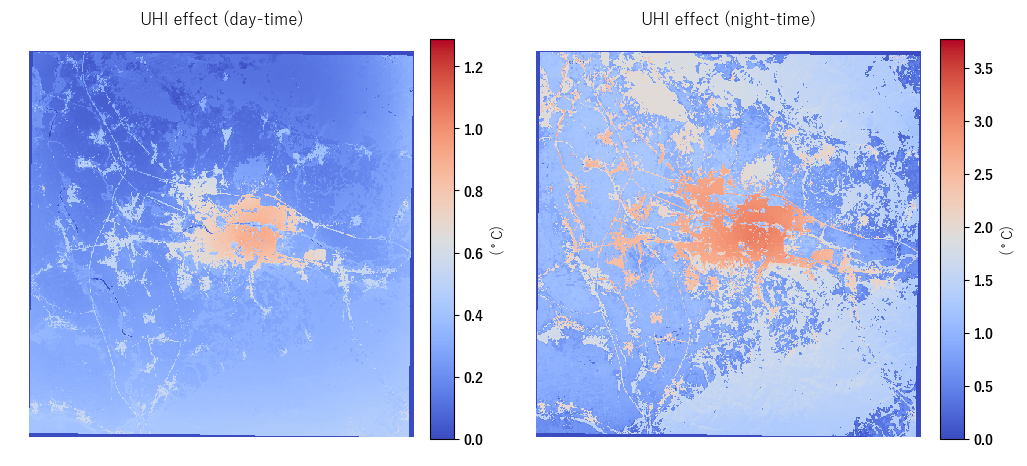

<Figure size 1200x1000 with 0 Axes>

In [25]:
def juxtapose_day_and_night(gdf, gdf_1, visualize_column):
    cmap = "coolwarm"
    vmin = gdf[visualize_column].min()
    vmax = gdf[visualize_column].max()
    # Start a loop over all the variables of interest
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(width, height))
    # Make the axes accessible with single indexing
    axs = axs.flatten()
    i=0
    ax = axs[i]    
    gdp_ax= gdf.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    title="UHI effect (day-time)"
    ax.set_title(title)

    fig = ax.get_figure()
    cax = fig.add_axes([0.475, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    # cax = fig.add_axes([0.2, 0.25, 0.6, 0.02]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    CB=fig.colorbar(sm, cax=cax,  label="($^\circ$C)", orientation='vertical' , shrink=0.8)
    # Display the figure
    vmin = gdf_1[visualize_column].min()
    vmax = gdf_1[visualize_column].max()
    i=1
    ax = axs[i]    
    gdp_ax= gdf_1.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0,legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    title="UHI effect (night-time)"
    ax.set_title(title)
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    CB=fig.colorbar(sm, cax=cax,  label="($^\circ$C)", orientation='vertical' , shrink=0.8)
    # Display the figure
    plt.show()
    plt.tight_layout()
    # ax.figure.savefig(map_output)
    map_output= f'{maps}/{city}_{visualize_column}_day_and_night_juxatposed.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)


juxtapose_day_and_night(gdf=T2M_DJF_UHI_day_present_2001_2020_30m_EPSG4326_EPSG4326_all, gdf_1=T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326_all, visualize_column=raster_val)

In [26]:
def map_profile(maps, vector_file,  hexagons, profile_x_var, legend_title,legends_format, crs ,cmap,  visualize_column, title, map_output, scheme):
    #------------------------------------------------------
    # Centroid for starting the line. use the sample function if needed. 
    cent_x = gdf_city.centroid.x.values[0]  
    cent_y = gdf_city.centroid.y.values[0]  
    # print(cent_x)
    start = Point(cent_x, cent_y)
    length = .05
    angle = math.pi / 2
    end = Point(start.x + length, start.y)
    line = LineString([start, end])
    line = rotate(line, angle, origin=start, use_radians=True)
    # Define a LineString feature geometry with one attribute
    schema = {
        'geometry': 'LineString',
        'properties': {'id': 'int'},
        }
    # Write a new Shapefile
    with fiona.open(f"{shapefiles}/Poly.shp", mode='w', driver='ESRI Shapefile',crs='epsg:4326', schema=schema) as c:
        ## If there are multiple geometries, put the "for" loop here
        c.write({
            'geometry': mapping(line),
            'properties': {'id': 123},
        })

    lines_read= gpd.read_file(f"{shapefiles}/Poly.shp").to_crs(crs)
    newdf = gpd.sjoin(hexagons.to_crs(crs), lines_read)
    for ind, row in lines_read.iterrows():
        XS_ID = row['id']
        start_coords =  list([row.geometry][0].coords)[0]
        end_coords = list([row.geometry][0].coords)[1]
        lon = [start_coords[0]]
        lat = [start_coords[1]]
        n_points = 10
        for i in np.arange(1, n_points+1):
            x_dist = end_coords[0] - start_coords[0]
            y_dist = end_coords[1] - start_coords[1]
            point  = [(start_coords[0] + (x_dist/(n_points+1))*i), (start_coords[1] + (y_dist/(n_points+1))*i)]
            lon.append(point[0])
            lat.append(point[1])
            
        lon.append(end_coords[0])
        lat.append(end_coords[1])
        df = pd.DataFrame({'Latitude': lat, 
                        'Longitude': lon})
        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.crs = {'init': 'epsg:4326'}
        gdf_pcs = gdf.to_crs(epsg = 3857)
        gdf_pcs['h_distance'] = 0
        for index, row in gdf_pcs.iterrows():
            gdf_pcs['h_distance'].loc[index] = gdf_pcs.geometry[0].distance(gdf_pcs.geometry[index])
            
    line_spat_join = gpd.sjoin(hexagons.to_crs(crs), gdf_pcs.to_crs(crs), how="right", predicate='contains')
    fig, ax = plt.subplots(figsize = (3, 2))
    # ax.plot(line_spat_join['h_distance'], line_spat_join[f'{visualize_column}'])
    ax.plot(line_spat_join[profile_x_var], line_spat_join[f'{visualize_column}'])
    ax.set_title(label=f"{legend_title} profile" , fontdict={'fontsize': 10, 'fontweight': 'medium'})
    
    # fig.suptitle(f"{legend_title} profile", fontsize=10)
    plt.xticks(fontsize=8) # rotation=90
    plt.yticks(fontsize=8) 
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    ax.figure.savefig(f'{maps}/profile_{visualize_column}.png',  bbox_inches='tight', dpi=50) #, transparent=True                
    # plt.show()
    
    #------------------------------------------------------------------------
  
    ax = hexagons.to_crs(crs).plot(figsize=(width, height), \
                                column= visualize_column, \
                                alpha=0.6, scheme=scheme, cmap=cmap, \
                                legend=True,  # Add legend 
                                legend_kwds={'loc':'upper right', 
                                                'bbox_to_anchor':(1, 1), 
                                                'fmt':legends_format,
                                                'markerscale':1.01, 
                                                'title_fontsize':'small', 
                                                'fontsize':'x-small'
                                                # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                } ,
                                aspect=1
                                        )
    # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    # cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,  crs=crs) 
    vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    lines_read.to_crs(crs).plot(ax=ax,facecolor='blue',edgecolor='black', linewidth=1 ,alpha=0.9)

    file = f'{maps}/profile_{visualize_column}.png'
    logo = image.imread(file)
    imagebox = OffsetImage(logo)
    #Container for an `OffsetBox` (here imagebox) referring to a specific position *xy*.
    x= cent_x #21.933
    y= cent_y #43.343
    xy=(x+.09, y+.01)
    ab = AnnotationBbox(imagebox, xy, frameon = False)
    ax.add_artist(ab)

    max_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()][f'{visualize_column}'].round(1)
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Longitude']
    
    value=f"Max: {max_value}"
    xy=(Longitude, Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(Longitude-.06, Latitude-.009), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    
    min_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()][f'{visualize_column}'].round(1)
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Longitude']
    
    value=f"Min: {min_value}"
    xy=(Longitude, Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(Longitude-.06, Latitude+.003), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3")) #, shrink=0.007

    for x, y in zip(lon[::2], lat[::2]):
        # print(f'{x} -> {y}')
        value="------------"
        ax.text(x, y, f"{value}", ha="center", va="center", rotation=90, size=2,
                bbox=dict(boxstyle="rarrow,pad=0.2", fc="steelblue", ec="black", lw=2))

    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs , zoom=12) 
    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs, zoom=11) # zoom=13
    plt.xticks([])
    plt.yticks([]) 
    leg1 = ax.get_legend()
    # Set markers to square shape
    for ea in leg1.legendHandles:
        ea.set_marker('s')
    leg1.set_title(f'{legend_title}')
    ax.title.set_text(f'{title}')

    plt.tight_layout()
    # ax.figure.savefig(map_output)
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)



In [27]:
# def juxtapose_ssps(data, heatwave_days_present_2001_2020_30m_EPSG4326, heatwave_days_ssp370_2021_2040_30m_EPSG4326, heatwave_days_ssp370_2041_2060_30m_EPSG4326, raster_val):
def juxtapose_ssps(data):
    # gdf, gdf_1, gdf_2, visualize_column
    cities_reprojected=gdf_city.reset_index()
    heat_raster_list= ["heatwave_days_present_2001_2020_30m_EPSG4326", "heatwave_days_ssp370_2021_2040_30m_EPSG4326", "heatwave_days_ssp370_2041_2060_30m_EPSG4326", "heatwave_days_ssp370_2021_2040_30m_EPSG4326", "heatwave_days_ssp370_2041_2060_30m_EPSG4326"]
    input_raster_dir = data
    extension = '.tif'
    # heatwave_days_present_2001_2020_30m_EPSG4326=None
    # heatwave_days_ssp370_2021_2040_30m_EPSG4326=None
    # heatwave_days_ssp370_2041_2060_30m_EPSG4326=None
    # raster_val=None

    for root, dirs_list, files_list in os.walk( input_raster_dir):
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension and "heatwave_days_present_2001_2020_30m_EPSG4326" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)
                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  

                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                heatwave_days_present_2001_2020_30m_EPSG4326=polygonized_shapefile
            elif os.path.splitext(file_name)[-1] == extension and "heatwave_days_ssp370_2021_2040_30m_EPSG4326" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)
                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  

                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                heatwave_days_ssp370_2021_2040_30m_EPSG4326=polygonized_shapefile
            elif os.path.splitext(file_name)[-1] == extension and "heatwave_days_ssp370_2041_2060_30m_EPSG4326" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)
                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  

                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                heatwave_days_ssp370_2041_2060_30m_EPSG4326=polygonized_shapefile
            try:
                visualize_column=raster_val
                cmap = "coolwarm"
                vmin = heatwave_days_present_2001_2020_30m_EPSG4326[visualize_column].min()
                vmax = heatwave_days_present_2001_2020_30m_EPSG4326[visualize_column].max()
                vsum0 = heatwave_days_present_2001_2020_30m_EPSG4326[visualize_column].sum()

                # Start a loop over all the variables of interest
                f, axs = plt.subplots(nrows=1, ncols=3, figsize=(width, height))
                # Make the axes accessible with single indexing
                axs = axs.flatten()

                i=0
                ax = axs[i]    
                gdp_ax= heatwave_days_present_2001_2020_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
                # Remove axis clutter
                ax.set_axis_off()
                # Set the axis title to the name of variable being plotted
                title="Heatwave days present 2001 2020"
                ax.set_title(title)

                vsum1 = heatwave_days_ssp370_2021_2040_30m_EPSG4326[visualize_column].sum()
                i=1
                ax = axs[i]    
                gdp_ax= heatwave_days_ssp370_2021_2040_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
                # Remove axis clutter
                ax.set_axis_off()
                # Set the axis title to the name of variable being plotted
                title="Heatwave days: SSP1 2021-2040"
                ax.set_title(title)

                vmin = heatwave_days_ssp370_2041_2060_30m_EPSG4326[visualize_column].min()
                vmax = heatwave_days_ssp370_2041_2060_30m_EPSG4326[visualize_column].max()
                vsum2 = heatwave_days_ssp370_2041_2060_30m_EPSG4326[visualize_column].sum()
                i=2
                ax = axs[i]    
                gdp_ax= heatwave_days_ssp370_2041_2060_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
                # Remove axis clutter
                ax.set_axis_off()
                # Set the axis title to the name of variable being plotted
                title="Heatwave days: SSP1 2041-2060"
                ax.set_title(title)

                fig = ax.get_figure()
                # cax = fig.add_axes([0.9, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
                cax = fig.add_axes([0.2, 0.25, 0.6, 0.02]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
                # fake up the array of the scalar mappable. Urgh...
                sm._A = []
                # fig.colorbar(sm, cax=cax,  label="Population")
                # CB=fig.colorbar(sm, cax=cax,  label="Population", orientation='horizontal', shrink=0.8)
                CB=fig.colorbar(sm, cax=cax,  label="Heatwave days", orientation='horizontal' , shrink=0.8)
                # Display the figure
                plt.show()

                pct_change_heat_days_vsum1= round((vsum1 - vsum0) / abs(vsum0) * 100, 0) 
                pct_change_heat_days_vsum2= round((vsum2 - vsum0) / abs(vsum0) * 100, 0) 
            except:
                pass
                return pct_change_heat_days_vsum1 , pct_change_heat_days_vsum2
                # fig = ax.get_figure()
                # cax = fig.add_axes([0.9, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
                # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
                # # fake up the array of the scalar mappable. Urgh...
                # sm._A = []
                # CB=fig.colorbar(sm, cax=cax,  label="($^\circ$C)", orientation='vertical' , shrink=0.8)
                # Display the figure


In [28]:
def juxtapose_ssps_max_temp_june_august(data):
    input_raster_dir = data
    root=input_raster_dir
    file_name="WBGT_JJA_daily_mean_max_present_2001_2020_present_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    WBGT_JJA_daily_mean_max_present_2001_2020_present_30m_EPSG4326=polygonized_shapefile

    file_name="WBGT_JJA_daily_mean_max_ssp370_2021_2040_ssp370_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    WBGT_JJA_daily_mean_max_ssp370_2021_2040_ssp370_30m_EPSG4326=polygonized_shapefile

    file_name="WBGT_JJA_daily_mean_max_ssp370_2041_2060_ssp370_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    WBGT_JJA_daily_mean_max_ssp370_2041_2060_ssp370_30m_EPSG4326=polygonized_shapefile

    visualize_column=raster_val
    cmap = "coolwarm"
    vmin = WBGT_JJA_daily_mean_max_present_2001_2020_present_30m_EPSG4326[visualize_column].min()
    vmax = WBGT_JJA_daily_mean_max_present_2001_2020_present_30m_EPSG4326[visualize_column].max()
    vsum0 = WBGT_JJA_daily_mean_max_present_2001_2020_present_30m_EPSG4326[visualize_column].sum()
    # Start a loop over all the variables of interest
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(width, height))
    # Make the axes accessible with single indexing
    axs = axs.flatten()
    i=0
    ax = axs[i]    
    gdp_ax= WBGT_JJA_daily_mean_max_present_2001_2020_present_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days present 2001 2020"
    title="Present"
    ax.set_title(title)

    vsum1 = WBGT_JJA_daily_mean_max_ssp370_2021_2040_ssp370_30m_EPSG4326[visualize_column].sum()
    i=1
    ax = axs[i]    
    gdp_ax= WBGT_JJA_daily_mean_max_ssp370_2021_2040_ssp370_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days: SSP1 2021-2040"
    title="2040"
    ax.set_title(title)

    vmin = WBGT_JJA_daily_mean_max_ssp370_2041_2060_ssp370_30m_EPSG4326[visualize_column].min()
    vmax = WBGT_JJA_daily_mean_max_ssp370_2041_2060_ssp370_30m_EPSG4326[visualize_column].max()
    vsum2 = WBGT_JJA_daily_mean_max_ssp370_2041_2060_ssp370_30m_EPSG4326[visualize_column].sum()

    i=2
    ax = axs[i]    
    gdp_ax= WBGT_JJA_daily_mean_max_ssp370_2041_2060_ssp370_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days: SSP1 2041-2060"
    title="2060"
    ax.set_title(title)

    fig = f #ax.get_figure()
    # cax = fig.add_axes([0.9, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    cax = fig.add_axes([0.2, 0.25, 0.6, 0.02]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    CB=fig.colorbar(sm, cax=cax,  label="($^\circ$C)", orientation='horizontal' , shrink=0.8)
    # Display the figure
    plt.show()
    WBGT_JJA_daily_mean_max_vsum1= round((vsum1 - vsum0) / abs(vsum0) * 100, 0) 
    WBGT_JJA_daily_mean_max_vsum2= round((vsum2 - vsum0) / abs(vsum0) * 100, 0) 
    plt.tight_layout()
    map_output=f"{maps}/WBGT_JJA_daily_mean_max.png"
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)
    return WBGT_JJA_daily_mean_max_vsum1 , WBGT_JJA_daily_mean_max_vsum2

<>:123: DeprecationWarning: invalid escape sequence \c
<>:123: DeprecationWarning: invalid escape sequence \c
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3566136314.py:123: DeprecationWarning: invalid escape sequence \c
  CB=fig.colorbar(sm, cax=cax,  label="($^\circ$C)", orientation='horizontal' , shrink=0.8)


WBGT JJA daily mean max present 2001 2020 present C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\WBGT_JJA_daily_mean_max_present_2001_2020_present_30m_EPSG4326.tif
WBGT JJA daily mean max ssp370 2021 2040 ssp370 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\WBGT_JJA_daily_mean_max_ssp370_2021_2040_ssp370_30m_EPSG4326.tif
WBGT JJA daily mean max ssp370 2041 2060 ssp370 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\WBGT_JJA_daily_mean_max_ssp370_2041_2060_ssp370_30m_EPSG4326.tif


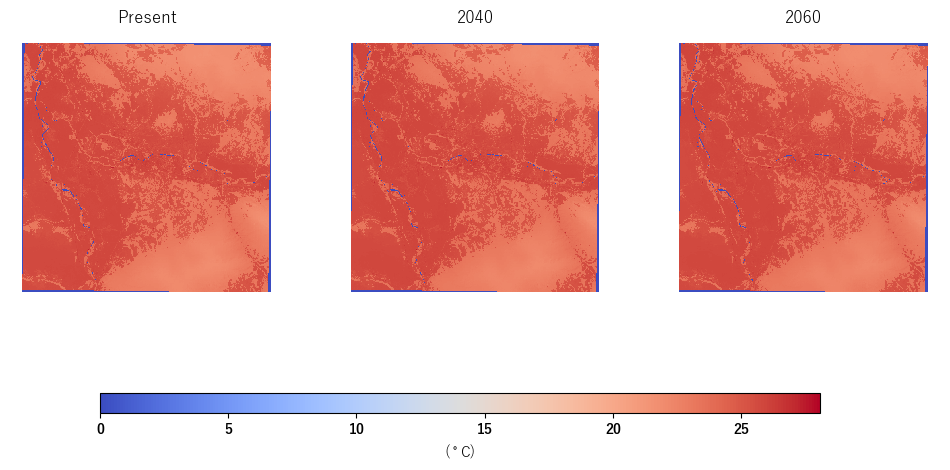

(3.0, 6.0)

<Figure size 1200x1000 with 0 Axes>

In [29]:
WBGT_JJA_daily_mean_max_vsum1 , WBGT_JJA_daily_mean_max_vsum2=juxtapose_ssps_max_temp_june_august(data)
WBGT_JJA_daily_mean_max_vsum1 , WBGT_JJA_daily_mean_max_vsum2

In [30]:
def juxtapose_ssps_energy_cooling_days(data):
    input_raster_dir = data
    root=input_raster_dir
    file_name="cooling_degree_hours_present_2001_2020_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    cooling_degree_hours_present_2001_2020_30m_EPSG4326=polygonized_shapefile

    file_name="cooling_degree_hours_ssp370_2021_2040_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    cooling_degree_hours_ssp370_2021_2040_30m_EPSG4326=polygonized_shapefile

    file_name="cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326=polygonized_shapefile

    visualize_column=raster_val
    cmap = "coolwarm"
    vmin = cooling_degree_hours_present_2001_2020_30m_EPSG4326[visualize_column].min()
    vmax = cooling_degree_hours_present_2001_2020_30m_EPSG4326[visualize_column].max()
    vsum0 = cooling_degree_hours_present_2001_2020_30m_EPSG4326[visualize_column].sum()
    # Start a loop over all the variables of interest
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(width, height))
    # Make the axes accessible with single indexing
    axs = axs.flatten()
    i=0
    ax = axs[i]    
    gdp_ax= cooling_degree_hours_present_2001_2020_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days present 2001 2020"
    title="Present"
    ax.set_title(title)

    vsum1 = cooling_degree_hours_ssp370_2021_2040_30m_EPSG4326[visualize_column].sum()
    i=1
    ax = axs[i]    
    gdp_ax= cooling_degree_hours_ssp370_2021_2040_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days: SSP1 2021-2040"
    title="2040"
    ax.set_title(title)

    vmin = cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326[visualize_column].min()
    vmax = cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326[visualize_column].max()
    vsum2 = cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326[visualize_column].sum()

    i=2
    ax = axs[i]    
    gdp_ax= cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days: SSP1 2041-2060"
    title="2060"
    ax.set_title(title)

    fig = f #ax.get_figure()
    # cax = fig.add_axes([0.9, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    cax = fig.add_axes([0.2, 0.25, 0.6, 0.02]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    CB=fig.colorbar(sm, cax=cax,  label="Cooling degees: Energy demand", orientation='horizontal' , shrink=0.8)
    # Display the figure
    plt.show()
    cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326_vsum1= round((vsum1 - vsum0) / abs(vsum0) * 100, 0) 
    cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326_vsum2= round((vsum2 - vsum0) / abs(vsum0) * 100, 0) 
    plt.tight_layout()
    map_output=f"{maps}/cooling_degree_hours_ssp370.png"
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)
    return cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326_vsum1 , cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326_vsum2

cooling degree hours present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\cooling_degree_hours_present_2001_2020_30m_EPSG4326.tif


cooling degree hours ssp370 2021 2040 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\cooling_degree_hours_ssp370_2021_2040_30m_EPSG4326.tif
cooling degree hours ssp370 2041 2060 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326.tif


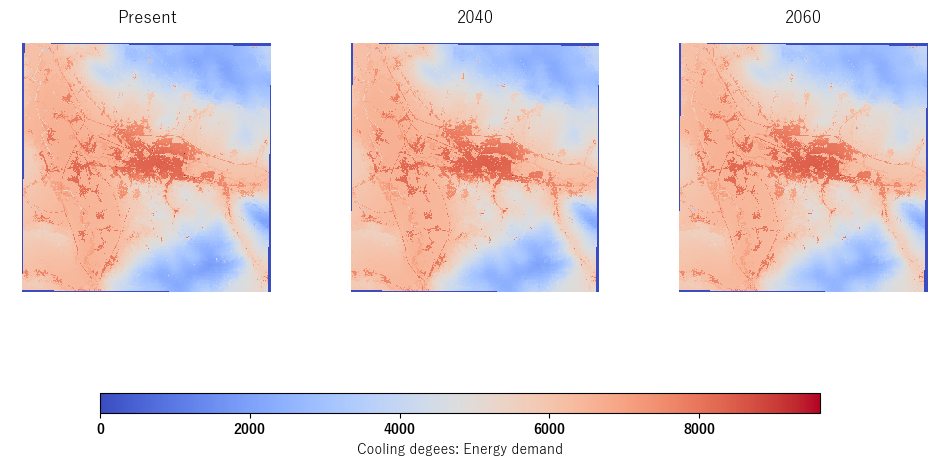

<Figure size 1200x1000 with 0 Axes>

In [31]:
cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326_vsum1 , cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326_vsum2=juxtapose_ssps_energy_cooling_days(data)


In [32]:
cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326_vsum1 , cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326_vsum2

(25.0, 56.0)

heatwave days present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\heatwave_days_present_2001_2020_30m_EPSG4326.tif
heatwave days ssp370 2021 2040 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\heatwave_days_ssp370_2021_2040_30m_EPSG4326.tif
heatwave days ssp370 2041 2060 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\heatwave_days_ssp370_2041_2060_30m_EPSG4326.tif


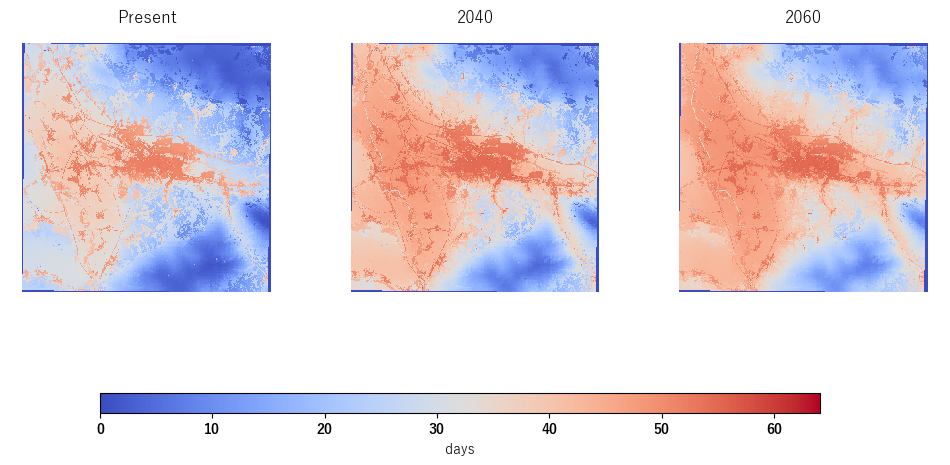

(48.0, 95.0)

<Figure size 1200x1000 with 0 Axes>

In [33]:
def juxtapose_ssps_heatwave_days(data):
    cities_reprojected=gdf_city.reset_index()
    heat_raster_list= ["heatwave_days_present_2001_2020_30m_EPSG4326", "heatwave_days_ssp370_2021_2040_30m_EPSG4326", "heatwave_days_ssp370_2041_2060_30m_EPSG4326", "heatwave_days_ssp370_2021_2040_30m_EPSG4326", "heatwave_days_ssp370_2041_2060_30m_EPSG4326"]
    input_raster_dir = data
    extension = '.tif'
    root=input_raster_dir
    file_name="heatwave_days_present_2001_2020_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_present_2001_2020_30m_EPSG4326=polygonized_shapefile

    file_name="heatwave_days_ssp370_2021_2040_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_ssp370_2021_2040_30m_EPSG4326=polygonized_shapefile

    file_name="heatwave_days_ssp370_2041_2060_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_ssp370_2041_2060_30m_EPSG4326=polygonized_shapefile

    visualize_column=raster_val
    cmap = "coolwarm"
    vmin = heatwave_days_present_2001_2020_30m_EPSG4326[visualize_column].min()
    vmax = heatwave_days_present_2001_2020_30m_EPSG4326[visualize_column].max()
    vsum0 = heatwave_days_present_2001_2020_30m_EPSG4326[visualize_column].sum()
    # Start a loop over all the variables of interest
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(width, height))
    # Make the axes accessible with single indexing
    axs = axs.flatten()
    i=0
    ax = axs[i]    
    gdp_ax= heatwave_days_present_2001_2020_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days present 2001 2020"
    title="Present"
    ax.set_title(title)

    vsum1 = heatwave_days_ssp370_2021_2040_30m_EPSG4326[visualize_column].sum()
    i=1
    ax = axs[i]    
    gdp_ax= heatwave_days_ssp370_2021_2040_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days: SSP1 2021-2040"
    title="2040"
    ax.set_title(title)

    vmin = heatwave_days_ssp370_2041_2060_30m_EPSG4326[visualize_column].min()
    vmax = heatwave_days_ssp370_2041_2060_30m_EPSG4326[visualize_column].max()
    vsum2 = heatwave_days_ssp370_2041_2060_30m_EPSG4326[visualize_column].sum()

    i=2
    ax = axs[i]    
    gdp_ax= heatwave_days_ssp370_2041_2060_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days: SSP1 2041-2060"
    title="2060"
    ax.set_title(title)

    fig = f #ax.get_figure()
    # cax = fig.add_axes([0.9, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    cax = fig.add_axes([0.2, 0.25, 0.6, 0.02]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    # fig.colorbar(sm, cax=cax,  label="Population")
    # CB=fig.colorbar(sm, cax=cax,  label="Population", orientation='horizontal', shrink=0.8) #"($^\circ$C)"
    CB=fig.colorbar(sm, cax=cax,  label="days", orientation='horizontal' , shrink=0.8)
    # CB=fig.colorbar(gdp_ax, cax=cax,  label="Heatwave days", orientation='horizontal' , shrink=0.8)
    # Display the figure
    plt.show()
    pct_change_heat_days_vsum1= round((vsum1 - vsum0) / abs(vsum0) * 100, 0) 
    pct_change_heat_days_vsum2= round((vsum2 - vsum0) / abs(vsum0) * 100, 0) 


    plt.tight_layout()
    # ax.figure.savefig(map_output)
    map_output=f"{maps}/ssps_heatwave_days.png"
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

    return pct_change_heat_days_vsum1 , pct_change_heat_days_vsum2

pct_change_heat_days_vsum1 , pct_change_heat_days_vsum2=juxtapose_ssps_heatwave_days(data)
pct_change_heat_days_vsum1 , pct_change_heat_days_vsum2

In [34]:
pct_change_heat_days_vsum1 , pct_change_heat_days_vsum2

(48.0, 95.0)

T2M nightover25 present 2001 2020 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_nightover25_present_2001_2020_30m_EPSG4326.tif
T2M nightover25 ssp370 2021 2040 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_nightover25_ssp370_2021_2040_30m_EPSG4326.tif
T2M nightover25 ssp370 2041 2060 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_nightover25_ssp370_2041_2060_30m_EPSG4326.tif


KeyboardInterrupt: 

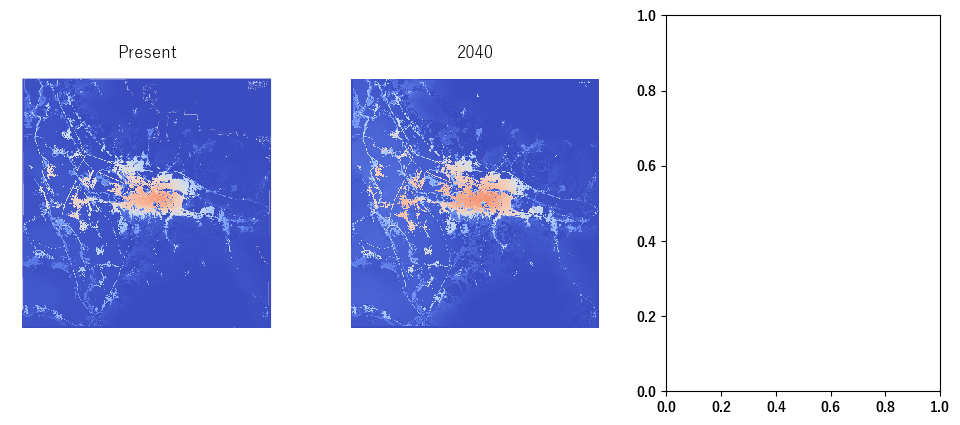

In [35]:
def juxtapose_ssps_tropical_nights(data):
    cities_reprojected=gdf_city.reset_index()
    input_raster_dir = data
    extension = '.tif'
    root=input_raster_dir
    file_name="T2M_nightover25_present_2001_2020_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_present_2001_2020_30m_EPSG4326=polygonized_shapefile

    file_name="T2M_nightover25_ssp370_2021_2040_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_ssp370_2021_2040_30m_EPSG4326=polygonized_shapefile

    file_name="T2M_nightover25_ssp370_2041_2060_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_ssp370_2041_2060_30m_EPSG4326=polygonized_shapefile

    visualize_column=raster_val
    cmap = "coolwarm"
    vmin = heatwave_days_present_2001_2020_30m_EPSG4326[visualize_column].min()
    vmax = heatwave_days_present_2001_2020_30m_EPSG4326[visualize_column].max()
    vsum0 = heatwave_days_present_2001_2020_30m_EPSG4326[visualize_column].sum()
    # Start a loop over all the variables of interest
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(width, height))
    # Make the axes accessible with single indexing
    axs = axs.flatten()
    i=0
    ax = axs[i]    
    gdp_ax= heatwave_days_present_2001_2020_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days present 2001 2020"
    title="Present"
    ax.set_title(title)

    vsum1 = heatwave_days_ssp370_2021_2040_30m_EPSG4326[visualize_column].sum()
    i=1
    ax = axs[i]    
    gdp_ax= heatwave_days_ssp370_2021_2040_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days: SSP1 2021-2040"
    title="2040"
    ax.set_title(title)

    vmin = heatwave_days_ssp370_2041_2060_30m_EPSG4326[visualize_column].min()
    vmax = heatwave_days_ssp370_2041_2060_30m_EPSG4326[visualize_column].max()
    vsum2 = heatwave_days_ssp370_2041_2060_30m_EPSG4326[visualize_column].sum()

    i=2
    ax = axs[i]    
    gdp_ax= heatwave_days_ssp370_2041_2060_30m_EPSG4326.to_crs(crs).plot(ax=ax, column= visualize_column, linewidth=0, legend=False, cmap=cmap,)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    # title="Heatwave days: SSP1 2041-2060"
    title="2060"
    ax.set_title(title)

    fig = f #ax.get_figure()
    # cax = fig.add_axes([0.9, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    cax = fig.add_axes([0.2, 0.25, 0.6, 0.02]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    # fig.colorbar(sm, cax=cax,  label="Population")
    # CB=fig.colorbar(sm, cax=cax,  label="Population", orientation='horizontal', shrink=0.8) #"($^\circ$C)"
    CB=fig.colorbar(sm, cax=cax,  label="nights", orientation='horizontal' , shrink=0.8)
    # CB=fig.colorbar(gdp_ax, cax=cax,  label="Heatwave days", orientation='horizontal' , shrink=0.8)
    # Display the figure
    plt.show()
    pct_change_T2M_nightover25_vsum1= round((vsum1 - vsum0) / abs(vsum0) * 100, 0) 
    pct_change_T2M_nightover25_vsum2= round((vsum2 - vsum0) / abs(vsum0) * 100, 0) 
    plt.tight_layout()
    # ax.figure.savefig(map_output)
    map_output=f"{maps}/ssps_tropical_night_T2M_over_25.png"
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)
    return pct_change_T2M_nightover25_vsum1 , pct_change_T2M_nightover25_vsum2

pct_change_T2M_nightover25_vsum1 , pct_change_T2M_nightover25_vsum2=juxtapose_ssps_tropical_nights(data)
pct_change_T2M_nightover25_vsum1 , pct_change_T2M_nightover25_vsum2


In [ ]:
def map_profile(maps, vector_file,  hexagons, profile_x_var, legend_title,legends_format, crs ,cmap,  visualize_column, title, map_output, scheme):
    #------------------------------------------------------
    # Centroid for starting the line. use the sample function if needed. 
    cent_x = gdf_city.centroid.x.values[0]  
    cent_y = gdf_city.centroid.y.values[0]  
    # print(cent_x)
    start = Point(cent_x, cent_y)
    length = .05
    angle = math.pi / 2
    end = Point(start.x + length, start.y)
    line = LineString([start, end])
    line = rotate(line, angle, origin=start, use_radians=True)
    # Define a LineString feature geometry with one attribute
    schema = {
        'geometry': 'LineString',
        'properties': {'id': 'int'},
        }
    # Write a new Shapefile
    with fiona.open(f"{shapefiles}/Poly.shp", mode='w', driver='ESRI Shapefile',crs='epsg:4326', schema=schema) as c:
        ## If there are multiple geometries, put the "for" loop here
        c.write({
            'geometry': mapping(line),
            'properties': {'id': 123},
        })

    lines_read= gpd.read_file(f"{shapefiles}/Poly.shp").to_crs(crs)
    newdf = gpd.sjoin(hexagons.to_crs(crs), lines_read)
    for ind, row in lines_read.iterrows():
        XS_ID = row['id']
        start_coords =  list([row.geometry][0].coords)[0]
        end_coords = list([row.geometry][0].coords)[1]
        lon = [start_coords[0]]
        lat = [start_coords[1]]
        n_points = 10
        for i in np.arange(1, n_points+1):
            x_dist = end_coords[0] - start_coords[0]
            y_dist = end_coords[1] - start_coords[1]
            point  = [(start_coords[0] + (x_dist/(n_points+1))*i), (start_coords[1] + (y_dist/(n_points+1))*i)]
            lon.append(point[0])
            lat.append(point[1])
            
        lon.append(end_coords[0])
        lat.append(end_coords[1])
        df = pd.DataFrame({'Latitude': lat, 
                        'Longitude': lon})
        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.crs = {'init': 'epsg:4326'}
        gdf_pcs = gdf.to_crs(epsg = 3857)
        gdf_pcs['h_distance'] = 0
        for index, row in gdf_pcs.iterrows():
            gdf_pcs['h_distance'].loc[index] = gdf_pcs.geometry[0].distance(gdf_pcs.geometry[index])
            
    line_spat_join = gpd.sjoin(hexagons.to_crs(crs), gdf_pcs.to_crs(crs), how="right", predicate='contains')
    fig, ax = plt.subplots(figsize = (3.5, 2.5))
    # ax.plot(line_spat_join['h_distance'], line_spat_join[f'{visualize_column}'])
    ax.plot(line_spat_join[profile_x_var], line_spat_join[f'{visualize_column}'])
    ax.set_title(label=f"{legend_title} profile" , fontdict={'fontsize': 11, 'fontweight': 'medium'})
    
    # fig.suptitle(f"{legend_title} profile", fontsize=10)
    plt.xticks(fontsize=9) # rotation=90
    plt.yticks(fontsize=9) 
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    ax.figure.savefig(f'{maps}/profile_{visualize_column}.png',  bbox_inches='tight', dpi=50) #, transparent=True                
    # plt.show()
    
    #------------------------------------------------------------------------
  
    ax = hexagons.to_crs(crs).plot(figsize=(width, height), \
                                column= visualize_column, \
                                alpha=0.6, scheme=scheme, cmap=cmap, \
                                legend=True,  # Add legend 
                                legend_kwds={'loc':'upper right', 
                                                'bbox_to_anchor':(1, 1), 
                                                'fmt':legends_format,
                                                'markerscale':1.01, 
                                                'title_fontsize':'small', 
                                                'fontsize':'x-small'
                                                # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                } ,
                                aspect=1
                                        )
    # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    # cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,  crs=crs) 
    vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    lines_read.to_crs(crs).plot(ax=ax,facecolor='blue',edgecolor='black', linewidth=1 ,alpha=0.9)

    file = f'{maps}/profile_{visualize_column}.png'
    logo = image.imread(file)
    imagebox = OffsetImage(logo)
    #Container for an `OffsetBox` (here imagebox) referring to a specific position *xy*.
    x= cent_x #21.933
    y= cent_y #43.343
    xy=(x+.09, y+.01)
    ab = AnnotationBbox(imagebox, xy, frameon = False)
    ax.add_artist(ab)

    max_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()][f'{visualize_column}'].round(1)
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Longitude']
    
    value=f"Max: {max_value}"
    xy=(Longitude, Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(Longitude-.06, Latitude-.009), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    
    min_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()][f'{visualize_column}'].round(1)
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Longitude']
    
    value=f"Min: {min_value}"
    xy=(Longitude, Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(Longitude-.06, Latitude+.003), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3")) #, shrink=0.007

    for x, y in zip(lon[::2], lat[::2]):
        # print(f'{x} -> {y}')
        value="------------"
        ax.text(x, y, f"{value}", ha="center", va="center", rotation=90, size=2,
                bbox=dict(boxstyle="rarrow,pad=0.2", fc="steelblue", ec="black", lw=2))

    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs , zoom=12) 
    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs, zoom=11) # zoom=13
    plt.xticks([])
    plt.yticks([]) 
    leg1 = ax.get_legend()
    # Set markers to square shape
    for ea in leg1.legendHandles:
        ea.set_marker('s')
    leg1.set_title(f'{legend_title}')
    ax.title.set_text(f'{title}')

    plt.tight_layout()
    # ax.figure.savefig(map_output)
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)



: 

Tree cover, population density and LST profiles 

In [ ]:
if __name__ ==  '__main__': 
    input_raster_dir = data
    extension = '.tif'
    for root, dirs_list, files_list in os.walk( input_raster_dir):
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension and "pop_density" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                # file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)

                cities_reprojected=gdf_city.reset_index()
                # raster_filename= "heatwave_days_present_2001_2020_30m_EPSG4326"
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)

                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  

                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")

                cmap = "OrRd"
                legends_format= '{:,.2f}'
                legend_title= "Population"
                map_title= f"Population Density {city}"
                scheme="quantiles"
                map_output= f'{maps}/{city}_map_profile_{file_name}.png'
                export_the_map= map_profile(maps=maps, vector_file=gdf_city, hexagons=polygonized_shapefile,  profile_x_var='h_distance',legend_title=legend_title,
                                            legends_format=legends_format, crs=crs, cmap=cmap, 
                                            visualize_column=raster_val,title=map_title, map_output=map_output, scheme=scheme)

            elif os.path.splitext(file_name)[-1] == extension and "land_surface_temperature" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                # file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)

                cities_reprojected=gdf_city.reset_index()
                # raster_filename= "heatwave_days_present_2001_2020_30m_EPSG4326"
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)

                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  

                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                
                cmap = "OrRd"
                legends_format= '{:,.0f}'
                legend_title= "LST"
                map_title= f"Land Surface Temperature {city}"
                scheme="quantiles"
                map_output= f'{maps}/{city}_map_profile_{file_name}.png'
                export_the_map= map_profile(maps=maps, vector_file=gdf_city, hexagons=polygonized_shapefile,  profile_x_var='h_distance',legend_title=legend_title,
                                            legends_format=legends_format, crs=crs, cmap=cmap, 
                                            visualize_column=raster_val,title=map_title, map_output=map_output, scheme=scheme)

            elif os.path.splitext(file_name)[-1] == extension and "tree_cover_landsat" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                # file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)

                cities_reprojected=gdf_city.reset_index()
                # raster_filename= "heatwave_days_present_2001_2020_30m_EPSG4326"
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)

                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  

                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                
                cmap = "Greens"
                legends_format= '{:,.0f}'
                legend_title= "Tree cover"
                map_title= f"Tree cover {city}"
                scheme="quantiles"
                map_output= f'{maps}/{city}_map_profile_{file_name}.png'
                export_the_map= map_profile(maps=maps, vector_file=gdf_city, hexagons=polygonized_shapefile,  profile_x_var='h_distance',legend_title=legend_title,
                                            legends_format=legends_format, crs=crs, cmap=cmap, 
                                            visualize_column=raster_val,title=map_title, map_output=map_output, scheme=scheme)



: 

In [37]:
park , education, industry, building, building_footprint=export_services_infrastructure_inside_poly_to_shp(shapefile=gdf_city.reset_index())


C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\1991168300.py:157: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points.geometry = points['geometry'].centroid
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\1991168300.py:161: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(f'{shapefiles}/park.shp', driver='ESRI Shapefile')
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\1991168300.py:179: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points.geometry = points['geometry'].centroid
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\1991168300.py:183: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shape

Add a map with zoomin to parks, draw a crossection and another for profiles through UHI days and nights. Also export the ssps changes to as a values to the table in ppt.

In [48]:

def get_park_coordinate(park):
    print(park.crs)
    series = park.geometry
    max_distance = 1

    points_within = []
    for i1,i2 in combinations(range(0,series.shape[0]-1),2):  #Iterate over all pairs/combinations of indices
        # if 0.05<series[i1].distance(series[i2])<=max_distance:
        if series[i1].distance(series[i2])>0:
            points_within.append([series[i1],series[i2]])
    geoms = [LineString(pointpair) for pointpair in points_within]
    df2 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(geoms))
    [points_within[0], points_within[-1]]
    return points_within

def get_angle(x1,y1,x2,y2):
    return math.degrees(math.atan2(y2-y1, x2-x1))

points_within=get_park_coordinate(park)


epsg:4326


 add min max difference too. Count trees from landsat 

In [ ]:
def map_profile_parks(maps, vector_file,  hexagons, park, profile_x_var, legend_title,legends_format, crs ,cmap,  visualize_column, title, map_output, scheme):
    #------------------------------------------------------
    # Centroid for starting the line. use the sample function if needed. 
    cent_x = gdf_city.centroid.x.values[0]  
    cent_y = gdf_city.centroid.y.values[0]  
    end = Point(cent_x, cent_y)
    park_coords_all=get_park_coordinate(park)
    start = park_coords_all[-1][0]
    line = LineString([start, end])

    lon_park = start.x
    lat_park  = start.y
    
    # Define a LineString feature geometry with one attribute
    schema = {
        'geometry': 'LineString',
        'properties': {'id': 'int'},
        }
    # Write a new Shapefile
    with fiona.open(f"{shapefiles}/Poly.shp", mode='w', driver='ESRI Shapefile',crs='epsg:4326', schema=schema) as c:
        ## If there are multiple geometries, put the "for" loop here
        c.write({
            'geometry': mapping(line),
            'properties': {'id': 123},
        })

    lines_read= gpd.read_file(f"{shapefiles}/Poly.shp").to_crs(crs)
    newdf = gpd.sjoin(hexagons.to_crs(crs), lines_read)
    for ind, row in lines_read.iterrows():
        XS_ID = row['id']
        start_coords =  list([row.geometry][0].coords)[0]
        end_coords = list([row.geometry][0].coords)[1]
        lon = [start_coords[0]]
        lat = [start_coords[1]]
        n_points = 10
        for i in np.arange(1, n_points+1):
            x_dist = end_coords[0] - start_coords[0]
            y_dist = end_coords[1] - start_coords[1]
            point  = [(start_coords[0] + (x_dist/(n_points+1))*i), (start_coords[1] + (y_dist/(n_points+1))*i)]
            lon.append(point[0])
            lat.append(point[1])
            
        lon.append(end_coords[0])
        lat.append(end_coords[1])
        df = pd.DataFrame({'Latitude': lat, 
                        'Longitude': lon})
        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.crs = {'init': 'epsg:4326'}
        gdf_pcs = gdf.to_crs(epsg = 3857)
        gdf_pcs['h_distance'] = 0
        for index, row in gdf_pcs.iterrows():
            gdf_pcs['h_distance'].loc[index] = gdf_pcs.geometry[0].distance(gdf_pcs.geometry[index])
            
    fig, ax = plt.subplots(figsize = (3.5, 2.5))
    line_spat_join = gpd.sjoin(hexagons.to_crs(crs), gdf_pcs.to_crs(crs), how="right", predicate='contains')
    ax.plot(line_spat_join[profile_x_var], line_spat_join[f'{visualize_column}'])
    ax.set_title(label=f"{legend_title} profile" , fontdict={'fontsize': 10, 'fontweight': 'medium'})
    
    plt.xticks(fontsize=9) # rotation=90
    plt.yticks(fontsize=9) 
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    ax.figure.savefig(f'{maps}/profile_{visualize_column}.png',  bbox_inches='tight', dpi=50) #, transparent=True                
    # plt.show()
    
    #-----------------------------------------------------------------------------------------------------------
    ax=hexagons.to_crs(crs).plot(figsize=(width, height), \
                                column= visualize_column, \
                                alpha=0.6, scheme=scheme, cmap=cmap, \
                                legend=True,  # Add legend 
                                legend_kwds={'loc':'upper right', 
                                                'bbox_to_anchor':(1, 1), 
                                                'fmt':legends_format,
                                                'markerscale':1.01, 
                                                'title_fontsize':'small', 
                                                'fontsize':'x-small'
                                                # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                                } ,
                                aspect=1
                                        )
    # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    # cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,  crs=crs) 
    vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    lines_read.to_crs(crs).plot(ax=ax,facecolor='blue',edgecolor='black', linewidth=1 ) #,alpha=0.9
    file = f'{maps}/profile_{visualize_column}.png'
    logo = image.imread(file)
    imagebox = OffsetImage(logo)
    #Container for an `OffsetBox` (here imagebox) referring to a specific position *xy*.
    x= cent_x #21.933
    y= cent_y #43.343
    xy=(x+.09, y+.01)
    ab = AnnotationBbox(imagebox, xy, frameon = False)
    ax.add_artist(ab)

    max_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()][f'{visualize_column}'].round()
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Longitude']
    
    # print(1)
    park_value= line_spat_join.loc[(line_spat_join['Latitude'] == lat_park) & (line_spat_join['Longitude'] == lon_park)][f'{visualize_column}'].round()
    park_value=park_value.item()
    park_Latitude= line_spat_join.loc[line_spat_join['Latitude']== lat_park, 'Latitude']
    park_Longitude= line_spat_join.loc[line_spat_join['Longitude']== lon_park, 'Longitude']
    # print(2)

    value=f"Park: {int(park_value)}"
    xy=(park_Longitude, park_Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(park_Longitude+.06, park_Latitude+.009), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    # print(3)

    value=f"Max: {int(max_value)}"
    xy=(Longitude, Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(Longitude-.06, Latitude-.009), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    min_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()][f'{visualize_column}'].round()
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Longitude']
    
    value=f"Min: {int(min_value)}"
    xy=(Longitude, Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(Longitude-.06, Latitude+.003), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3")) #, shrink=0.007


    angle=get_angle(x1=lon_park,y1=lat_park,x2=cent_x,y2=cent_y)
    for x, y in zip(lon[::2], lat[::2]):
        value="---"
        ax.text(x, y, f"{value}", ha="center", va="center", rotation=angle, size=2,
                bbox=dict(boxstyle="rarrow,pad=0.3", fc="steelblue", ec="black", lw=1))
    # print(4)

    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs , zoom=12) 
    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs, zoom=11) # zoom=13
    plt.xticks([])
    plt.yticks([]) 
    leg1 = ax.get_legend()
    # Set markers to square shape
    for ea in leg1.legendHandles:
        ea.set_marker('s')
    leg1.set_title(f'{legend_title}')
    ax.title.set_text(f'{title}')
    # print(5)

    plt.tight_layout()
    # ax.figure.savefig(map_output)
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

: 

In [ ]:
if __name__ ==  '__main__': 
    input_raster_dir = data
    extension = '.tif'
    for root, dirs_list, files_list in os.walk( input_raster_dir):
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension and "land_surface_temperature" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                # file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)
                cities_reprojected=gdf_city.reset_index()
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)
                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  
                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                cmap = "OrRd"
                legends_format= '{:,.0f}'
                legend_title= "LST"
                map_title= f"Land Surface Temperature {city}"
                scheme="quantiles"
                map_output= f'{maps}/{city}_map_park_profile_{file_name}.png'
                export_the_map=map_profile_parks(maps=maps, vector_file=gdf_city, hexagons=polygonized_shapefile,park=park,  
                                                 profile_x_var='h_distance',legend_title=legend_title, 
                                                 legends_format=legends_format, crs=crs, cmap=cmap, 
                                                 visualize_column=raster_val,title=map_title, map_output=map_output, 
                                                 scheme=scheme)

: 

In [ ]:
def map_profile_parks_zoomed_in(maps, vector_file,  hexagons, park, profile_x_var, legend_title,legends_format, crs ,cmap,  visualize_column, title, map_output, scheme):
    vmin = hexagons[visualize_column].min()
    vmax = hexagons[visualize_column].max()
    cent_x = gdf_city.centroid.x.values[0]  
    cent_y = gdf_city.centroid.y.values[0]  
    park_coords_all=get_park_coordinate(park)
    park_coords = park_coords_all[-1][0]
    lon_park = park_coords.x
    lat_park  = park_coords.y

    length = .025
    angle = -math.pi / 8
    start = Point(park_coords.x - length, park_coords.y)
    end = Point(park_coords.x + length, park_coords.y)
    park_point = Point(park_coords.x, park_coords.y)
    line = LineString([start, end])
    # for restircting line within the boundary
    gdf_line = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[line])
    # line_spat_join_city = gpd.sjoin(gdf_city.to_crs(crs), gdf_line.to_crs(crs), how="right", predicate='contains')
    line_spat_join_city =overlay(gdf_line.to_crs(crs), gdf_city.to_crs(crs), how="intersection")

    # Extract start and end coordinates of each linestring
    first_coord = line_spat_join_city["geometry"].apply(lambda g: g.coords[0])
    last_coord = line_spat_join_city["geometry"].apply(lambda g: g.coords[-1])
    # Add start and end as columns to the gdf
    line_spat_join_city["start_coord"] = first_coord
    line_spat_join_city["end_coord"] = last_coord
    line_spat_join_city
    # line_spat_join_city.end_coord
    end=line_spat_join_city['end_coord'].iloc[0]
    start=line_spat_join_city['start_coord'].iloc[0]
    end_x= end[0]
    end_y= end[1]
    start_x= start[0]
    start_y= start[1]

    line = LineString([Point(start_x , start_y), Point(end_x , end_y)])
    gdf_line_export = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[line])
    gdf_line_export.to_file(f"{shapefiles}/Poly.shp")
    lines_read= gpd.read_file(f"{shapefiles}/Poly.shp").to_crs(crs)
    for ind, row in lines_read.iterrows():
        # XS_ID = row['id']
        start_coords =  list([row.geometry][0].coords)[0]
        end_coords = list([row.geometry][0].coords)[1]
        lon = [start_coords[0]]
        lat = [start_coords[1]]
        n_points = 20
        for i in np.arange(1, n_points+1):
            x_dist = end_coords[0] - start_coords[0]
            y_dist = end_coords[1] - start_coords[1]
            point  = [(start_coords[0] + (x_dist/(n_points+1))*i), (start_coords[1] + (y_dist/(n_points+1))*i)]
            lon.append(point[0])
            lat.append(point[1])
        lon.append(end_coords[0])
        lat.append(end_coords[1])
        df = pd.DataFrame({'Latitude': lat, 
                        'Longitude': lon})
        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.crs = {'init': 'epsg:4326'}
        gdf_pcs = gdf.to_crs(epsg = 3857)
        gdf_pcs['h_distance'] = 0
        for index, row in gdf_pcs.iterrows():
            gdf_pcs['h_distance'].loc[index] = gdf_pcs.geometry[0].distance(gdf_pcs.geometry[index])
            
    # fig, ax = plt.subplots(figsize = (3.8, 2.8))
    fig, ax = plt.subplots(figsize=(width, height))
    line_spat_join = gpd.sjoin(hexagons.to_crs(crs), gdf_pcs.to_crs(crs), how="right", predicate='contains')
    ax.plot(line_spat_join[profile_x_var], line_spat_join[f'{visualize_column}'])
    ax.set_title(label=f"" , fontdict={'fontsize': 11, 'fontweight': 'medium'})
    
    plt.xticks(fontsize=9) # rotation=90
    plt.yticks(fontsize=9)
    ax.set_xlabel('Distance (meters)' , fontsize=9)
    ax.set_ylabel(f'{legend_title}', fontsize=9)   # relative to plt.rcParams['font.size'] , fontsize='medium'
     
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    ax.figure.savefig(f'{maps}/profile_{visualize_column}.png',  bbox_inches='tight', dpi=300) #, transparent=True                
    # plt.show()
    
    # Buffer for zoom in
    locations = pd.DataFrame([
        {'id': '1',
        'Longitude': lon_park,
        'Latitude': lat_park
        }
    ])

    park_gpd = gpd.GeoDataFrame(locations,geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude),crs=crs)
    park_point_feature =park_gpd
    park_gpd['geometry'] = park_gpd['geometry'].buffer(length*1.2, cap_style = 3) #Buffer
    park_gpd_spat_join =overlay(hexagons.to_crs(crs), park_gpd.to_crs(crs), how="intersection")

    #-----------------------------------------------------------------------------------------------------------
    ax=park_gpd_spat_join.to_crs(crs).plot(figsize=(width, height), \
                                column= visualize_column, \
                                alpha=0, scheme=scheme, cmap=cmap, \
                                legend=False,  # Add legend 
                                # legend_kwds={'loc':'upper right', 
                                #                 'bbox_to_anchor':(1, 1), 
                                #                 'fmt':legends_format,
                                #                 'markerscale':1.01, 
                                #                 'title_fontsize':'small', 
                                #                 'fontsize':'x-small'
                                #                 # title_fontsizeint or {'xx-small', 'x-small', 'small'
                                #                 } ,
                                aspect=1
                                        )
    # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    # cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,  crs=crs) 
    lines_read.to_crs(crs).plot(ax=ax,facecolor='blue',edgecolor='black', linewidth=3 ) #,alpha=0.9
    # cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,  crs=crs) 
    cx.add_basemap(ax,
                zoom="auto",
                # zoom=10,
                crs=park_gpd_spat_join.crs.to_string(),
                # source=cx.providers.CartoDB.Voyager,
                source=cx.providers.OpenStreetMap.Mapnik,
                attribution=False, #No citation
                # attribution_size=1
                )
    
    file = f'{maps}/profile_{visualize_column}.png'
    logo = image.imread(file)
    imagebox = OffsetImage(logo)
    #Container for an `OffsetBox` (here imagebox) referring to a specific position *xy*.
    x= end_x #21.933
    y= end_y #43.343
    xy=(x-length/2, y-length/1.5)
    # ab = AnnotationBbox(imagebox, xy, frameon = False)
    # ax.add_artist(ab)

    max_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()][f'{visualize_column}'].item()
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Longitude']
    print(1)

    points = gpd.GeoSeries([park_point])
    point_gdf = gpd.GeoDataFrame({'geometry': points})
    park_value_intersected_only = gpd.overlay(point_gdf,  hexagons.to_crs(crs), how='intersection')
    park_value= park_value_intersected_only[f'{visualize_column}']
    park_value=park_value.item()
    print(park_value_intersected_only)
    print(park_value)
    value=f"Park: {int(park_value)}"
    # value=f"Park: {park_value}"
    xy=(lon_park, lat_park)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(lon_park, lat_park+.01), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    print(3)

    value=f"Max: {int(max_value)}"
    xy=(Longitude, Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(Longitude, Latitude+.009), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    min_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()][f'{visualize_column}'].item()
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Longitude']
    
    value=f"Min: {int(min_value)}"
    xy=(Longitude, Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(Longitude, Latitude+.009), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3")) #, shrink=0.007

    angle=get_angle(x1=start_x,y1=start_y,x2=end_x,y2=end_y)
    for x, y in zip(lon[::], lat[::]):
        value="-"
        ax.text(x, y, f"{value}", ha="center", va="center", rotation=angle, size=2,
                bbox=dict(boxstyle="rarrow,pad=0.4", fc="black", ec="black", lw=2))
    plt.xticks([])
    plt.yticks([]) 
    title=f""
    ax.title.set_text(f'{title}')
    plt.tight_layout()
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

: 

In [ ]:
if __name__ ==  '__main__': 
    input_raster_dir = data
    extension = '.tif'
    for root, dirs_list, files_list in os.walk( input_raster_dir):
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension and "land_surface_temperature" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                # file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)
                cities_reprojected=gdf_city.reset_index()
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)
                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  
                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                cmap = "OrRd"
                legends_format= '{:,.0f}'
                legend_title= "LST"
                map_title= f"Land Surface Temperature {city}"
                scheme="quantiles"
                map_output= f'{maps}/{city}_map_park_profile_zoomed_{file_name}.png'
                export_the_map=map_profile_parks_zoomed_in(maps=maps, vector_file=gdf_city, hexagons=polygonized_shapefile,park=park,  
                                                 profile_x_var='h_distance',legend_title=legend_title, 
                                                 legends_format=legends_format, crs=crs, cmap=cmap, 
                                                 visualize_column=raster_val,title=map_title, map_output=map_output, 
                                                 scheme=scheme)

: 

In [49]:
gpd1 = park 
gpd2 = gdf_city.centroid 

def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

nearest_df= ckdnearest(gpd1, gpd2)

min_value_row= nearest_df.loc[nearest_df['dist'].idxmin()]
min_value_row=min_value_row['geometry']
print(min_value_row)


POINT (21.938205654721866 43.32851552303172)


C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\3623377332.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd2 = gdf_city.centroid


Add rivers and water bodies profiles too. And annotate these on the profile line plot too.

In [78]:
def map_profile_parks_zoomed_in_all(maps, vector_file,sub_city_gdf, admin_name, hexagons, park_coords, profile_x_var, legend_title,legends_format, crs ,cmap,  visualize_column, title, map_output,profile_output, scheme):
    vmin = hexagons[visualize_column].min()
    vmax = hexagons[visualize_column].max()
    vmean=hexagons[visualize_column].mean()
    lon_park = park_coords.x
    lat_park  = park_coords.y
    length = 0.013
    angle = -math.pi / 8
    start = Point(park_coords.x - length, park_coords.y)
    end = Point(park_coords.x + length, park_coords.y)
    park_point = Point(park_coords.x, park_coords.y)
    line = LineString([start, end])
    # for restircting line within the boundary
    gdf_line = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[line])
    # line_spat_join_city = gpd.sjoin(gdf_city.to_crs(crs), gdf_line.to_crs(crs), how="right", predicate='contains')
    line_spat_join_city =overlay(gdf_line.to_crs(crs), gdf_city.to_crs(crs), how="intersection")

    # Extract start and end coordinates of each linestring
    first_coord = line_spat_join_city["geometry"].apply(lambda g: g.coords[0])
    last_coord = line_spat_join_city["geometry"].apply(lambda g: g.coords[-1])
    # Add start and end as columns to the gdf
    line_spat_join_city["start_coord"] = first_coord
    line_spat_join_city["end_coord"] = last_coord
    # line_spat_join_city.end_coord
    end=line_spat_join_city['end_coord'].iloc[0]
    start=line_spat_join_city['start_coord'].iloc[0]
    end_x= end[0]
    end_y= end[1]
    start_x= start[0]
    start_y= start[1]

    line = LineString([Point(start_x , start_y), Point(end_x , end_y)])
    gdf_line_export = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[line])
    gdf_line_export.to_file(f"{shapefiles}/Poly.shp")
    lines_read= gpd.read_file(f"{shapefiles}/Poly.shp").to_crs(crs)
    for ind, row in lines_read.iterrows():
        # XS_ID = row['id']
        start_coords =  list([row.geometry][0].coords)[0]
        end_coords = list([row.geometry][0].coords)[1]
        lon = [start_coords[0]]
        lat = [start_coords[1]]
        n_points = 20
        for i in np.arange(1, n_points+1):
            x_dist = end_coords[0] - start_coords[0]
            y_dist = end_coords[1] - start_coords[1]
            point  = [(start_coords[0] + (x_dist/(n_points+1))*i), (start_coords[1] + (y_dist/(n_points+1))*i)]
            lon.append(point[0])
            lat.append(point[1])
        lon.append(end_coords[0])
        lat.append(end_coords[1])

        # Append Park's coords
        lon.append(lon_park)
        lat.append(lat_park)
        
        df = pd.DataFrame({'Latitude': lat, 
                        'Longitude': lon})
        
        # Sort by two columns after parks added
        df = df.sort_values(['Latitude', 'Longitude'], ascending = [True, True])

        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.crs = {'init': 'epsg:4326'}
        gdf_pcs = gdf.to_crs(epsg = 3857)
        gdf_pcs['h_distance'] = 0
        for index, row in gdf_pcs.iterrows():
            gdf_pcs['h_distance'].loc[index] = gdf_pcs.geometry[0].distance(gdf_pcs.geometry[index])
            
    fig, ax = plt.subplots(figsize=(width, height))
    line_spat_join = gpd.sjoin(hexagons.to_crs(crs), gdf_pcs.to_crs(crs), how="right", predicate='contains')
    ax.plot(line_spat_join[profile_x_var], line_spat_join[f'{visualize_column}'],  marker="o")
    ax.set_title(label=f"" , fontdict={'fontsize': 12, 'fontweight': 'medium'})
    
    plt.xticks(fontsize=10) # rotation=90
    plt.yticks(fontsize=10)
    ax.set_xlabel('Distance (meters)' , fontsize=10)
    ax.set_ylabel(f'{legend_title}', fontsize=10)   # relative to plt.rcParams['font.size'] , fontsize='medium'
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    plt.tight_layout()
    ax.figure.savefig(profile_output,  bbox_inches='tight', dpi=400) #, transparent=True                
                
    # plt.show()
    fig, ax = plt.subplots(figsize=(width*1.4, height/1.2))

    # Buffer for zoom in
    locations = pd.DataFrame([
        {'id': '1',
        'Longitude': lon_park,
        'Latitude': lat_park
        }
    ])

    park_gpd = gpd.GeoDataFrame(locations,geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude),crs=crs)
    park_point_feature =park_gpd
    park_gpd['geometry'] = park_gpd['geometry'].buffer(length*1.2, cap_style = 3) #Buffer
    park_gpd_spat_join =overlay(hexagons.to_crs(crs), park_gpd.to_crs(crs), how="intersection")

    #-----------------------------------------------------------------------------------------------------------
    ax=park_gpd_spat_join.to_crs(crs).plot( 
                                column= visualize_column, \
                                alpha=0, scheme=scheme, cmap=cmap, \
                                legend=False, 
                                ax=ax, 
                                aspect=1
                                        )
    ax=lines_read.to_crs(crs).plot(ax=ax,facecolor='crimson',edgecolor='crimson', linewidth=3 ) #,alpha=0.9

    
    lines_read_buffer = lines_read.to_crs(crs).buffer(.01) #for zoom out
    ax=lines_read_buffer.plot( alpha=0,
                                ax=ax )

    cx.add_basemap(ax,
                zoom="auto",
                # zoom=10,
                crs=park_gpd_spat_join.crs.to_string(),
                # source=cx.providers.CartoDB.Voyager,
                source=cx.providers.OpenStreetMap.Mapnik,
                attribution=False, #No citation
                # attribution_size=1
                )
    file =profile_output # f'{maps}/profile_{visualize_column}.png'
    logo = image.imread(file)
    imagebox = OffsetImage(logo)
    #Container for an `OffsetBox` (here imagebox) referring to a specific position *xy*.
    x= end_x #21.933
    y= end_y #43.343
    xy=(x-length/2, y-length/1.5)

    max_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()][f'{visualize_column}'].round(1) #.item()
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmax()]['Longitude']
    print(1)

    park_value= line_spat_join.loc[(line_spat_join['Latitude'] == lat_park) & (line_spat_join['Longitude'] == lon_park)][f'{visualize_column}'].round(1)
    park_value=park_value.item()
  
    value=f"Park:{park_value}"
    xy=(lon_park, lat_park)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(lon_park, lat_park+.01), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    # print(3)

    value=f"Max:{max_value}"
    xy=(Longitude, Latitude)
    ax.annotate(f"{value}", xy=xy, xycoords='data', xytext=(Longitude, Latitude-.009), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    min_value= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()][f'{visualize_column}'].round(1) #.item()
    Latitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Latitude']
    Longitude= line_spat_join.loc[line_spat_join[f'{visualize_column}'].idxmin()]['Longitude']
    
    angle=get_angle(x1=start_x,y1=start_y,x2=end_x,y2=end_y)
    for x, y in zip(lon[::], lat[::]):
        value="-"
        ax.text(x, y, f"{value}", ha="center", va="center", rotation=angle, size=1.5,
                bbox=dict(boxstyle="rarrow,pad=0.4", fc="crimson", ec="crimson", lw=3))
        
    #########################################


    sub_city_gdf=sub_city_gdf.to_crs(crs)
    # sub_city_gdf['name_en'] =sub_city_gdf[admin_name]               
    # sub_city_gdf= sub_city_gdf.replace('nan', np.nan) #.dropna(how='all', axis=1, inplace=True)
    # label = sub_city_gdf.dropna(subset='name_en')
    # texts = []
    # for i, row in label.iterrows(): 
    #         # print(f"Subcity name: {str(row['name_en'])}")
    #         texts.append(ax.annotate(text=str(row['name_en']), 
    #                                     xy=row.geometry.centroid.coords[0], color="black", xycoords='data',
    #                                     ha='center', fontsize=7,  path_effects=[pe.withStroke(linewidth=2, 
    #                                                                                         foreground="white")]))
            
    
    ax2 = inset_axes(ax, "25%", "45%", loc="upper right")
    ax2 = vector_file.to_crs(crs).plot(ax=ax2, 
                                    #    alpha=0.6,
                                    #    column= visualize_column, 
                                    facecolor='none',
                                    edgecolor='black' ,
                                    label=f"{city}", 
                                    linewidth=1,
                                    #    zorder = 2

                                    )
    ax2 = sub_city_gdf.to_crs(crs).plot(ax=ax2, 
                                    #  alpha=0.6,
                                    facecolor='none',
                                    edgecolor='blue' , 
                                    label="Settlement",
                                    linewidth=.3,
                                    )


    box, c1, c2 = mark_inset(ax2, ax, loc1=2, loc2=4, fc="none", lw=1, ec='r')
    box.set_linewidth(2)
    plt.setp([c1,c2], linewidth=0)

    lines = [
                        Line2D([0],[0],
                               color='black', 
                               label=f'{city}', 
                               fillstyle=None,
                               linestyle="none", 
                               markerfacecolor=None,
                               marker="s", 
                               markersize=5.5),
                        Line2D([0],[0], 
                               color='blue', 
                               label=f'{city}',
                               linestyle="none", 
                               markerfacecolor=None,
                               fillstyle=None, 
                               marker="s", 
                               markersize=5.5),
                        Line2D([0],[0], 
                               color='green', 
                               label='Parks',
                               linestyle="none", 
                               markerfacecolor=None,
                               fillstyle=None, 
                               marker="s", 
                               markersize=5.5),

                               ]

    ax2.legend(handles=lines,loc='upper right', prop = { "size": 8 },)

    plt.xticks([])
    plt.yticks([]) 
    # ax2.set_axis_off()
    print(1)
    index=0
    polygon = vector_file.reset_index().iloc[index]['geometry']
    tags={'leisure':['park',  'garden']}
    park_original=ox.features.features_from_polygon(polygon, tags)
    park.geometry = park_original['geometry'].centroid

    ax = park_original.to_crs(crs).plot(ax=ax,
                                    alpha=0.6,  
                                    facecolor='none',
                                    edgecolor='green' , 
                                    label="Parks",
                                    linewidth=3,
                                    # markersize=30,
                                    # marker="*"   
                                    )

    print(2)
    park_original=park_original.to_crs(crs)
    park_original['name_en'] =park_original[admin_name]               
    park_original= park_original.replace('nan', np.nan) #.dropna(how='all', axis=1, inplace=True)
    label = park_original.dropna(subset='name_en')
    texts = []
    for i, row in label.iterrows(): 
            # print(f"Subcity name: {str(row['name_en'])}")
            texts.append(ax.annotate(text=str(row['name_en']), 
                                        xy=row.geometry.centroid.coords[0], color="black", ha="right", va="center",
                                        xycoords='data',
                                        fontsize=8,  path_effects=[pe.withStroke(linewidth=2, 
                                                                                            foreground="white")]))

    print(3)     
    ########################################

    plt.xticks([])
    plt.yticks([]) 
    title=f""
    ax.title.set_text(f'{title}')
    

    plt.xticks([])
    plt.yticks([]) 
    ax.set_axis_off()

    plt.tight_layout()
    # ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400, pad_inches=0)
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)
    return min_value, max_value, park_value, vmin, vmax, vmean


In [58]:
if __name__ ==  '__main__': 
    input_raster_dir = data
    extension = '.tif'
    for root, dirs_list, files_list in os.walk( input_raster_dir):
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension and "T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326" in file_name:
                file_name_path = os.path.join(root, file_name)
                file_name = os.path.splitext(file_name)[0]
                # file_name = ' '.join(file_name.split("_")[:-2])
                out_rst = os.path.join(rasters, f'{file_name}.tif')
                print(file_name, file_name_path)
                cities_reprojected=gdf_city.reset_index()
                unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
                projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
                reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
                projected_raster=projected_raster)
                output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
                mask_value=None
                variable= file_name
                tif = projected_raster 
                raster_val= variable[0:9]
                raster_val= raster_val.replace(" ", "_")
                name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                                mask_value=mask_value, raster_val=raster_val)  
                polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
                newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
                cmap = "OrRd"
                legends_format= '{:,.0f}'
                legend_title= "UHI (Night-time)"
                map_title= f""
                scheme="quantiles"
                map_output= f'{maps}/{city}_map_park_profile_zoomed_uhi_night{file_name}.png'
                # export_the_map=map_profile_parks_zoomed_in_all(maps=maps, vector_file=gdf_city, hexagons=polygonized_shapefile,min_value_row=min_value_row,  
                #                                  profile_x_var='h_distance',legend_title=legend_title, 
                #                                  legends_format=legends_format, crs=crs, cmap=cmap, 
                #                                  visualize_column=raster_val,title=map_title, map_output=map_output, 
                #                                  scheme=scheme)

T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326 C:/Users/Aziz/Dropbox/CRP/UHI/Nis City\data\T2M_DJF_UHI_night_present_2001_2020_30m_EPSG4326.tif


In [79]:
for index, poi in nearest_df.iterrows():
    if index==49 or index==12 : #checked it.
    # try:
        point_park=poi['geometry']
        print(point_park)
        cmap = "coolwarm"
        map_output= f'{maps}/{city}_park_map_{raster_val}_{index}.png'
        profile_output= f'{maps}/{city}_park_profile_{raster_val}_{index}.png'
        admin_name="name"
        min_value, max_value, park_value, vmin, vmax, vmean=map_profile_parks_zoomed_in_all(maps=maps, vector_file=gdf_city, 
                                            sub_city_gdf=sub_city_gdf, admin_name=admin_name,
                                            hexagons=polygonized_shapefile,
                                            park_coords=point_park,  profile_x_var='h_distance', legend_title=legend_title, 
                                            legends_format=legends_format, crs=crs, cmap=cmap, 
                                            visualize_column=raster_val,title=map_title, map_output=map_output,profile_output=profile_output, scheme=scheme)
    # except:
    #     print(f'Skipped {index}')
    #     pass

POINT (21.895504458513795 43.32610552277212)


c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\4245664949.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_pcs['h_distance'].loc[index] = gdf_pcs.geometry[0].distance(gdf_pcs.geometry[index])
C:\Users\Aziz\AppData\Local\Temp\ipykernel_15152\4245664949.py:98: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a pr

1
1


Run the same for all infra type health etc

In [ ]:
def infra_density_map_and_kdeplot(maps, vector_file,  layer, amenity_type):
    # sn.set_style('darkgrid', {'legend.frameon':True})
    input_raster_dir = data
    extension = '.tif'
    root=input_raster_dir
    file_name="heatwave_days_present_2001_2020_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  
    
    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_present_2001_2020_30m_EPSG4326=newdf
    visualize_column=raster_val
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    line_spat_join_layer = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    cmap = "coolwarm"
    vmin = line_spat_join_layer[visualize_column].min()
    vmax = line_spat_join_layer[visualize_column].max()
    # Start a loop over all the variables of interest
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(width+10, height),  gridspec_kw = {'wspace':.113, 'hspace':0})
    # Make the axes accessible with single indexing
    axs = axs.flatten()
    i=0
    ax = axs[i] 
    line_spat_join_layer_ax= line_spat_join_layer.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k' , marker ='o' , 
                        column= visualize_column, 
                        alpha=0.7, scheme=scheme, cmap=cmap,
                        legend=False
                        )
    vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k', alpha=0.2 ,  linewidth=2)
    vector_file.to_crs(crs).buffer(.02).plot(ax=ax,facecolor='none',edgecolor='k', alpha=0.1 ,  linewidth=0)
    
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    title=f"{city} {amenity_type}: heatwave days per year"
    ax.set_title(title, fontdict={'fontsize': 15, 'fontweight': 'medium'})
    cx.add_basemap(ax, zoom=10, crs=line_spat_join_layer.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik   ,
                   attribution=False, #No citation attribution=False, #No citation
                   )
    # cx.add_basemap(ax,
    #             # zoom="auto",
    #             zoom=10,
    #             crs=vector_file.crs.to_string(),
    #             source=cx.providers.CartoDB.Voyager,
    #             attribution=False, #No citation
    #             # attribution_size=1
    #             )
    
    fig = ax.get_figure()
    # cax = fig.add_axes([0.475, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    cax = fig.add_axes([0.14, 0.64, 0.022, 0.15]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    CB=fig.colorbar(sm, cax=cax,  label="", orientation='vertical' )
    field=line_spat_join_layer[visualize_column]
    m0=int(np.floor(field.min())+2)            # colorbar min value
    m4=int(np.ceil(field.max())-2)             # colorbar max value
    m1=int(1*(m4-m0)/2.0 + m0)               # colorbar mid value 1
    CB.set_ticks([m0,m1,m4])
    CB.set_ticklabels([m0,m1,m4])
    CB.ax.tick_params(labelsize=15) 

    #---------------------------------------------------------------------------------------------------------------------
    #Add scenario kdensity plots
    #---------------------------------------------------------------------------------------------------------------------
    file_name="heatwave_days_ssp370_2021_2040_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_ssp370_2021_2040_30m_EPSG4326=newdf

    file_name="heatwave_days_ssp370_2041_2060_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_ssp370_2041_2060_30m_EPSG4326=newdf

    visualize_column=raster_val

    # plot
    fig_sns, ax_sns = plt.subplots(figsize=(10, 8))
    
    label="Present"
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax_sns = sn.kdeplot(data=infra_spat_join_uh[visualize_column], ax=ax_sns, 
                        common_norm=True, color='blue') #, height=height, aspect=width/height fill=True,
    label="2021-2040"
    hexagons=heatwave_days_ssp370_2021_2040_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax_sns = sn.kdeplot(data=infra_spat_join_uh[visualize_column], ax=ax_sns, 
                        common_norm=True,  color='red') 
    label="2041-2060"
    hexagons=heatwave_days_ssp370_2041_2060_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax_sns = sn.kdeplot(data=infra_spat_join_uh[visualize_column], label=label, ax=ax_sns, 
                        common_norm=True, color='green') 
    
    
    # get the min and max of the x-axis
    xmin, xmax = ax_sns.get_xlim()
    ymin, ymax = ax_sns.get_ylim()

    i=1
    ax = axs[i]    
    label="Present"
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], label=label, ax=ax, 
                        common_norm=True, color='blue',  fill=True) #, height=height, aspect=width/height fill=True,
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title(label=f"{amenity_type} in {city}: Expected heatwave days per year" , fontdict={'fontsize': 15, 'fontweight': 'medium'})
    # sn.set_style('darkgrid', {'legend.frameon':True})
    ax.legend(bbox_to_anchor=(.02, 1), loc='upper left', prop=dict(size=16))
    ax.set_xlabel('Days per year' , fontsize=11,  fontweight='bold')
    ax.set_ylabel(f'Density(Proportion of all {amenity_type})', fontsize=11,  fontweight='bold')   # relative to plt.rcParams['font.size'] , fontsize='medium'
    plt.tight_layout()
    map_output= f'{maps}/{city}_{visualize_column}_{amenity_type}_infra_density_graph_1.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

    i=1
    ax = axs[i]    
    label="Present"
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column],  ax=ax, 
                        common_norm=True, color='blue',  fill=True) #, height=height, aspect=width/height fill=True,
    label="2021-2040"
    hexagons=heatwave_days_ssp370_2021_2040_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], label=label, ax=ax, 
                        common_norm=True,  color='red',  fill=True)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
 
    ax.legend(bbox_to_anchor=(.02, 1), loc='upper left', prop=dict(size=16))
    ax.set_xlabel('Days per year' , fontsize=11,  fontweight='bold')
    ax.set_ylabel(f'Density(Proportion of all {amenity_type})', fontsize=11,  fontweight='bold')   # relative to plt.rcParams['font.size'] , fontsize='medium'
    # ax.legend(prop=dict(size=16))
    plt.tight_layout()
    map_output= f'{maps}/{city}_{visualize_column}_{amenity_type}_infra_density_graph_2.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

    i=1
    ax = axs[i]    
    label="Present"
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], ax=ax, 
                        common_norm=True, color='blue',  fill=True) #, height=height, aspect=width/height fill=True,
    label="2021-2040"
    hexagons=heatwave_days_ssp370_2021_2040_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], ax=ax, 
                        common_norm=True,  color='red',  fill=True) 
    label="2041-2060"
    hexagons=heatwave_days_ssp370_2041_2060_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], label=label, ax=ax, 
                        common_norm=True, color='green',  fill=True) 
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title(label=f"{amenity_type} in {city}: Expected heatwave days per year" , fontdict={'fontsize': 15, 'fontweight': 'medium'})
    # sn.set_style('darkgrid', {'legend.frameon':True})
    ax.legend(bbox_to_anchor=(.02, 1), loc='upper left', prop=dict(size=16))
    ax.set_xlabel('Days per year' , fontsize=11,  fontweight='bold')
    ax.set_ylabel(f'Density(Proportion of all {amenity_type})', fontsize=11,  fontweight='bold')   # relative to plt.rcParams['font.size'] , fontsize='medium'
    plt.tight_layout()
    plt.show()
    map_output= f'{maps}/{city}_{visualize_column}_{amenity_type}_infra_density_graph_3.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

: 

In [ ]:
if __name__ ==  '__main__': 
    layer=education
    amenity_type="Schools"
    export_the_map=infra_density_map_and_kdeplot(maps=maps, vector_file=gdf_city, layer=layer, amenity_type=amenity_type)


: 

In [ ]:
def infra_cooling_degrees_density_map_and_kdeplot(maps, vector_file,  layer, amenity_type):
    # sn.set_style('darkgrid', {'legend.frameon':True})
    input_raster_dir = data
    extension = '.tif'
    root=input_raster_dir
    file_name="cooling_degree_hours_present_2001_2020_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  
    
    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_present_2001_2020_30m_EPSG4326=newdf
    visualize_column=raster_val
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    line_spat_join_layer = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    cmap = "coolwarm"
    vmin = line_spat_join_layer[visualize_column].min()
    vmax = line_spat_join_layer[visualize_column].max()
    # Start a loop over all the variables of interest
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(width+10, height),  gridspec_kw = {'wspace':.113, 'hspace':0})
    # Make the axes accessible with single indexing
    axs = axs.flatten()
    i=0
    ax = axs[i] 
    line_spat_join_layer_ax= line_spat_join_layer.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k' , marker ='o' , 
                        column= visualize_column, 
                        alpha=0.7, scheme=scheme, cmap=cmap,
                        legend=False
                        )
    vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k', alpha=0.2 ,  linewidth=2)
    vector_file.to_crs(crs).buffer(.02).plot(ax=ax,facecolor='none',edgecolor='k', alpha=0.1 ,  linewidth=0)
    
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    title=f"{city} {amenity_type}: Energy needs for space coolings"
    ax.set_title(title, fontdict={'fontsize': 15, 'fontweight': 'medium'})
    # cx.add_basemap(ax, zoom="auto", crs=line_spat_join_layer.crs, source=cx.providers.OpenStreetMap.Mapnik)
    cx.add_basemap(ax,
                # zoom="auto",
                zoom=10,
                crs=vector_file.crs.to_string(),
                source=cx.providers.CartoDB.Voyager,
                attribution=False, #No citation
                # attribution_size=1
                )
    
    fig = ax.get_figure()
    # cax = fig.add_axes([0.475, 0.3, 0.02, 0.4]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    cax = fig.add_axes([0.14, 0.64, 0.022, 0.15]) #rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    CB=fig.colorbar(sm, cax=cax,  label="", orientation='vertical' )
    field=line_spat_join_layer[visualize_column]
    m0=int(np.floor(field.min())+2)            # colorbar min value
    m4=int(np.ceil(field.max())-2)             # colorbar max value
    m1=int(1*(m4-m0)/2.0 + m0)               # colorbar mid value 1
    CB.set_ticks([m0,m1,m4])
    CB.set_ticklabels([m0,m1,m4])
    CB.ax.tick_params(labelsize=15) 

    #---------------------------------------------------------------------------------------------------------------------
    #Add scenario kdensity plots
    #---------------------------------------------------------------------------------------------------------------------
    file_name="cooling_degree_hours_ssp370_2021_2040_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_ssp370_2021_2040_30m_EPSG4326=newdf

    file_name="cooling_degree_hours_ssp370_2041_2060_30m_EPSG4326.tif"
    file_name_path = os.path.join(root, file_name)
    file_name = os.path.splitext(file_name)[0]
    file_name = ' '.join(file_name.split("_")[:-2])
    out_rst = os.path.join(rasters, f'{file_name}.tif')
    print(file_name, file_name_path)
    unprojected_raster= file_name_path #os.path.join(data, f'{raster_filename}.tif')  
    projected_raster = os.path.join(rasters, f'{file_name}_projected.tif')
    reproject_rast= reproject_rasters(crs=crs, output_dir=rasters, unprojected_raster=unprojected_raster, 
    projected_raster=projected_raster)
    output_shapefile = f'{shapefiles}/polygonized_{file_name}.shp'
    mask_value=None
    variable= file_name
    tif = projected_raster 
    raster_val= variable[0:9]
    raster_val= raster_val.replace(" ", "_")
    name = polygonize(raster_file=projected_raster ,output_shapefile=output_shapefile ,crs=EPSG_str,  
                    mask_value=mask_value, raster_val=raster_val)  

    polygonized_shapefile = gpd.read_file(output_shapefile).to_crs(crs)
    newdf = overlay(polygonized_shapefile, gdf_city, how="intersection")
    heatwave_days_ssp370_2041_2060_30m_EPSG4326=newdf

    visualize_column=raster_val

    # plot
    fig_sns, ax_sns = plt.subplots(figsize=(10, 8))
    
    label="Present"
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax_sns = sn.kdeplot(data=infra_spat_join_uh[visualize_column], ax=ax_sns, 
                        common_norm=True, color='blue') #, height=height, aspect=width/height fill=True,
    label="2021-2040"
    hexagons=heatwave_days_ssp370_2021_2040_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax_sns = sn.kdeplot(data=infra_spat_join_uh[visualize_column], ax=ax_sns, 
                        common_norm=True,  color='red') 
    label="2041-2060"
    hexagons=heatwave_days_ssp370_2041_2060_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax_sns = sn.kdeplot(data=infra_spat_join_uh[visualize_column], label=label, ax=ax_sns, 
                        common_norm=True, color='green') 
    
    
    # get the min and max of the x-axis
    xmin, xmax = ax_sns.get_xlim()
    ymin, ymax = ax_sns.get_ylim()

    i=1
    ax = axs[i]    
    label="Present"
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], label=label, ax=ax, 
                        common_norm=True, color='blue',  fill=True) #, height=height, aspect=width/height fill=True,
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title(label=f"{amenity_type} in {city}:Energy needs for space coolings" , fontdict={'fontsize': 15, 'fontweight': 'medium'})
    # sn.set_style('darkgrid', {'legend.frameon':True})
    ax.legend(bbox_to_anchor=(.02, 1), loc='upper left', prop=dict(size=16))
    ax.set_xlabel('Energy needs for space coolings' , fontsize=11,  fontweight='bold')
    ax.set_ylabel(f'Density(Proportion of all {amenity_type})', fontsize=11,  fontweight='bold')   # relative to plt.rcParams['font.size'] , fontsize='medium'
    plt.tight_layout()
    map_output= f'{maps}/{city}_{visualize_column}_{amenity_type}_Energy_infra_density_graph_1.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

    i=1
    ax = axs[i]    
    label="Present"
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column],  ax=ax, 
                        common_norm=True, color='blue',  fill=True) #, height=height, aspect=width/height fill=True,
    label="2021-2040"
    hexagons=heatwave_days_ssp370_2021_2040_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], label=label, ax=ax, 
                        common_norm=True,  color='red',  fill=True)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
 
    ax.legend(bbox_to_anchor=(.02, 1), loc='upper left', prop=dict(size=16))
    ax.set_xlabel('Energy needs for space coolings' , fontsize=11,  fontweight='bold')
    ax.set_ylabel(f'Density(Proportion of all {amenity_type})', fontsize=11,  fontweight='bold')   # relative to plt.rcParams['font.size'] , fontsize='medium'
    # ax.legend(prop=dict(size=16))
    plt.tight_layout()
    map_output= f'{maps}/{city}_{visualize_column}_{amenity_type}_Energy_infra_density_graph_2.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

    i=1
    ax = axs[i]    
    label="Present"
    hexagons=heatwave_days_present_2001_2020_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], ax=ax, 
                        common_norm=True, color='blue',  fill=True) #, height=height, aspect=width/height fill=True,
    label="2021-2040"
    hexagons=heatwave_days_ssp370_2021_2040_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], ax=ax, 
                        common_norm=True,  color='red',  fill=True) 
    label="2041-2060"
    hexagons=heatwave_days_ssp370_2041_2060_30m_EPSG4326
    infra_spat_join_uh = gpd.sjoin(hexagons.to_crs(crs), layer.to_crs(crs), how="right", predicate='contains')
    ax = sn.kdeplot(data=infra_spat_join_uh[visualize_column], label=label, ax=ax, 
                        common_norm=True, color='green',  fill=True) 
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title(label=f"{amenity_type} in {city}: Energy needs for space coolings" , fontdict={'fontsize': 15, 'fontweight': 'medium'})
    # sn.set_style('darkgrid', {'legend.frameon':True})
    ax.legend(bbox_to_anchor=(.02, 1), loc='upper left', prop=dict(size=16))
    ax.set_xlabel('Energy needs for space coolings' , fontsize=11,  fontweight='bold')
    ax.set_ylabel(f'Density(Proportion of all {amenity_type})', fontsize=11,  fontweight='bold')   # relative to plt.rcParams['font.size'] , fontsize='medium'
    plt.tight_layout()
    plt.show()
    map_output= f'{maps}/{city}_{visualize_column}_{amenity_type}_Energy_infra_density_graph_3.png'
    ax.figure.savefig(map_output,  bbox_inches='tight' ,   dpi = 400)

: 

In [ ]:
if __name__ ==  '__main__': 
    layer=industry
    amenity_type="Industries"
    export_the_map=infra_cooling_degrees_density_map_and_kdeplot(maps=maps, vector_file=gdf_city, layer=layer, amenity_type=amenity_type)
    layer=building_footprint
    amenity_type="Buildings"
    export_the_map=infra_cooling_degrees_density_map_and_kdeplot(maps=maps, vector_file=gdf_city, layer=layer, amenity_type=amenity_type)
    layer=building
    amenity_type="Government buildings"
    export_the_map=infra_cooling_degrees_density_map_and_kdeplot(maps=maps, vector_file=gdf_city, layer=layer, amenity_type=amenity_type)


: 

: 

: 

<a id='section4'></a>
<h5><center> <font color='cyan'> Section 4: Creat the Heat Scan PPT</font>   </center></h5>


In [ ]:
def add_city_map_slide(img_path ,tables, prs, width, height, var):
    prs.slide_height = Inches(height)
    prs.slide_width  = Inches(width+4)
    blank_slide_layout = prs.slide_layouts[6]
    slide = prs.slides.add_slide(blank_slide_layout)
    left = Inches(4)
    top =Inches(0)
    width = Inches(width)
    height = Inches(height)
    pic = slide.shapes.add_picture(img_path, left, top, width = width, height = height)

    # Add key message box.
    # df_= points

    text_width = Inches(4)
    text_height = Inches(4)
    left =Inches(0)
    top =Inches(1)
    txBox = slide.shapes.add_textbox(left, top, text_width, text_height)
    tf = txBox.text_frame
    tf.word_wrap = True
    p = tf.add_paragraph()
    run = p.add_run()
    run.text = f'Key Message: {var}'
    font = run.font
    font.name = 'Yu Gothic'
    font.size = Pt(12)
    font.bold = True
    run.font.color.rgb = RGBColor(0, 0, 0)
    prs.save(f'{tables}/Heat_Scan.pptx')

def add_cluster_map_slide(img_path ,tables, prs, width, height, var):
    prs.slide_height = Inches(height)
    prs.slide_width  = Inches(width+4)
    blank_slide_layout = prs.slide_layouts[6]
    slide = prs.slides.add_slide(blank_slide_layout)
    left = Inches(4)
    top =Inches(0)
    width = Inches(width)
    height = Inches(height)
    pic = slide.shapes.add_picture(img_path, left, top, width = width, height = height)

    # Add key message box.
    text_width = Inches(4)
    text_height = Inches(2)
    left =Inches(0)
    top =Inches(0)
    txBox = slide.shapes.add_textbox(left, top, text_width, text_height)
    tf = txBox.text_frame
    tf.word_wrap = True
    p = tf.add_paragraph()
    run = p.add_run()
    run.text = f'Key Message: For {var}, there are five clusters in the city.'
    font = run.font
    font.name = 'Yu Gothic'
    font.size = Pt(13)
    font.bold = True
    run.font.color.rgb = RGBColor(0, 0, 0)
    category=var[0:9]
    summary_df=pd.read_csv(f"{tables}/{category}_summary_stats_df.csv")
    # summary_df=pd.read_csv(f"{tables}/CSDI ssp370 2021 2040_summary_stats_df.csv")

    # for cluster in summary_df["ward5wknn"]:
    # for cluster in range(0,3):
    for index, poi in summary_df.iterrows():
        cluster=poi["ward5wknn"]
        try:
            # print("read cluster")
            # var1= "CSDI ssp370 2021 2040"
            clusters_level=pd.read_csv(f"{tables}/{var}_amenities_stats_all.csv")
            clusters_level= clusters_level.sort_values(['rank'], ascending=[True]) 
            orientation= clusters_level[clusters_level['ward5wknn']==cluster]['points'].item()
            rank= clusters_level[clusters_level['ward5wknn']==cluster]['rank'].item()
        except:
            orientation="in the city"
            rank=0
            pass

        try:
            # var1= "CSDI ssp370 2021 2040"
            network_df=pd.read_csv(f"{tables}/{cluster}_{var}_infra_network_stats.csv")
            k_avg= network_df[network_df['node_density_km']!=0]['k_avg'].item()
            node_density_km= network_df[network_df['k_avg']!=0]['node_density_km'].item()
        except:
            k_avg=0
            node_density_km=0
            pass
        try:
            parks= pd.read_csv(f"{tables}/{cluster}_{var}_park_df.csv") 
            parks= len(parks)
        except:
            parks=0
            pass
        try:
            education= pd.read_csv(f"{tables}/{cluster}_{var}_education_df.csv") 
            education= len(education)
        except:
            education=0
            pass

        try:
            industry= pd.read_csv(f"{tables}/{cluster}_{var}_industry_df.csv") 
            industry= len(industry)
        except:
            industry=0
            pass

        try:
            buildings= pd.read_csv(f"{tables}/{cluster}_{var}_building_df.csv") 
            buildings= len(buildings)
        except:
            buildings=0
            pass
        try:
            road_netwrok= pd.read_csv(f"{tables}/{cluster}_{var}_infra_network_stats.csv") 
            road_netwrok= len(road_netwrok)
        except:
            road_netwrok=0
            pass

        try:
            mean= poi["mean"].round(2)
        except:
            mean=0
            pass

        try:
            std= poi["std"].round(2)
        except:
            std=0
            pass
        try:
            min= poi["min"].round(2)
        except:
            min=0
            pass

        try:
            max= poi["max"].round(2)
        except:
            max=0
            pass


        # Add key message box.
        text_width = Inches(4)
        text_height = Inches(4)
        left =Inches(0)
        top =Inches(2+cluster)
        txBox = slide.shapes.add_textbox(left, top, text_width, text_height)
        tf = txBox.text_frame
        tf.word_wrap = True
        p = tf.add_paragraph()
        run = p.add_run()   
        run.text = f'Cluster {int(cluster)} located in {orientation} of the city is ranked {rank}. It has infrastructure desnity of {int(node_density_km)}. Furthermore, it has a mean of {mean}, Standard Dev of {std}, min {min}, max {max}. It has {parks} parks, {education} education, {industry} industry, {buildings} buildings, {road_netwrok} road_network.'
        font = run.font
        font.name = 'Yu Gothic'
        font.size = Pt(10)
        font.bold = True
        run.font.color.rgb = RGBColor(0, 0, 0)
    prs.save(f'{tables}/Heat_Scan.pptx')

            #    stats.to_csv(f"{tables}/{ward5wknn}_{category}_infra_network_stats.csv")

def add_title_plus_big_picture_slide(city,tables, prs, width, height):
    prs.slide_height = Inches(height)
    prs.slide_width  = Inches(width)
    blank_slide_layout = prs.slide_layouts[1]
    slide = prs.slides.add_slide(blank_slide_layout)

    shapes = slide.shapes
    title_shape = shapes.title
    body_shape = shapes.placeholders[1]
    title_shape.text = f'{city} Heat Scan'
    title_shape.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
    # title_shape.left = Inches(4)

    tf = body_shape.text_frame
    tf.text = 'City context: Demographic, tree canopy and Land cover for the city'

    p = tf.add_paragraph()
    p.text = 'City and Cluster level analysis'
    p.level = 1

    p = tf.add_paragraph()
    p.text = 'Key Messages from each Vito rasters.'
    p.level = 2

    p = tf.add_paragraph()
    p.text = 'Rank and situate clusters and recap descriptives like mean, standard dev. etc for each clusters map.'
    p.level = 2

    p = tf.add_paragraph()
    p.text = 'Infrastructure in each cluster'
    p.level = 2

    p = tf.add_paragraph()
    p.text = 'Amenities like educational facilities, industry, parks and government buildings'
    p.level = 2

    prs.save(f'{tables}/Heat_Scan.pptx')


# Add descriptive stats to both city and cluster maps. Title pages too. Add CRP and Bank Logo




: 

In [ ]:

def replace_text(input_pptx, prs, search_str , replace_str):
    # for slide in ppt.slides:
    for slide in prs.slides:
        for shape in slide.shapes:
            if shape.has_text_frame:
                for paragraph in shape.text_frame.paragraphs:
                    for run in paragraph.runs:
                        for find in search_str:
                            # print(run.text)
                            if(run.text.find(str(find)))!=-1:
                                print(run.text)
                                run.text = run.text.replace(find, replace_str)
    prs.save(input_pptx)
    return prs


: 

In [ ]:
input_pptx= r'C:/Users/Aziz/Dropbox/CRP/UHI/Nis City/output/tables/Nis heat Scan.pptx'
prs = Presentation(input_pptx)
city_trim=city.split(" ")[0]
print(city_trim)
search_str = ['West Athens' , 'WEST ATHENS', 'Western Athens', f'{city}']
replace_str = f'{city_trim}'
prs= replace_text(input_pptx, prs, search_str , replace_str)

: 

In [ ]:
def map_func_colorbar(vector_file,  hexagons,  crs , visualize_column, map_output):
    # hexagons=hexagons.to_crs(crs)
    # fig, ax = plt.subplots(figsize = (7,5))
    vmin = hexagons[visualize_column].min()
    vmax = hexagons[visualize_column].max()
    ax = hexagons.to_crs(crs).plot(figsize=(10, 10),column = visualize_column,edgecolor='black',cmap = 'YlOrRd',legend = False)
    # plt.xlim([6,19])
    # plt.ylim([36,47.7])
    aspect = 10
    pad_fraction = 0.8
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("left", size=width, pad=pad)
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    # cbr = fig.colorbar(sm, cax=cax,)
    cbr = plt.colorbar(sm, cax=cax,)
    cbr.ax.tick_params(labelsize=25) 

    # vector_file.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs , zoom=12) 
    # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs, zoom=11) # zoom=13
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()
    plt.savefig(map_output, bbox_inches='tight')
    plt.show()


: 

<a id='sectionnew'></a>
<h5><center> <font color='cyan'> Section new: Create the biplots and cross-section profiles </font>   </center></h5>

**Playground**

In [ ]:
import osmnx as ox
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import tempfile
import geopandas as gpd
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextily as ctx

# G = ox.graph_from_polygon(mission_shape, network_type='drive')
# ox.plot_graph(G)
# ox.plot_graph_route

# origin_address = "Pyrmont, NSW"
origin_address = "Nis, SRB"

# zipurl = 'https://github.com/maxim75/data-visualization/raw/master/notebooks/data/sydney_drive.graphml.zip'
# # download ZIP file, unzip it into temp directory and load network from file
# with urlopen(zipurl) as zipresp:
#     with ZipFile(BytesIO(zipresp.read())) as zfile:
#         with tempfile.TemporaryDirectory() as tempdir:
#             zfile.extractall(tempdir)
#             G = ox.load_graphml(f"{tempdir}/sydney_drive.graphml")

polygon = gdf_city.iloc[0]['geometry'] 
G = ox.graph.graph_from_polygon(polygon, network_type='drive')

# add travel time based on maximum speed
G = ox.add_edge_speeds(G) 
G = ox.add_edge_travel_times(G) 

# change map projection to Pseudo-Mercator
# this projection is used by most base map tile providers 
G = ox.projection.project_graph(G, to_crs=3857)
# get edges as Geo data frame
_, gdf_edges = ox.graph_to_gdfs(G)

fig = plt.figure(figsize=(20,16))
ax = plt.axes()

ax.set(facecolor = "none")
# ax.set(facecolor = "black")
ax.set_title("Roads in Nis with maximum speed more than 50 km/h", fontsize=20)
gdf_edges[gdf_edges.speed_kph > 0].plot(ax=ax, cmap="viridis", column="speed_kph", legend=True)
# gdf_edges['speed_kph'].plot(ax=ax, cmap="viridis", column="speed_kph", legend=True)

# converts string address into geographocal coordinates
def geocode_address(address, crs=4326):
    geocode = gpd.tools.geocode(address, provider='nominatim', user_agent="drive time demo").to_crs(crs)
    return (geocode.iloc[0].geometry.y, geocode.iloc[0].geometry.x)

# find origin network node
origin_coordinates = geocode_address(origin_address, crs=3857)
origin_node_id = ox.distance.nearest_nodes(G, origin_coordinates[1], origin_coordinates[0])

# find travel times and route to each node in network
(travel_times, routes) = nx.single_source_dijkstra(G, origin_node_id, weight="travel_time")

# set travel_time in minutes as attribute to each network node
for node_id in travel_times:
    G.nodes.get(node_id)["travel_time"] = travel_times[node_id]/60
    
# get nodes and edges as Geo data frame
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# find longest travel time 
max_time_sec = max(travel_times.values())/60

# define color scale using minimum and maximum travel times
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=max_time_sec/3, vmax=max_time_sec)

fig = plt.figure(figsize=(20,20))
ax = plt.axes()
# hide x and y axis
ax.set_axis_off()

# add colotbat showing travel time and corresponding colour
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), 
    ax=ax, orientation='horizontal')

# plot each node with color indicating travel time
gdf_nodes.plot(ax=ax, 
    column="travel_time", cmap="jet", norm=norm, s=10, alpha=.5)

# add basemap with location labels
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=.3)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronOnlyLabels)

# cx.providers.OpenStreetMap.Mapnik
cb.set_label('Driving time in minutes', fontsize = 20)

# add city name label
# gdf_edges.to_crs(epsg=3857).apply(lambda x: ax.annotate(text=f"{x.name}  ", fontsize=10, color="black", xy=x.geometry.centroid.coords[0], ha='right'), axis=1)


# X=[-1511254.2189787594, -4511254.2189787594,]
# Y= [29830656.894387625, 19830656.894387625,]
# origin_node_idv = ox.distance.nearest_nodes(G, X, Y)

# # find travel times and route to each node in network
# # (travel_times, routes) = nx.single_source_dijkstra(G, origin_node_idv, weight="travel_time")
# (travel_times, routes) = nx.multi_source_dijkstra(G, origin_node_idv, weight="travel_time")

# # set travel_time in minutes as attribute to each network node
# for node_id in travel_times:
#     G.nodes.get(node_id)["travel_time"] = travel_times[node_id]/60
    
# # get nodes and edges as Geo data frame
# gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# # find longest travel time 
# max_time_sec = max(travel_times.values())/60

# # define color scale using minimum and maximum travel times
# norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=max_time_sec/3, vmax=max_time_sec)

# fig = plt.figure(figsize=(20,20))
# ax = plt.axes()
# # hide x and y axis
# ax.set_axis_off()

# # add colotbat showing travel time and corresponding colour
# cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), 
#     ax=ax, orientation='horizontal')

# # plot each node with color indicating travel time
# gdf_nodes.plot(ax=ax, 
#     column="travel_time", cmap="jet", norm=norm, s=10, alpha=.5)

# # add basemap with location labels
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=.3)
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronOnlyLabels)

# # cx.providers.OpenStreetMap.Mapnik
# cb.set_label('Driving time in minutes', fontsize = 20)



: 

In [ ]:
import osmnx as ox

# get boundary polygon and unsimplified graph
gdf = ox.geocode_to_gdf("Nis, Serbia")
geom = gdf.iloc[0]["geometry"]
G = ox.graph_from_polygon(geom, retain_all=True, truncate_by_edge=True, simplify=False, custom_filter='["waterway"~"river"]')

# plot unsimplified graph over boundary polygon
ax = gdf.plot()
fig, ax = ox.plot_graph(G, ax=ax, node_color="r", edge_color="k")

# plot simplified graph over boundary polygon
Gs = ox.simplify_graph(G)
ax = gdf.plot()
fig, ax = ox.plot_graph(Gs, ax=ax, node_color="r", edge_color="k")

: 

In [ ]:
gdf_edges.name.describe()
gdf_edges.highway.describe()

: 

In [ ]:
gdf_edges.highway.unique

: 

: 

: 

: 

: 